In [1]:
%matplotlib inline
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import norm
import sklearn.linear_model as linear_model
import seaborn as sns
from sklearn.model_selection import KFold
from IPython.display import HTML, display
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pickle

In [2]:
import matplotlib.style as style

In [3]:
#Read Week Data
wdf = pd.read_csv("Week_Data_C.csv")

In [4]:
wdf_copy = wdf.copy()

In [5]:
market_name = dict({10:'숙박', 20:'레저용품',21: '레저업소', 22:'문화취미', 30:'가구', 31:'전기', 
                    32:'주방용구', 33:'연료판매', 34:'광학제품', 35: '가전', 40:'유통업',42: '의복',
                    43: '작물', 44: '신변잡화', 50: '서적문구',52: '사무통신',60: '자동차판매',
                    62: '자동차정비', 70:'의료기관', 71:'보건위생', 80:'요식업소', 81: '음료식품', 
                    92: '수리서비스'})
market_names = list(market_name.values())
market_index = list(market_name.keys())
age_index = wdf_copy.AGE_CD.unique()
age_index.sort(); age_index

array([20, 25, 30, 35, 40, 45, 50, 55, 60, 65], dtype=int64)

In [6]:
market_dict = {y:x for x,y in market_name.items()}

In [7]:
wdf_copy.head()

,STD_DD,GU_CD,DONG_CD,MCT_CAT_CD,SEX_CD,AGE_CD,USE_CNT,USE_AMT,day,month,...,TD_6,TD_7,TD_8,TD_9,TD_10,TD_11,TD_12,TD_13,TD_14,FD_index
0,20180402,110,515,21,F,20,9,456,2,4,...,2,2,2,2,5,7,9,6,4,9
1,20180402,110,515,21,F,25,4,1058,2,4,...,2,2,2,2,5,7,9,6,4,9
2,20180402,110,515,21,F,30,4,477,2,4,...,2,2,2,2,5,7,9,6,4,9
3,20180402,110,515,21,F,35,13,3013,2,4,...,2,2,2,2,5,7,9,6,4,9
4,20180402,110,515,21,F,40,9,1752,2,4,...,2,2,2,2,5,7,9,6,4,9


In [8]:
wdf_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1547083 entries, 0 to 1547082
Data columns (total 35 columns):
STD_DD             1547083 non-null int64
GU_CD              1547083 non-null int64
DONG_CD            1547083 non-null int64
MCT_CAT_CD         1547083 non-null int64
SEX_CD             1547083 non-null object
AGE_CD             1547083 non-null int64
USE_CNT            1547083 non-null int64
USE_AMT            1547083 non-null int64
day                1547083 non-null int64
month              1547083 non-null int64
season             1547083 non-null int64
use_per_cnt        1547083 non-null float64
use_per_cnt_log    1547083 non-null float64
market_name        1547083 non-null object
week               1547083 non-null int64
day_label          1547083 non-null int64
flow               1547083 non-null float64
GUDONG             1547083 non-null int64
flow_level         1547083 non-null int64
TD_0               1547083 non-null int64
TD_1               1547083 non-null int

In [9]:
len(set(wdf_copy["STD_DD"]))

260

# 미세먼지 영향력 분석 

미세먼지 등급을 이용하여 미세먼지 농도가 매출에 미치는 영향을 조사한 것이다

In [10]:
top_d_mask = wdf_copy["FD_index"] == 1 
bot_d_mask = wdf_copy["FD_index"] == 0 

In [11]:
top_d, bot_d = wdf_copy[top_d_mask], wdf_copy[bot_d_mask]

In [12]:
print("Top: %s, Bottom : %s" % (len(top_d),len(bot_d)))

Top: 682638, Bottom : 653197


In [46]:
lever_d_mn = top_d.groupby("market_name").mean() / bot_d.groupby("market_name").mean() 

In [47]:
lever_d_sex = top_d.groupby("SEX_CD").mean() / bot_d.groupby("SEX_CD").mean()

In [48]:
lever_d_age = top_d.groupby("AGE_CD").mean() / bot_d.groupby("AGE_CD").mean()

In [49]:
lever_d_mn

,STD_DD,GU_CD,DONG_CD,MCT_CAT_CD,AGE_CD,USE_CNT,USE_AMT,day,month,season,...,TD_6,TD_7,TD_8,TD_9,TD_10,TD_11,TD_12,TD_13,TD_14,FD_index
market_name,,,,,,,,,,,,,,,,,,,,,
가구,1.000155,0.979014,0.998372,1.0,0.994440,1.027404,1.009831,1.279525,1.162843,1.025972,...,0.508597,0.575368,0.472317,0.505639,0.576861,0.751693,0.632949,0.578896,0.473921,inf
가전,1.000153,0.994552,0.999629,1.0,1.009890,0.986737,0.960571,1.281109,1.165284,1.063386,...,0.529539,0.612685,0.505335,0.541167,0.595997,0.788386,0.666407,0.602189,0.504038,inf
광학제품,1.000167,0.999855,0.999829,1.0,1.007912,1.111143,1.056868,1.303012,1.179360,1.063568,...,0.517837,0.617671,0.505879,0.536040,0.593985,0.781732,0.658803,0.612724,0.487400,inf
레저업소,1.000166,0.994540,0.999298,1.0,1.002214,1.000789,1.012360,1.293281,1.175490,1.072406,...,0.527805,0.620017,0.509135,0.541369,0.598485,0.791069,0.667032,0.601314,0.505332,inf
레저용품,1.000155,1.009591,1.002139,1.0,1.001705,1.030433,1.036949,1.270368,1.160782,1.054399,...,0.522709,0.613381,0.502378,0.537066,0.587780,0.777522,0.656845,0.596261,0.500694,inf
문화취미,1.000158,1.009316,0.999946,1.0,1.005733,0.917154,0.939241,1.279766,1.166022,1.069820,...,0.529195,0.617363,0.508388,0.543461,0.594388,0.787061,0.661531,0.601186,0.502087,inf
보건위생,1.000159,0.999701,1.000213,1.0,1.003892,0.994101,1.003750,1.279813,1.166282,1.065899,...,0.527838,0.619847,0.507476,0.539968,0.596533,0.786471,0.663016,0.601699,0.503116,inf
사무통신,1.000141,1.013300,0.998433,1.0,1.014185,1.024109,0.985683,1.242327,1.142275,1.017322,...,0.518250,0.617294,0.496804,0.527981,0.598593,0.760591,0.657941,0.606299,0.496293,inf
서적문구,1.000156,0.993912,0.998979,1.0,1.003429,0.971653,0.989949,1.276630,1.164569,1.050798,...,0.522047,0.614748,0.503052,0.536140,0.594850,0.779655,0.661231,0.603465,0.498207,inf


In [50]:
lever_d_sex

,STD_DD,GU_CD,DONG_CD,MCT_CAT_CD,AGE_CD,USE_CNT,USE_AMT,day,month,season,...,TD_6,TD_7,TD_8,TD_9,TD_10,TD_11,TD_12,TD_13,TD_14,FD_index
SEX_CD,,,,,,,,,,,,,,,,,,,,,
F,1.000157,1.000844,0.999925,1.001859,1.002492,0.990017,1.012362,1.276828,1.164302,1.061065,...,0.526186,0.617856,0.506566,0.538906,0.596056,0.784440,0.663166,0.602236,0.502576,inf
M,1.000158,0.999918,0.999919,1.001101,1.003403,0.989962,1.011443,1.278337,1.165487,1.061924,...,0.526696,0.617633,0.506940,0.539356,0.596928,0.785118,0.664162,0.601865,0.503448,inf


In [51]:
lever_d_age

,STD_DD,GU_CD,DONG_CD,MCT_CAT_CD,USE_CNT,USE_AMT,day,month,season,use_per_cnt,...,TD_6,TD_7,TD_8,TD_9,TD_10,TD_11,TD_12,TD_13,TD_14,FD_index
AGE_CD,,,,,,,,,,,,,,,,,,,,,
20,1.000155,1.003116,1.000012,1.001492,0.948682,0.939280,1.274910,1.163299,1.061224,0.973539,...,0.527385,0.615428,0.504875,0.538096,0.596218,0.784548,0.661508,0.598539,0.503262,inf
25,1.000158,0.999638,0.999657,1.001773,1.002991,0.994513,1.277443,1.164925,1.060936,0.978357,...,0.526689,0.618056,0.506817,0.539028,0.596782,0.785767,0.663635,0.600577,0.503777,inf
30,1.000157,0.998442,0.999714,1.001694,1.001214,1.010765,1.274347,1.162999,1.061822,0.997879,...,0.526490,0.618046,0.506817,0.538952,0.596128,0.784232,0.663177,0.601104,0.503540,inf
35,1.000156,1.002115,1.000272,1.000987,0.983274,1.004183,1.275481,1.163613,1.060152,1.017545,...,0.527654,0.618613,0.507500,0.540136,0.597153,0.785671,0.665429,0.601564,0.504782,inf
40,1.000158,1.001061,0.999807,1.002274,0.986426,0.997598,1.279895,1.166276,1.062815,1.004841,...,0.526952,0.618081,0.507665,0.540238,0.596428,0.785728,0.664997,0.602461,0.503443,inf
45,1.000157,0.999234,1.000097,1.001790,0.984122,1.002259,1.277693,1.164885,1.061345,0.976697,...,0.526148,0.617620,0.506127,0.538936,0.596577,0.783862,0.664129,0.601728,0.502959,inf
50,1.000158,1.001473,0.999682,1.001803,1.010425,1.033492,1.277814,1.164968,1.062275,0.966264,...,0.526838,0.618212,0.507200,0.539431,0.597120,0.785973,0.663997,0.603494,0.503182,inf
55,1.000158,0.997653,1.000088,1.000494,1.008114,1.024976,1.278701,1.165498,1.062216,0.981214,...,0.525485,0.617765,0.506662,0.539065,0.595909,0.784073,0.663480,0.602150,0.502265,inf
60,1.000160,1.000882,0.999870,1.000658,1.028528,1.046329,1.283010,1.168128,1.063571,0.995489,...,0.524748,0.618610,0.507348,0.538649,0.596271,0.784774,0.663226,0.604367,0.501051,inf


# Topic Vector 별 영향력 분석 

Topic Vector 가 가져다 주는 영향력을 분석한다. 

In [13]:
def Get_Lever(crit, tp) :
    #1~5Grade will be assigned to top_50, while 6~10 will go to bot_50
    topic_name = "TD_{0}".format(tp)
    top_50_mask = wdf_copy[topic_name] <= 5 
    top_50, bot_50 = wdf_copy[top_50_mask], wdf_copy[~top_50_mask]
    
    result_df = top_50.groupby(crit).mean() / bot_50.groupby(crit).mean()
    print(" %s, Topic %s is done." % (crit,tp + 1))
    return result_df[['USE_CNT','USE_AMT']]
    
    

In [14]:
tplist = [i for i in range(15) ]
critlist = ["AGE_CD", "SEX_CD", "market_name"]

In [15]:
result_dict = {}
for crit in critlist :
    crit_tp_temp = []
    for tp in tplist :
        crit_tp_temp.append(Get_Lever(crit, tp))
    result_dict[crit] = crit_tp_temp
        

 AGE_CD, Topic 1 is done.
 AGE_CD, Topic 2 is done.
 AGE_CD, Topic 3 is done.
 AGE_CD, Topic 4 is done.
 AGE_CD, Topic 5 is done.
 AGE_CD, Topic 6 is done.
 AGE_CD, Topic 7 is done.
 AGE_CD, Topic 8 is done.
 AGE_CD, Topic 9 is done.
 AGE_CD, Topic 10 is done.
 AGE_CD, Topic 11 is done.
 AGE_CD, Topic 12 is done.
 AGE_CD, Topic 13 is done.
 AGE_CD, Topic 14 is done.
 AGE_CD, Topic 15 is done.
 SEX_CD, Topic 1 is done.
 SEX_CD, Topic 2 is done.
 SEX_CD, Topic 3 is done.
 SEX_CD, Topic 4 is done.
 SEX_CD, Topic 5 is done.
 SEX_CD, Topic 6 is done.
 SEX_CD, Topic 7 is done.
 SEX_CD, Topic 8 is done.
 SEX_CD, Topic 9 is done.
 SEX_CD, Topic 10 is done.
 SEX_CD, Topic 11 is done.
 SEX_CD, Topic 12 is done.
 SEX_CD, Topic 13 is done.
 SEX_CD, Topic 14 is done.
 SEX_CD, Topic 15 is done.
 market_name, Topic 1 is done.
 market_name, Topic 2 is done.
 market_name, Topic 3 is done.
 market_name, Topic 4 is done.
 market_name, Topic 5 is done.
 market_name, Topic 6 is done.
 market_name, Topic 7 

In [16]:
result_dict["market_name"][6]

,USE_CNT,USE_AMT
market_name,,
가구,1.020236,1.033444
가전,0.964235,1.016945
광학제품,1.042486,1.029190
레저업소,0.972720,0.992405
레저용품,0.993299,1.089357
문화취미,0.913369,0.925993
보건위생,0.993420,0.993841
사무통신,1.148186,0.966078
서적문구,0.928461,0.946079


In [17]:
percent_dict = {}
for crit in critlist :
    crit_tp_temp = []
    for tp in tplist :
        
        result_dict[crit][tp]["USE_CNT"] = result_dict[crit][tp]["USE_CNT"].map(lambda x : (x-1)*100)
        result_dict[crit][tp]["USE_AMT"] = result_dict[crit][tp]["USE_AMT"].map(lambda x : (x-1)*100)
        crit_tp_temp.append(result_dict[crit][tp])
        print(" %s, Topic %s is done." % (crit,tp + 1))
    percent_dict[crit] = crit_tp_temp

 AGE_CD, Topic 1 is done.
 AGE_CD, Topic 2 is done.
 AGE_CD, Topic 3 is done.
 AGE_CD, Topic 4 is done.
 AGE_CD, Topic 5 is done.
 AGE_CD, Topic 6 is done.
 AGE_CD, Topic 7 is done.
 AGE_CD, Topic 8 is done.
 AGE_CD, Topic 9 is done.
 AGE_CD, Topic 10 is done.
 AGE_CD, Topic 11 is done.
 AGE_CD, Topic 12 is done.
 AGE_CD, Topic 13 is done.
 AGE_CD, Topic 14 is done.
 AGE_CD, Topic 15 is done.
 SEX_CD, Topic 1 is done.
 SEX_CD, Topic 2 is done.
 SEX_CD, Topic 3 is done.
 SEX_CD, Topic 4 is done.
 SEX_CD, Topic 5 is done.
 SEX_CD, Topic 6 is done.
 SEX_CD, Topic 7 is done.
 SEX_CD, Topic 8 is done.
 SEX_CD, Topic 9 is done.
 SEX_CD, Topic 10 is done.
 SEX_CD, Topic 11 is done.
 SEX_CD, Topic 12 is done.
 SEX_CD, Topic 13 is done.
 SEX_CD, Topic 14 is done.
 SEX_CD, Topic 15 is done.
 market_name, Topic 1 is done.
 market_name, Topic 2 is done.
 market_name, Topic 3 is done.
 market_name, Topic 4 is done.
 market_name, Topic 5 is done.
 market_name, Topic 6 is done.
 market_name, Topic 7 

In [18]:
fig = plt.figure()

<Figure size 432x288 with 0 Axes>

In [19]:
result_dict["market_name"][7]

,USE_CNT,USE_AMT
market_name,,
가구,0.892412,-5.198431
가전,-1.872837,4.650052
광학제품,6.426346,-5.482966
레저업소,-6.668837,6.073848
레저용품,-5.144413,7.132534
문화취미,-21.538424,-15.622893
보건위생,-4.632989,-2.835444
사무통신,8.875160,9.251664
서적문구,-11.375724,-9.977374


In [20]:
mar2idx = {j : i for i,j in enumerate(result_dict["market_name"][7].index)}

In [21]:
idx2mar = {i : j for i,j in enumerate(result_dict["market_name"][7].index)}

In [22]:
idx2mar[22]

'주방용구'

In [23]:
for i in range(23) : 
    print(idx2mar[i])

가구
가전
광학제품
레저업소
레저용품
문화취미
보건위생
사무통신
서적문구
수리서비스
숙박
신변잡화
연료판매
요식업소
유통업
음료식품
의료기관
의복
자동차정비
자동차판매
작물
전기
주방용구


In [70]:
m1 = percent_dict["market_name"][0]["USE_AMT"].values

In [71]:
for i in range(1, 15):
    temp = percent_dict["market_name"][i]["USE_AMT"].values
    m1 = np.vstack((m1, temp))    

In [72]:
m1.shape

(15, 23)

In [73]:
m1[:, 0].shape

(15,)

In [74]:
def plot_market(mi):
    
    x = [i+1 for i in range(15)]
    y = m1[:, mi].astype(int)
    titlename = "Market {0} with Topics".format(mi )
    
    ax = plt.bar(x, y, color = "navy")
    
    u1 = max(y)
    u2 = 15
    
    l1 = min(y)
    l2 = -15
    
    u = max(u1, u2)
    l = min(l1, l2)
    plt.xlabel("Topic Number")

    plt.ylim(l, u)
    plt.rcParams['font.family'] = "serif"
    plt.title(titlename, fontsize = 20)
    
    
    plt.show()

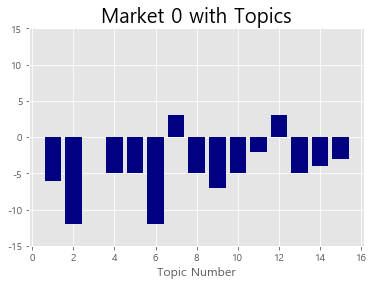

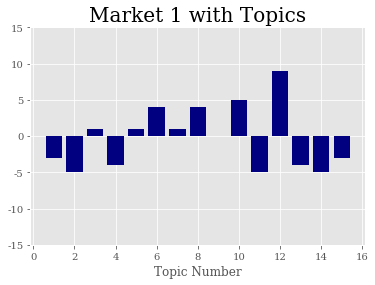

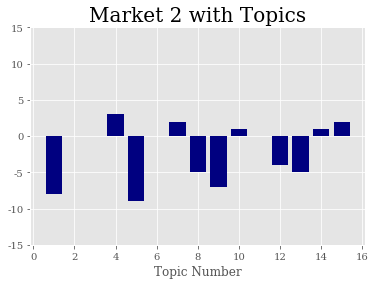

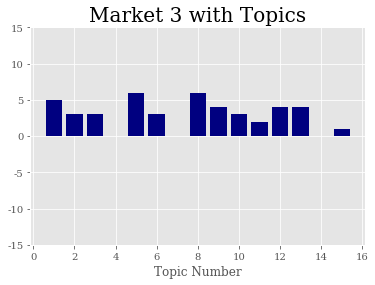

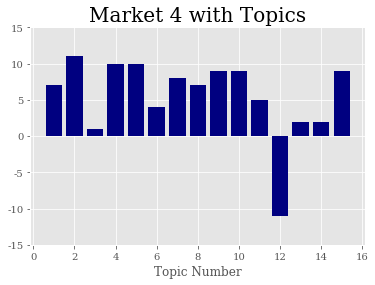

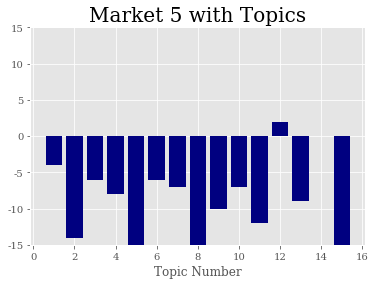

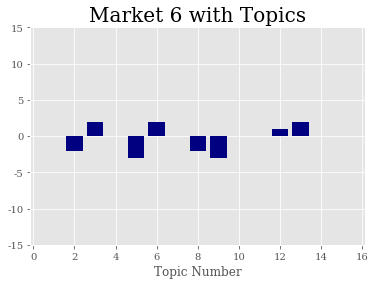

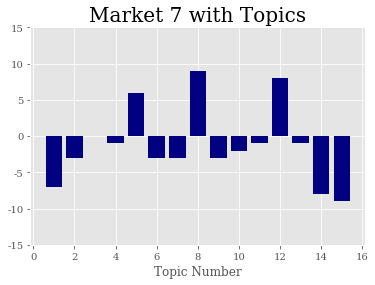

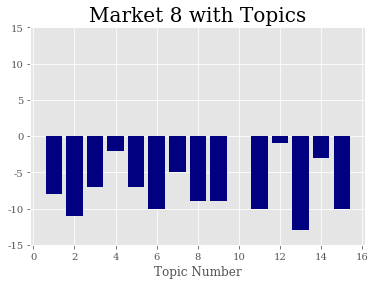

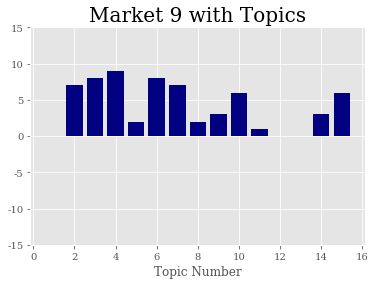

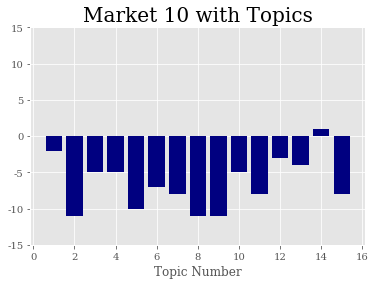

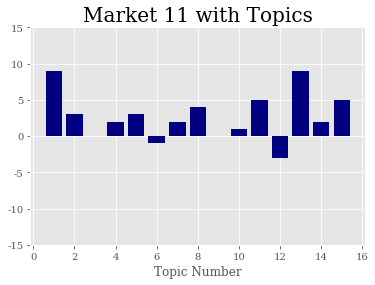

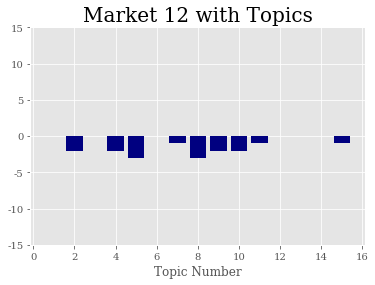

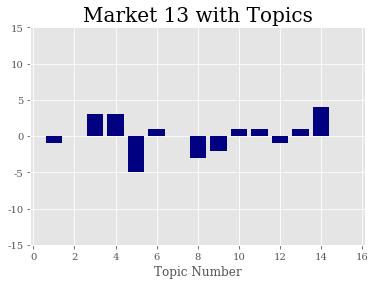

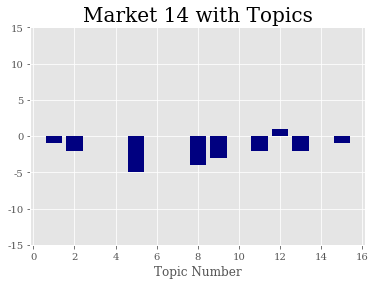

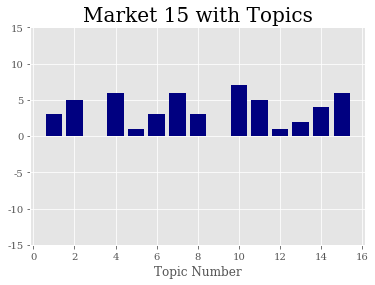

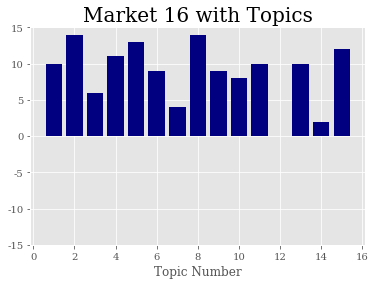

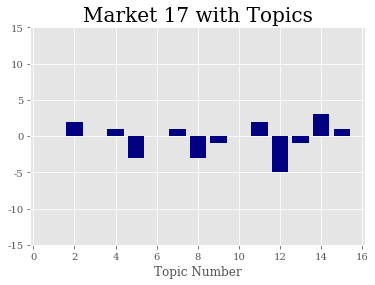

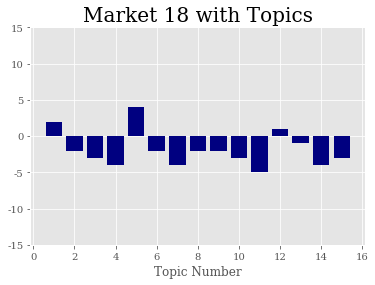

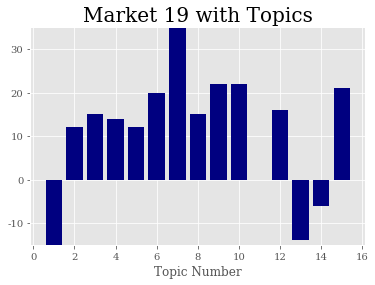

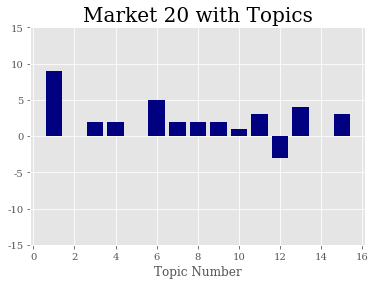

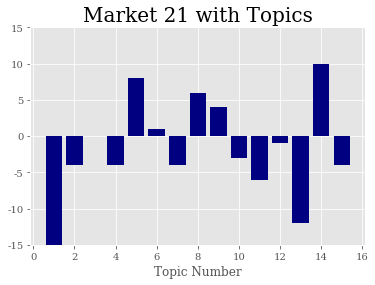

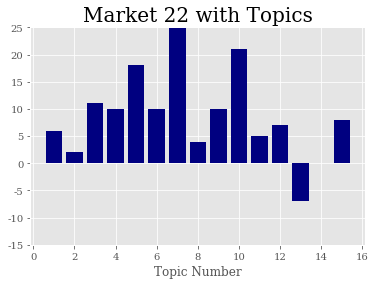

In [75]:
for i in range(23):
    plot_market(i)

In [30]:
style.use('ggplot')

In [200]:
#import matplotlib.font_manager as fm

#font_location = "08SeoulNamsanM_0.ttf" 
                    # ex - 'C:/asiahead4.ttf'
#font_name = fm.FontProperties(fname = font_location).get_name()
#matplotlib.rc('font', family = font_name)

In [ ]:
#percent_dict["market_name"][6]["index"] = mx_list
#plt.rc('font', family = font_name)

#plt.barplot(x , y)
#plt.xticks(percent_dict["market_name"][6].index, mx_list)

#ax.set_ylim(-30,30)
#ax.get_children()[2].set_color('r') 

#y = percent_dict["market_name"][6]["USE_AMT"]

#ax = plt.bar(x, y, legend=True, fontsize=12, color = "navy", alpha = 0.7)

#ax = sns.barplot(x = market_names, y= "USE_AMT",data = percent_dict["market_name"][6])
#ax.fig.set_figheight(6)
#ax.fig.set_size_inches(15,12)
#percent_dict["market_name"][6]["index"] = mx_list

In [31]:
def plot_function(crit, tp):
    titlename = "Topic {0} with {1}".format(tp+1, crit)
    pobj =percent_dict[crit][tp]
    ax = pobj.plot(y = "USE_AMT" ,kind='bar', figsize=(15, 10), legend=True, fontsize=12, color = "seagreen", alpha = 0.7)

    
    ax.set_xlabel(crit.upper(), fontsize=20)
    ax.set_ylabel("Percentage", fontsize=15)

    #plt.rc('font', family = font_name)

    plt.ylim(-30, 30)
    plt.rcParams['font.family'] = "serif"
    plt.title(titlename, fontsize = 30)
    
    if crit == "market_name" :
        mx_list = [str(mar2idx[i]) for i in pobj.index]
        x = mx_list 
        plt.gca().set_xticklabels(mx_list, rotation = 45, horizontalalignment = "right")
    else :  
        plt.gca().set_xticklabels(pobj.index, rotation = 0, horizontalalignment = "right", fontsize = 20)
    #plt.rc("font" ,family = font_name)
    for i, v in enumerate(pobj["USE_AMT"]) :
        if v > 0 :
            ax.text(i-0.1, v+0.5, str(int(v)), fontweight = "bold", fontsize = 15)
        else :
            ax.text(i-0.1, v-1.5, str(int(v)), fontweight = "bold", fontsize = 15)
            
    
    plt.savefig("%s, %s Analyzed factor with leverage.pdf" % (crit , tp))
    plt.show()
    

In [32]:
critlist

['AGE_CD', 'SEX_CD', 'market_name']

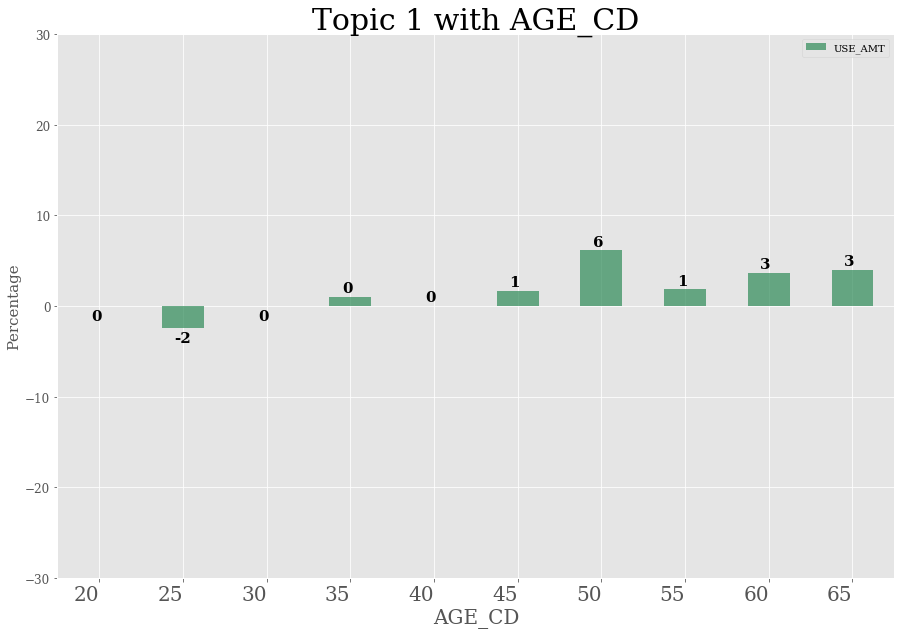

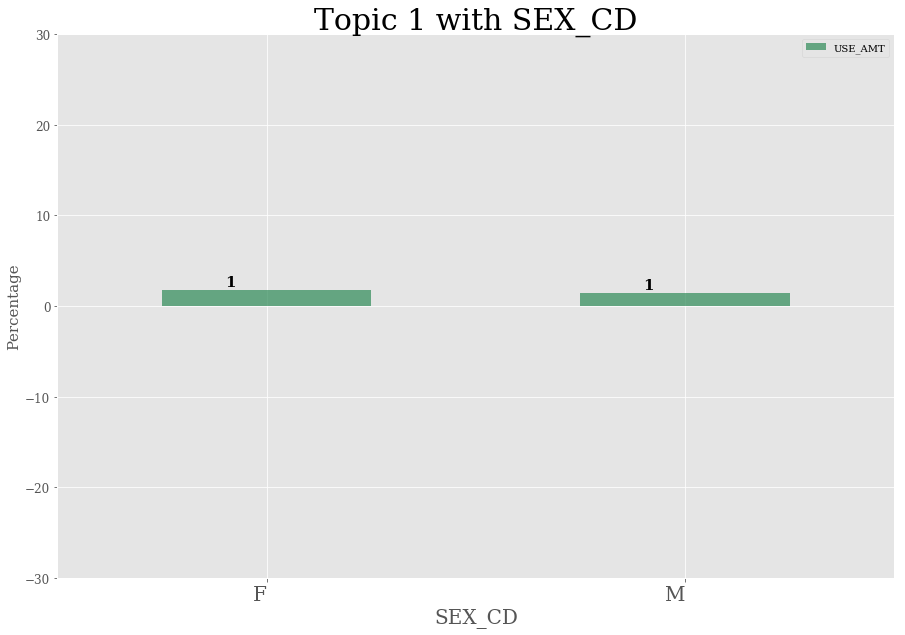

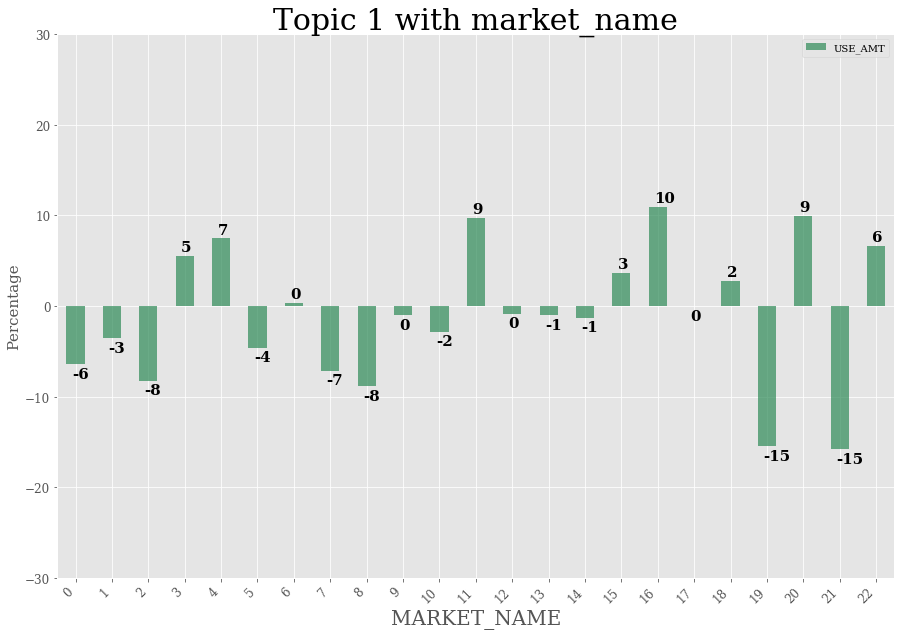

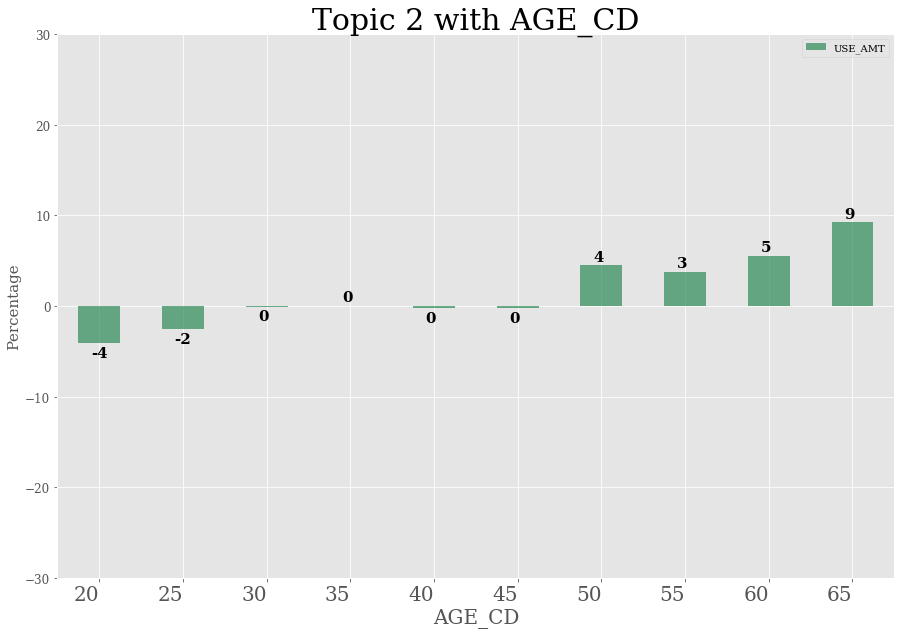

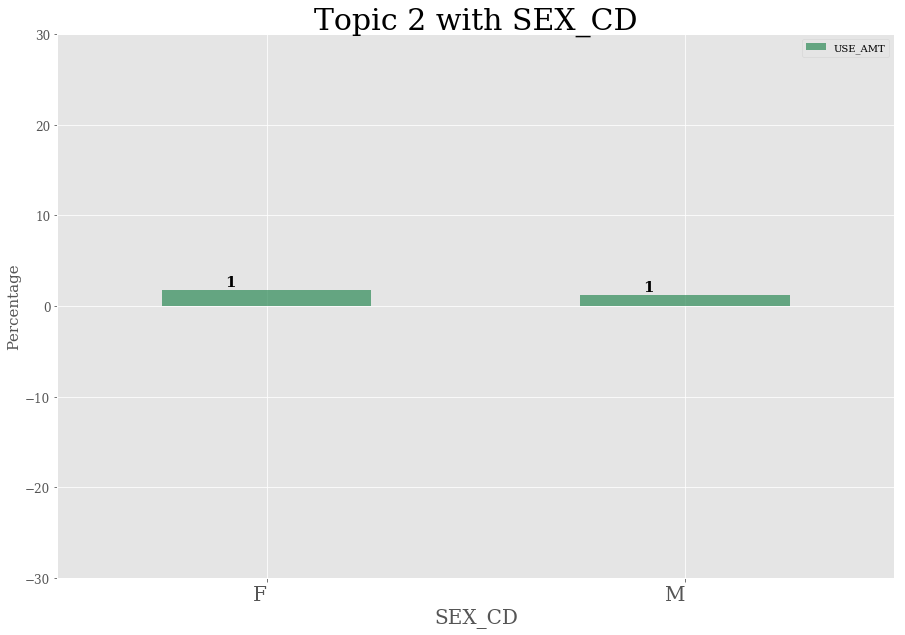

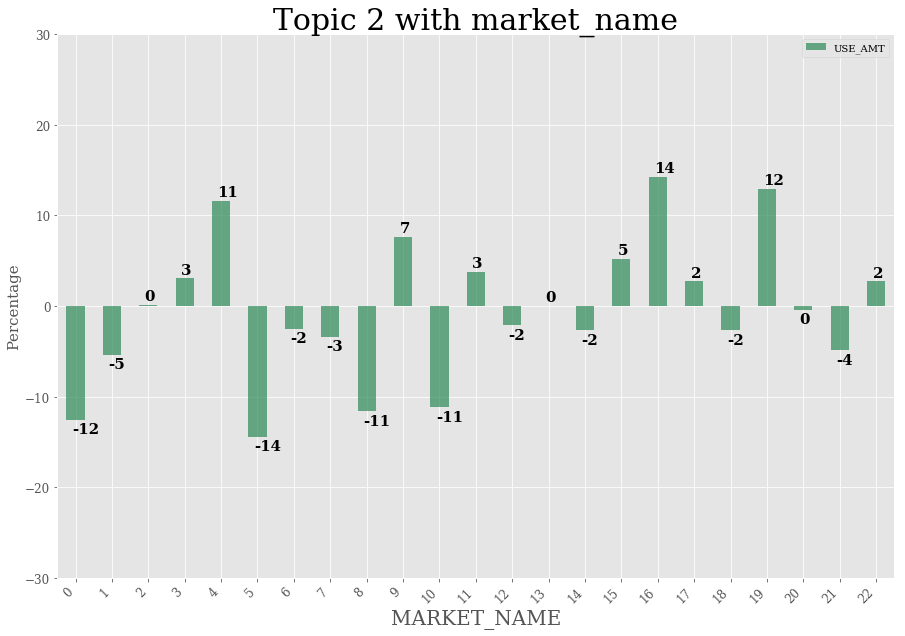

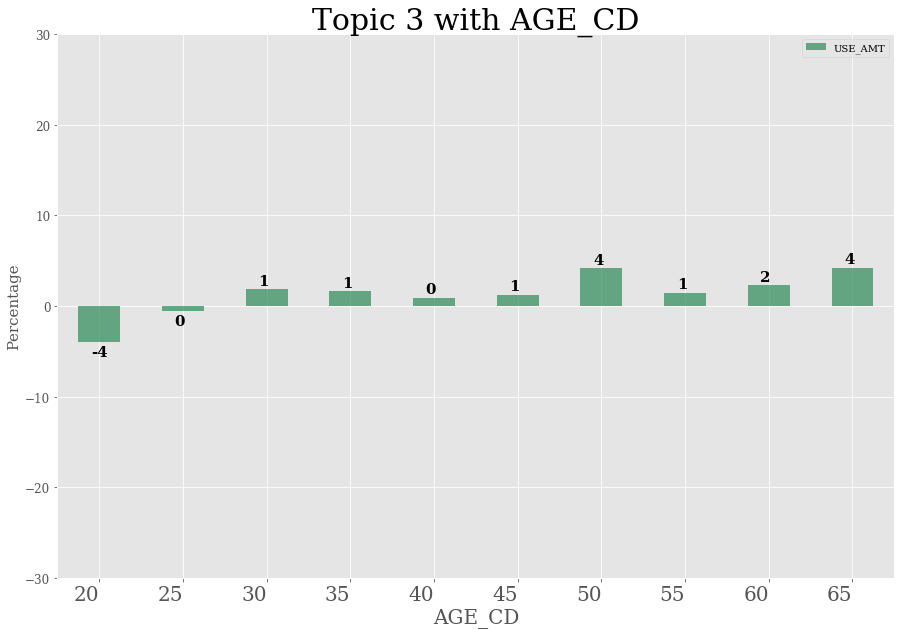

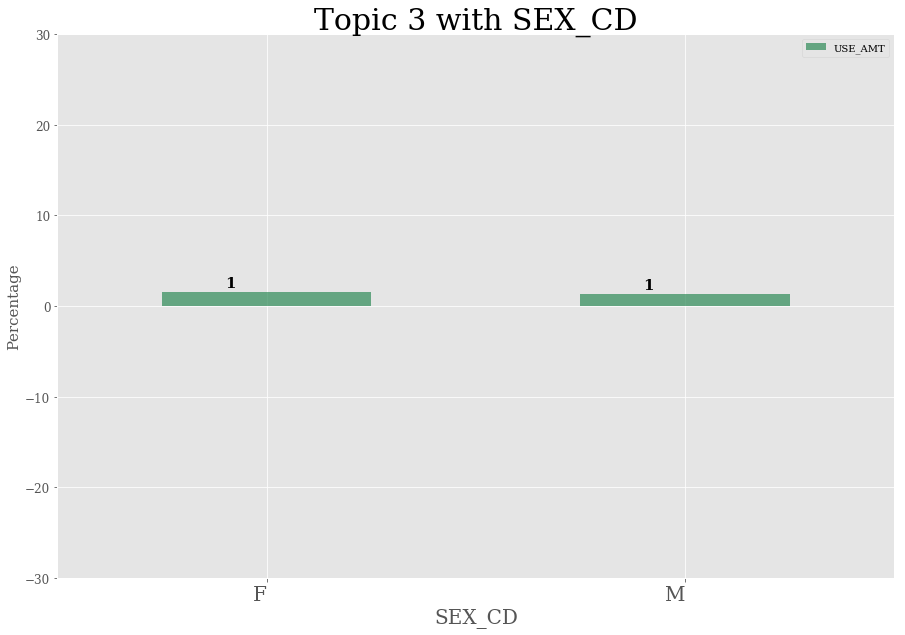

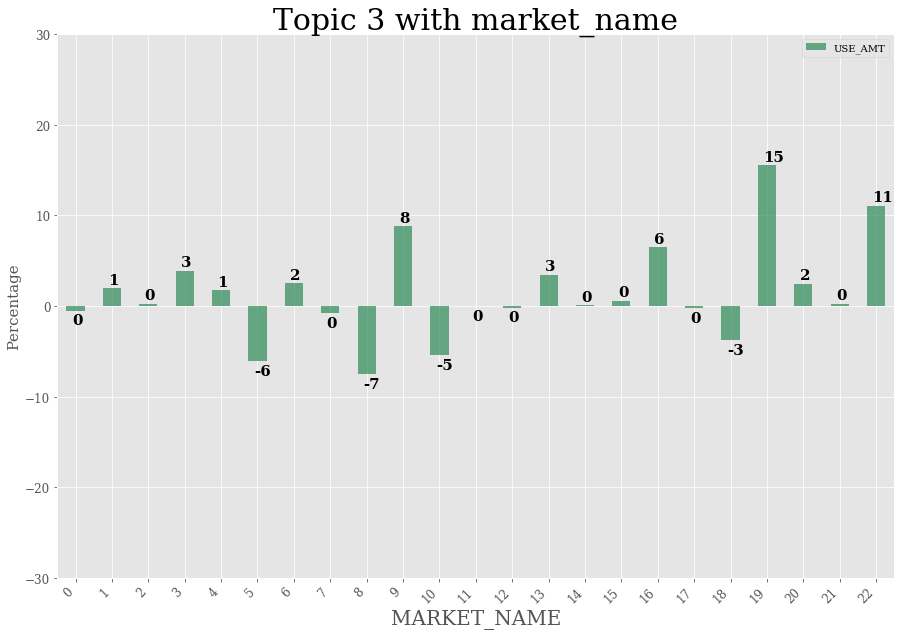

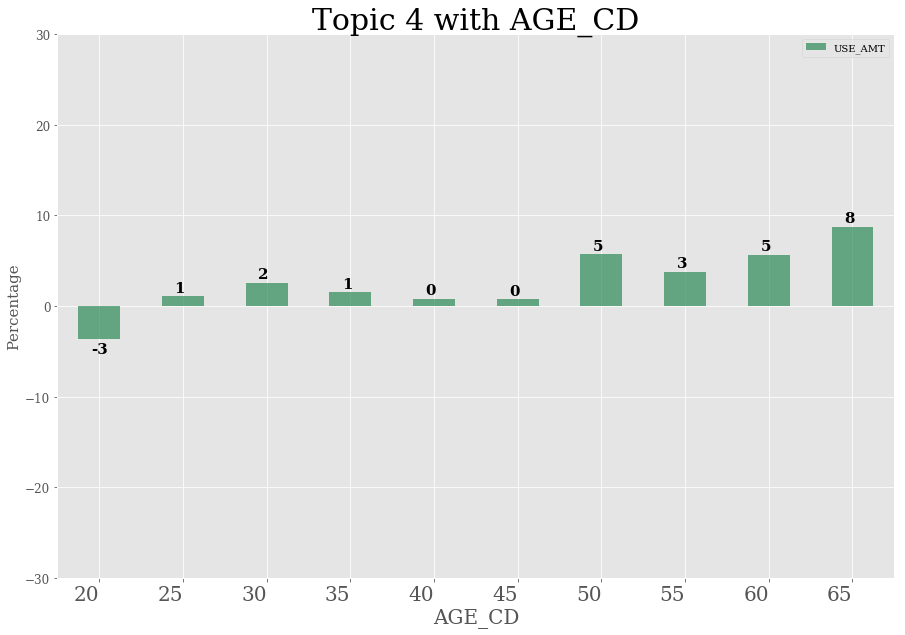

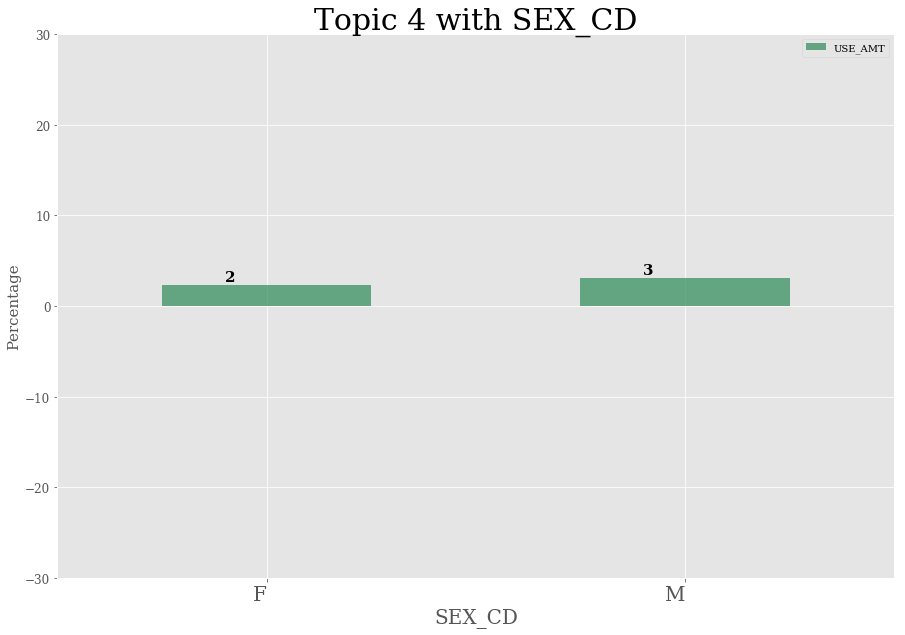

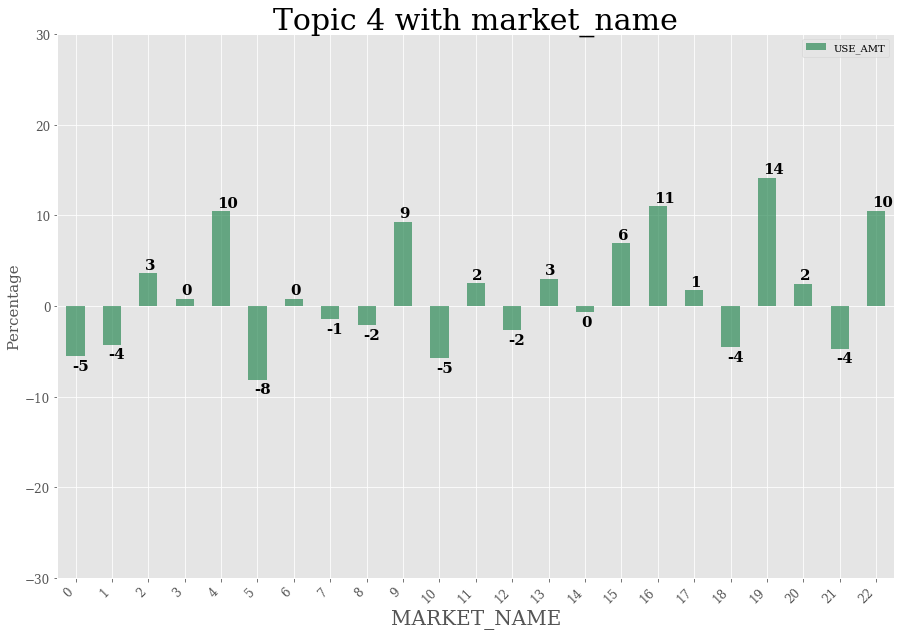

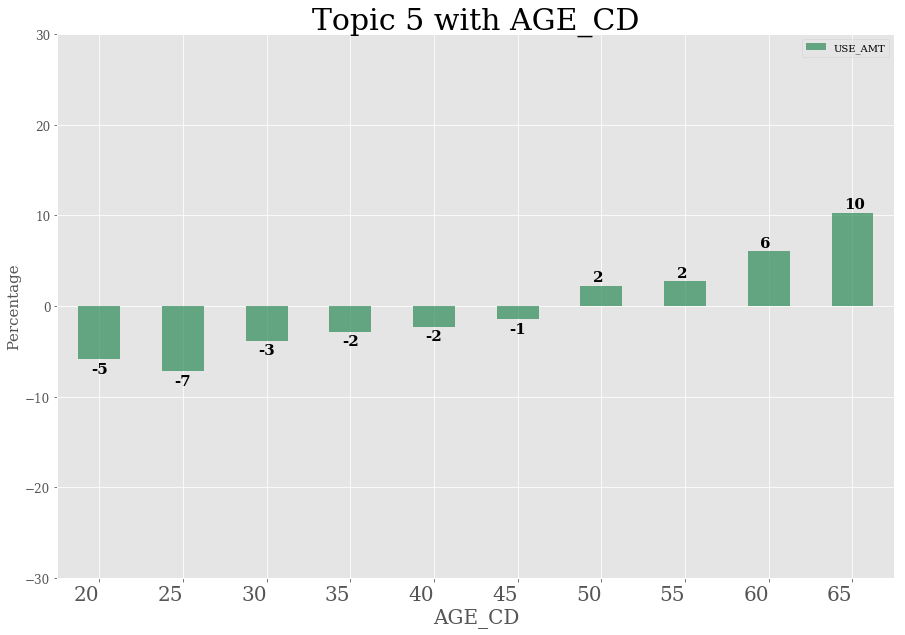

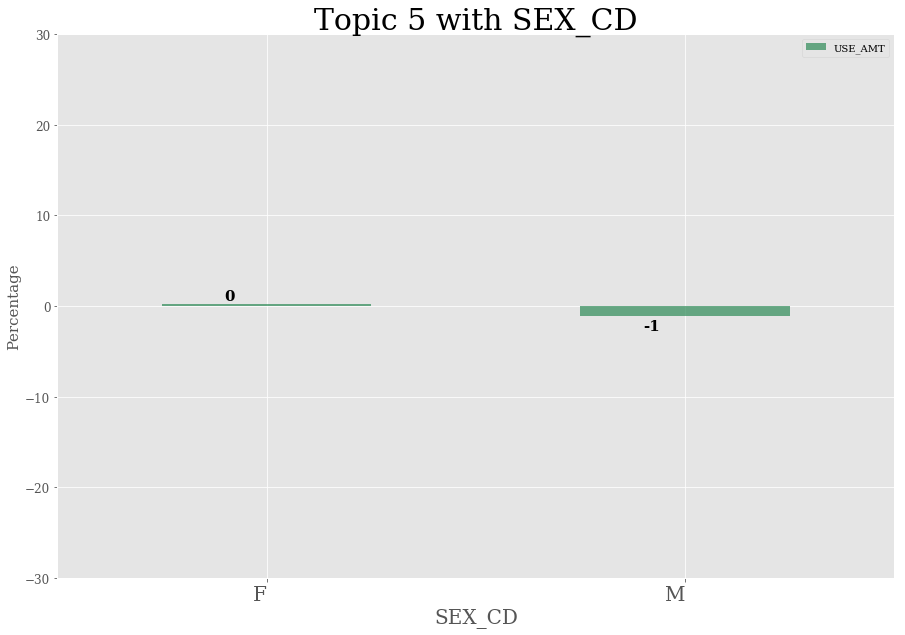

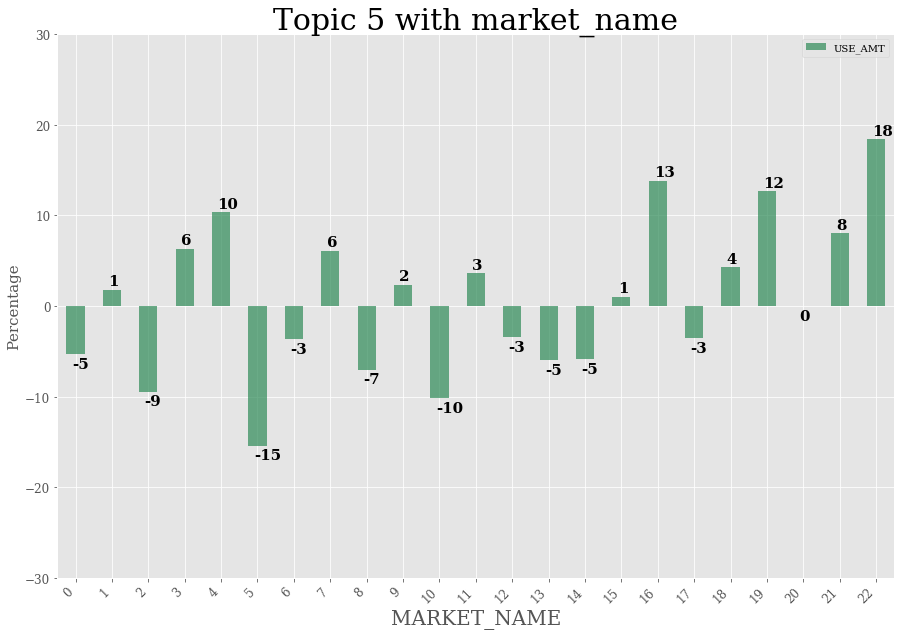

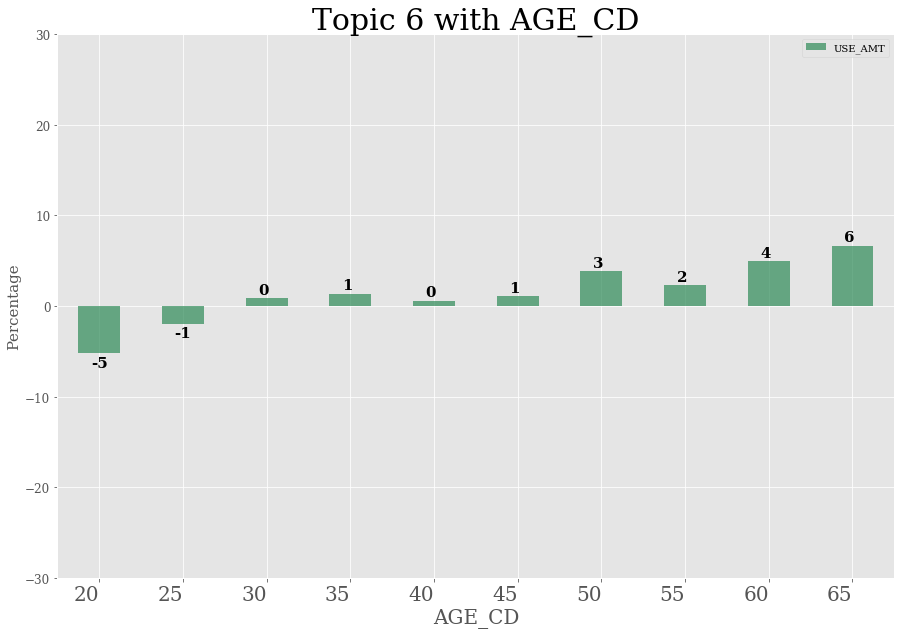

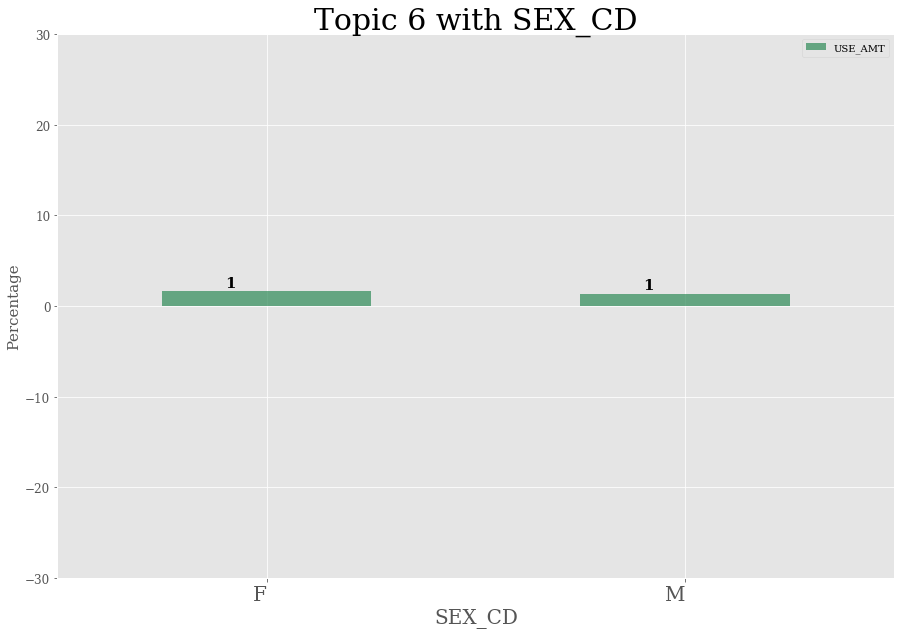

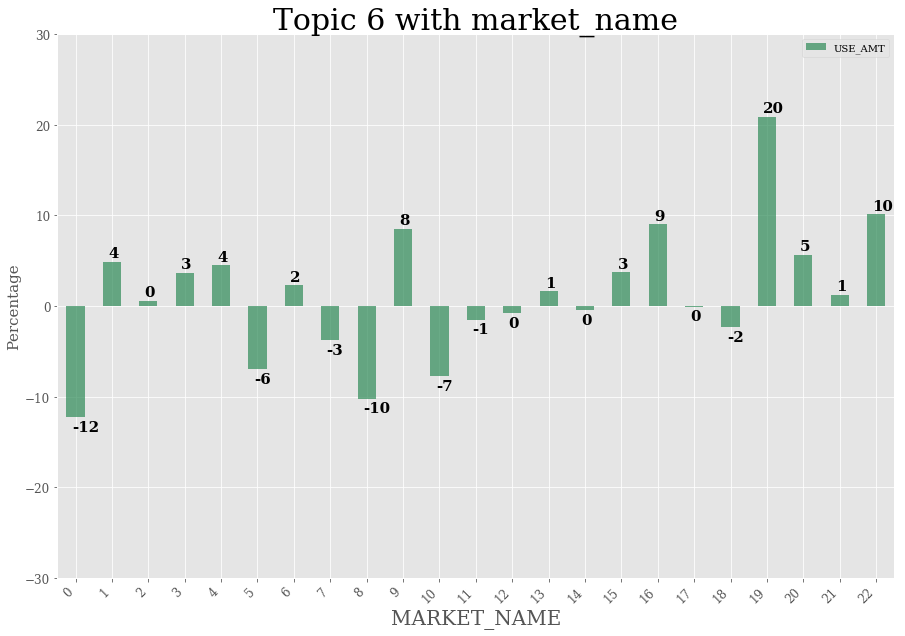

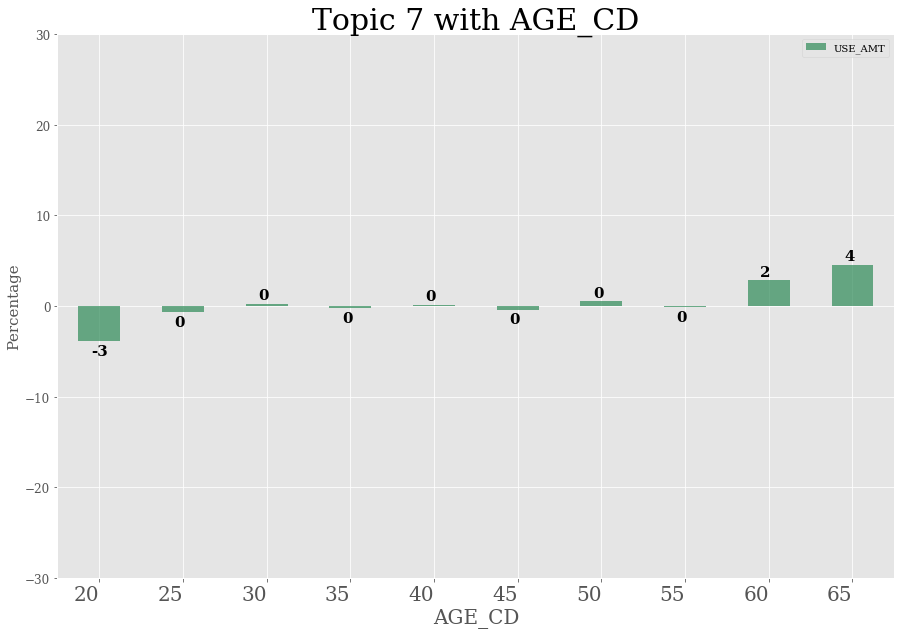

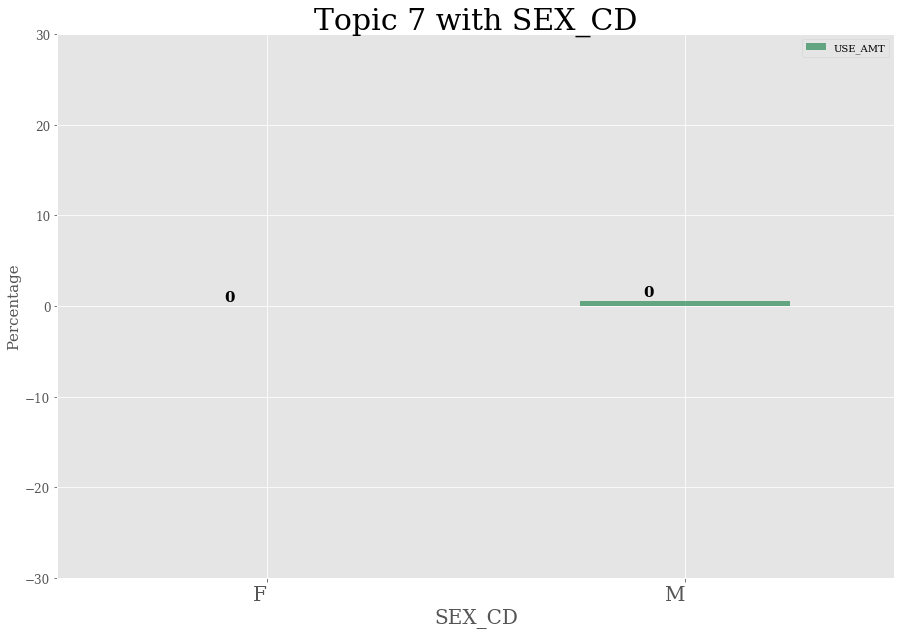

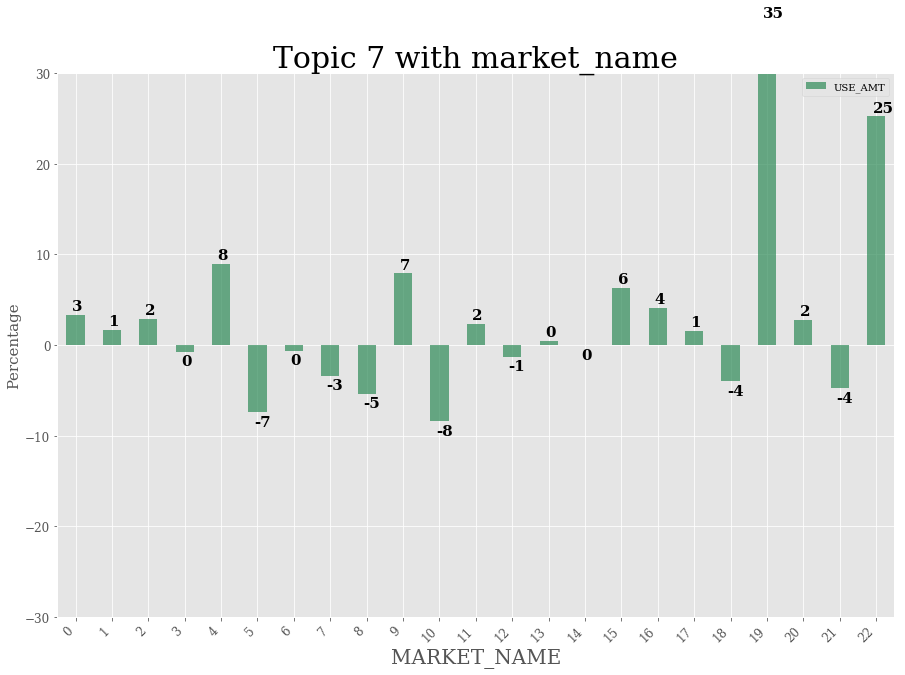

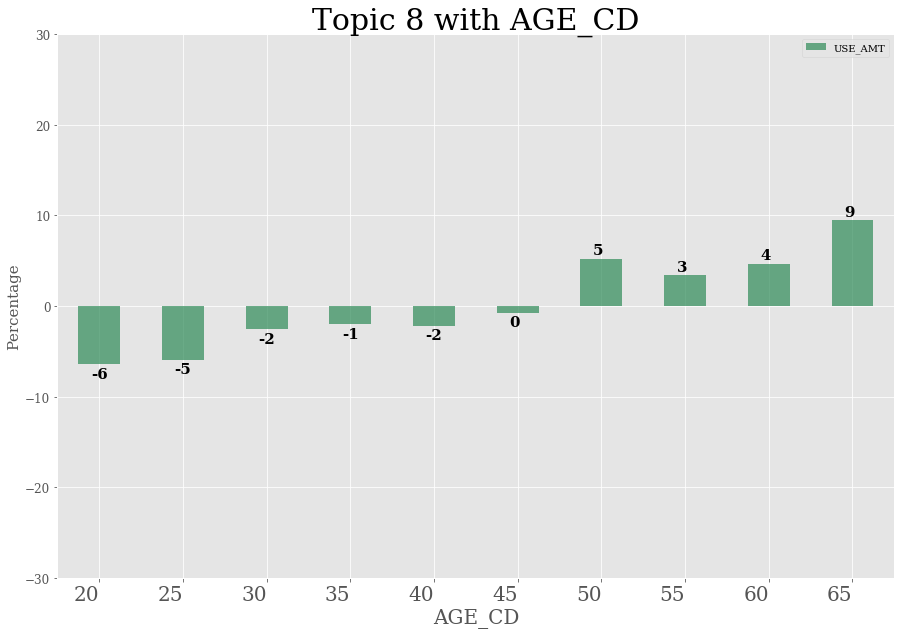

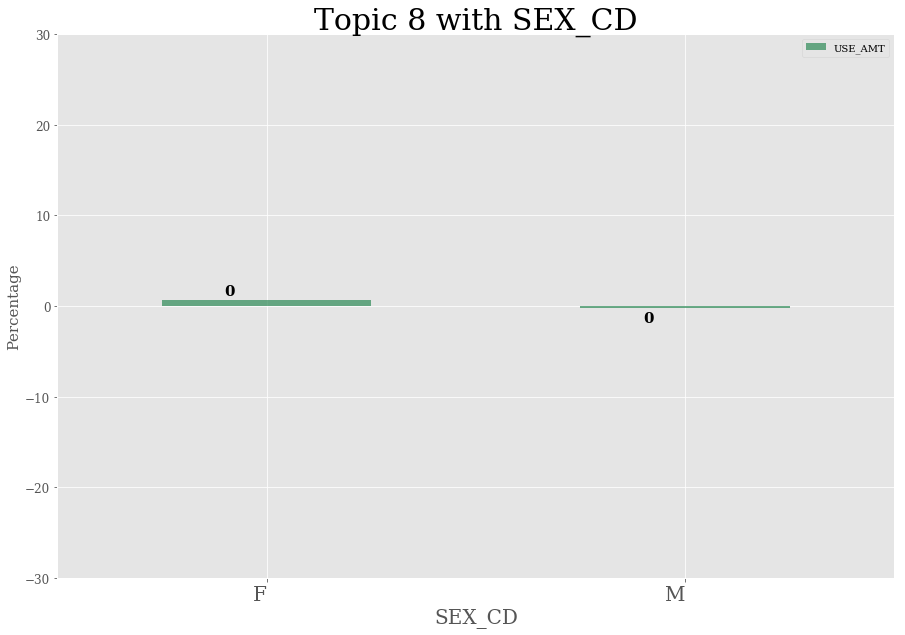

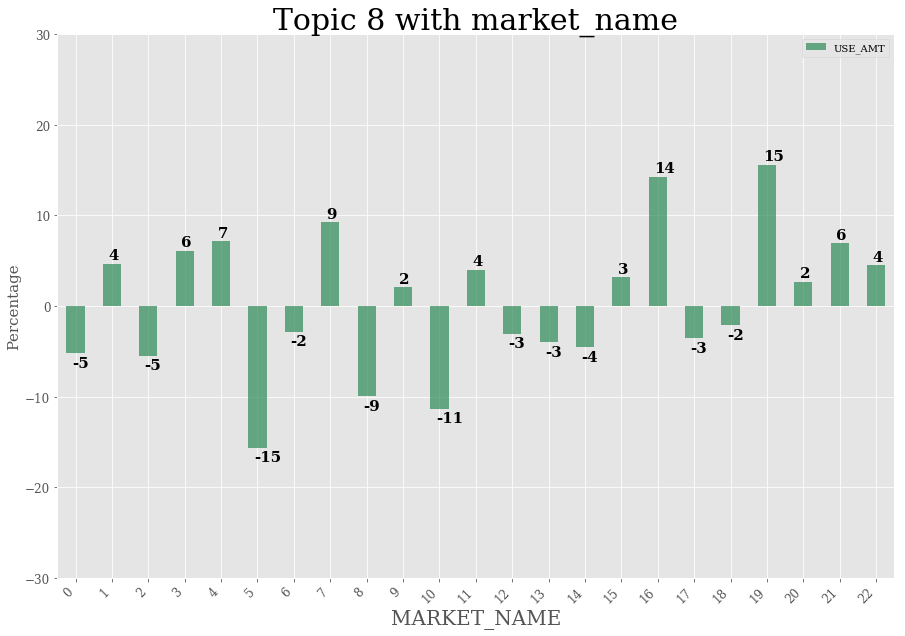

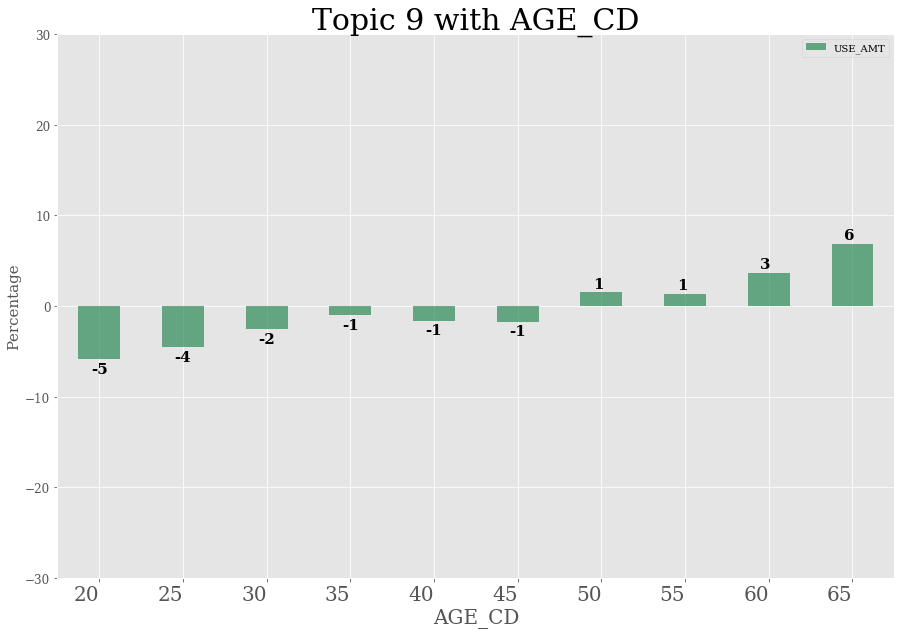

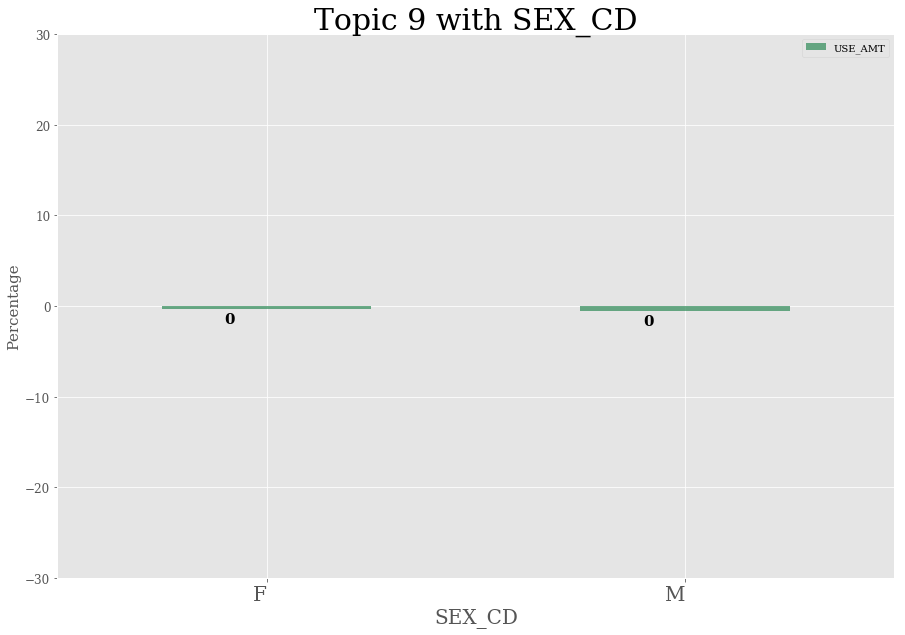

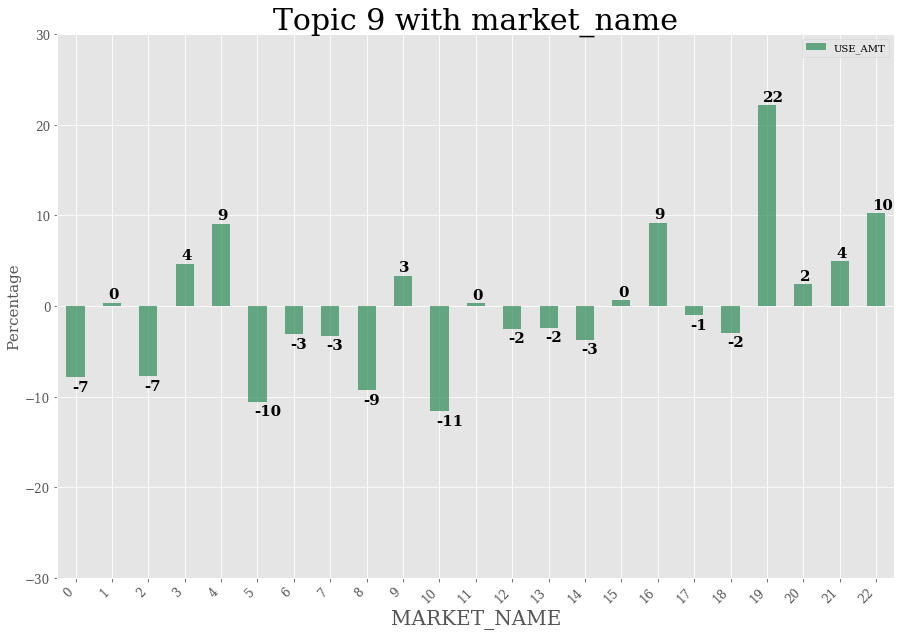

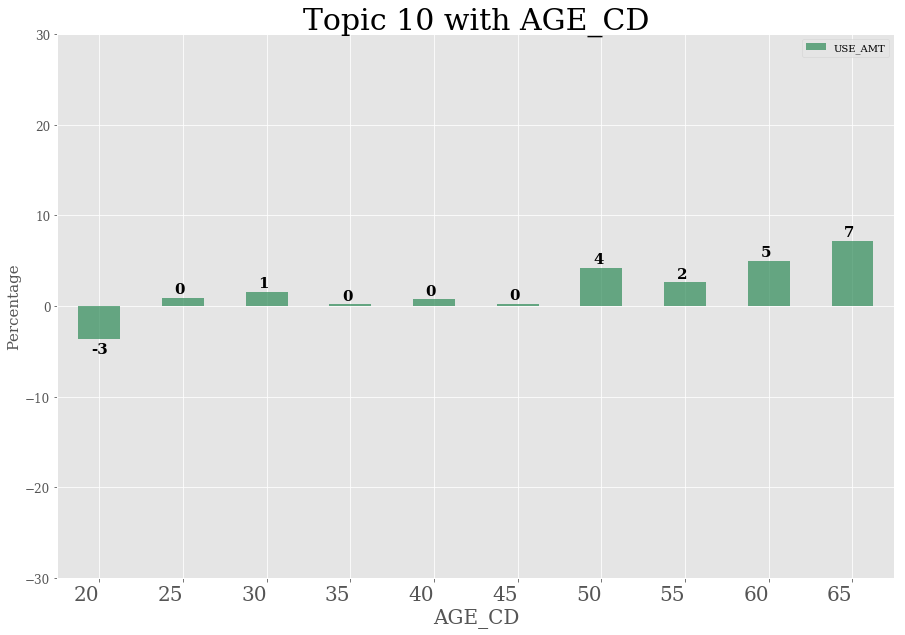

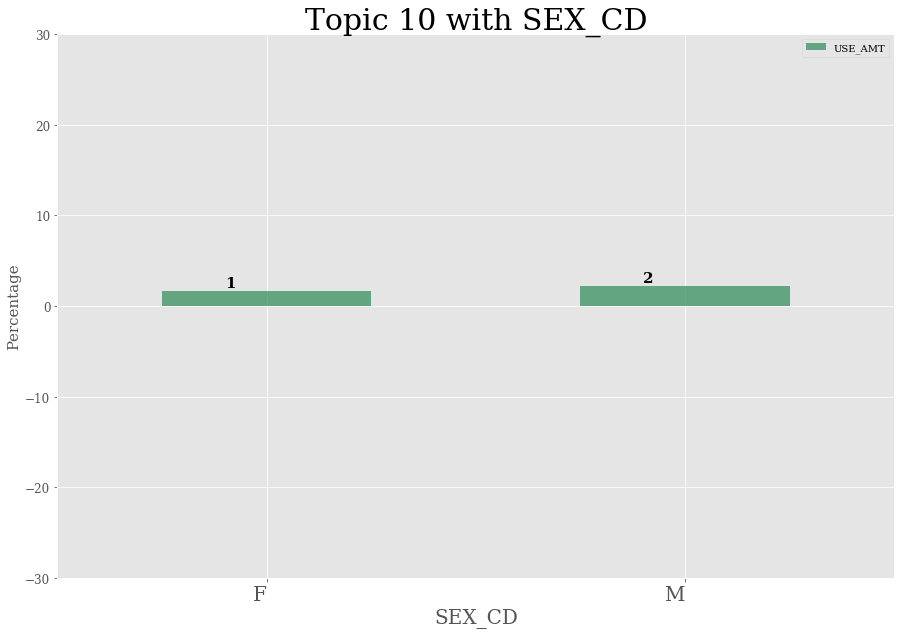

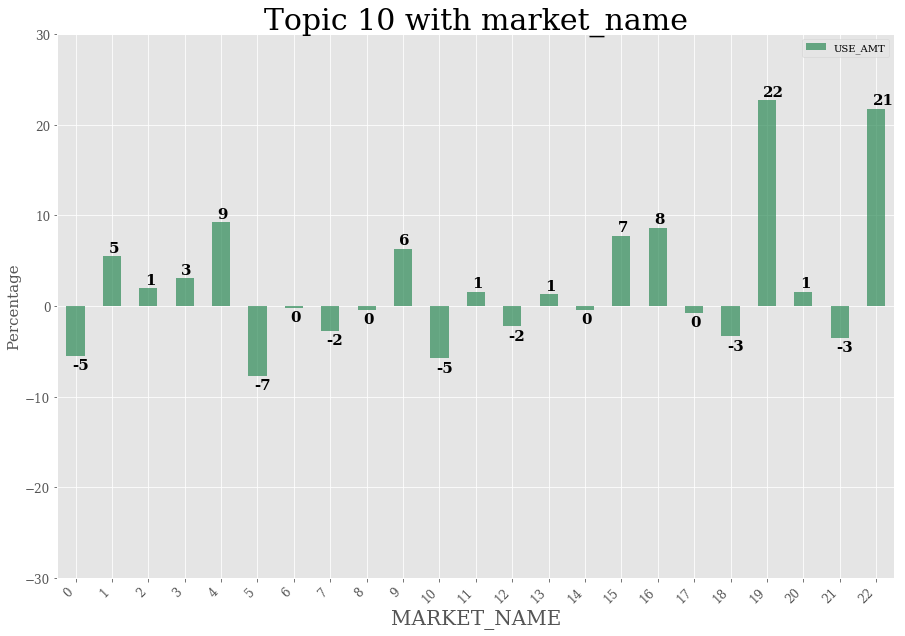

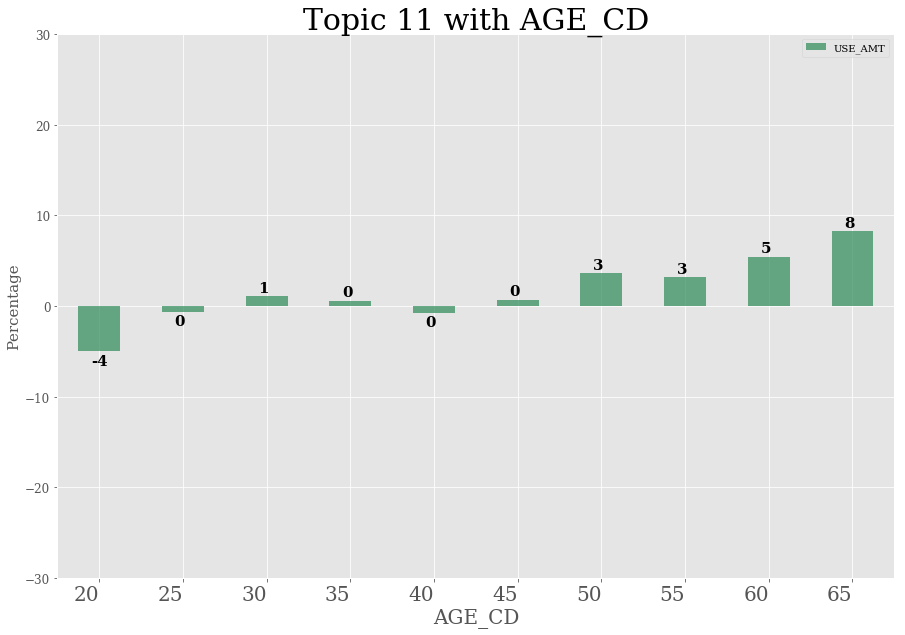

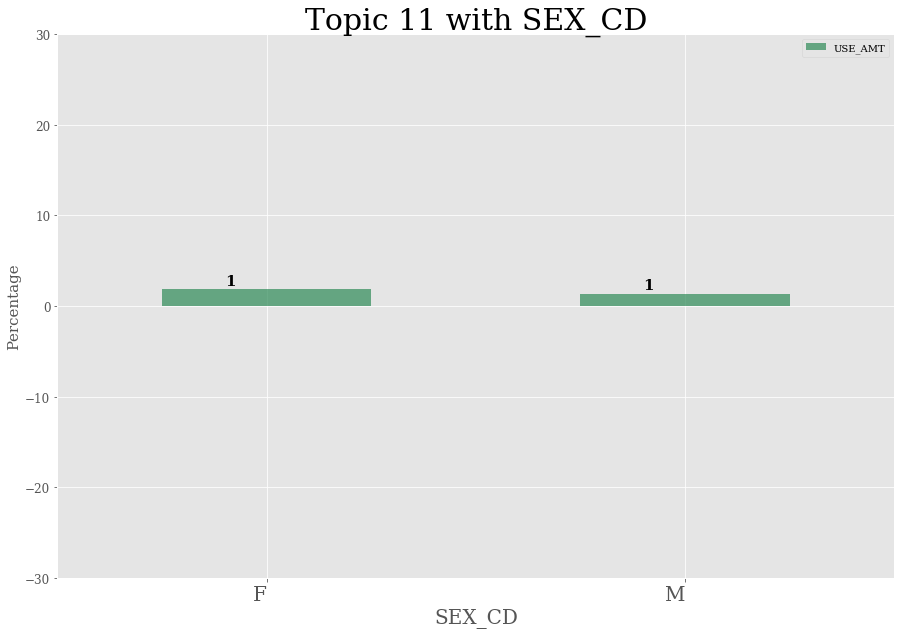

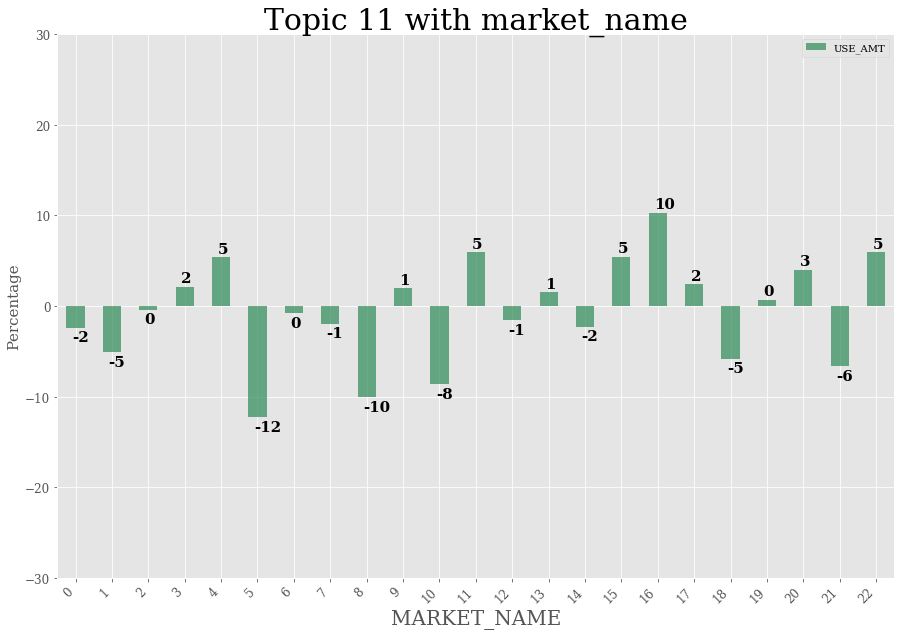

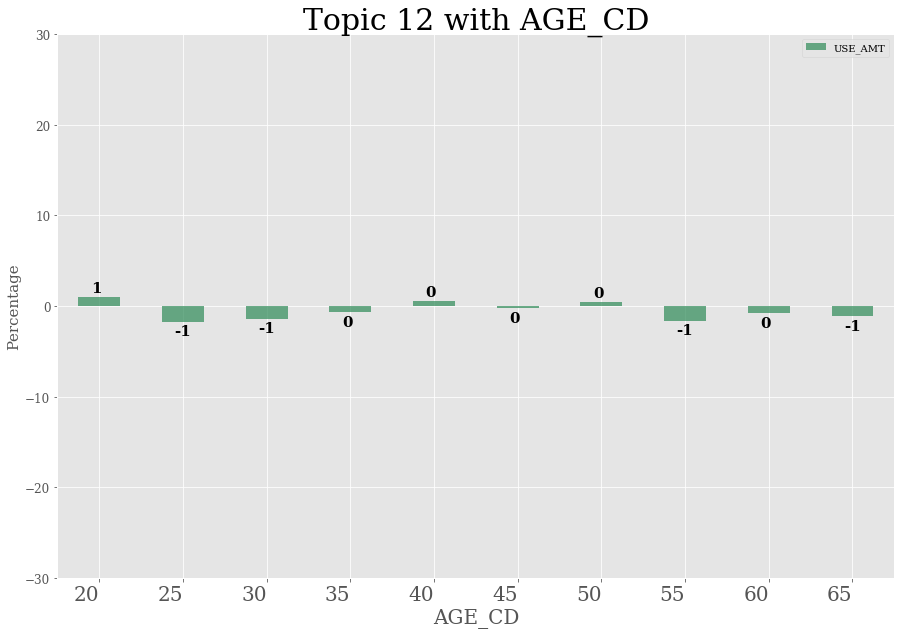

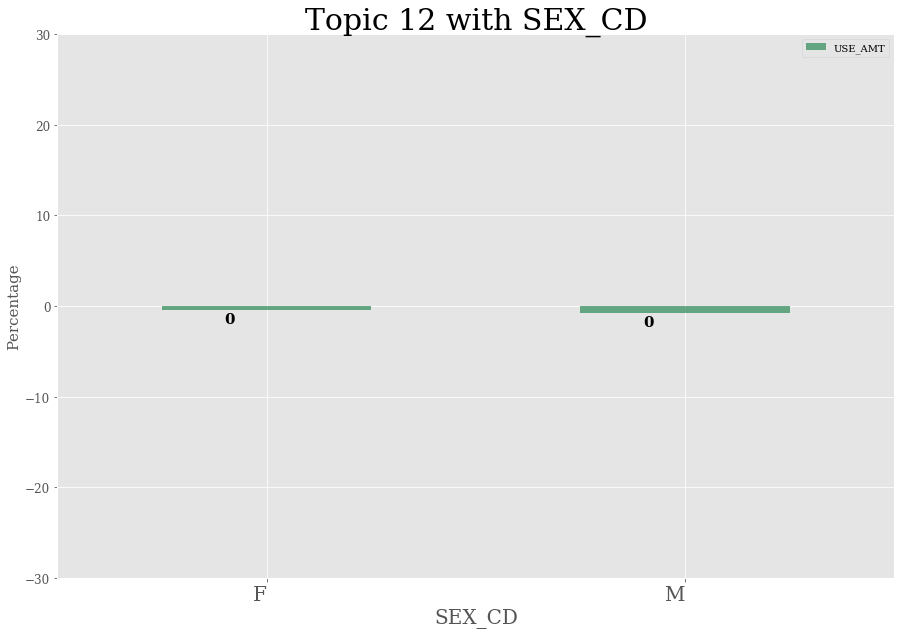

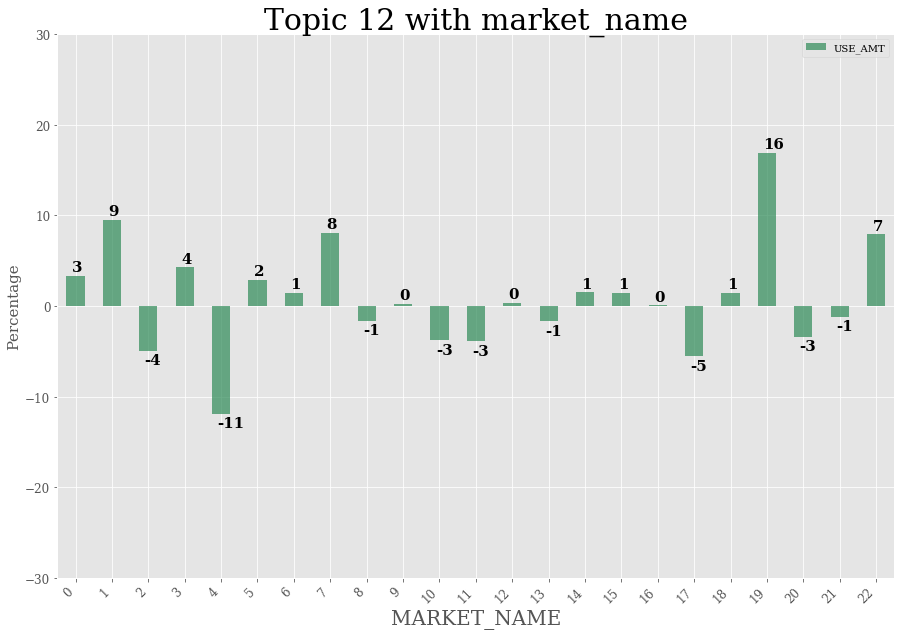

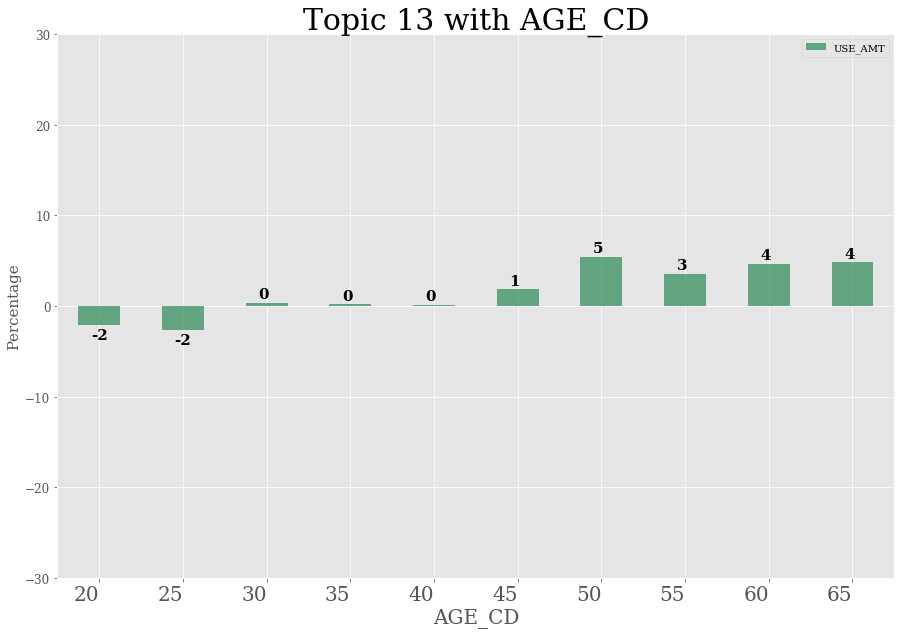

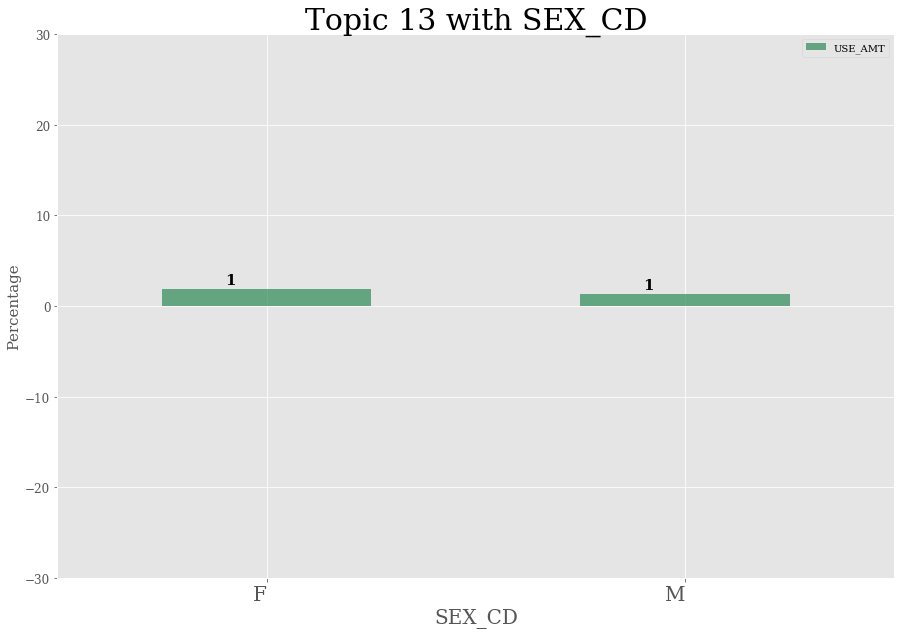

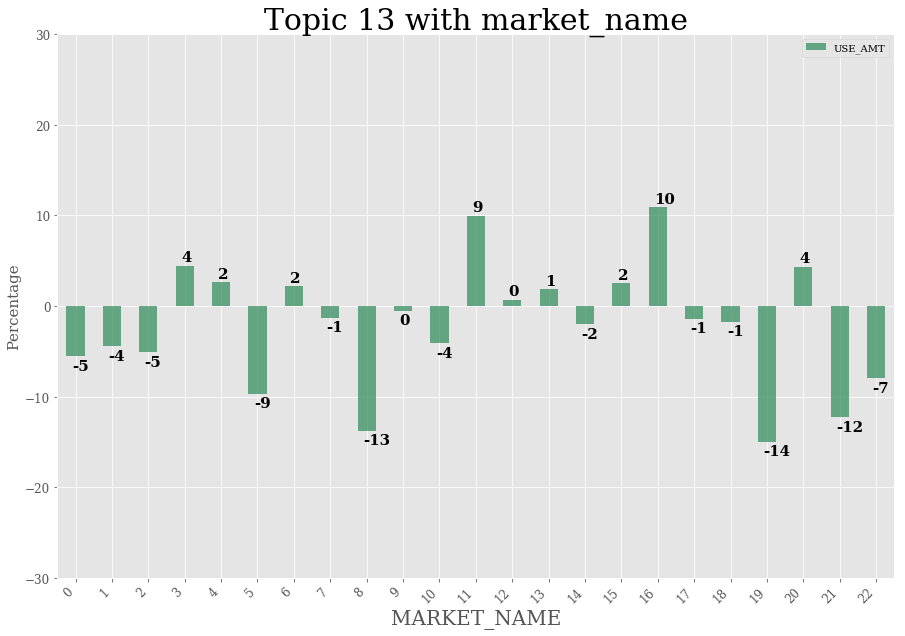

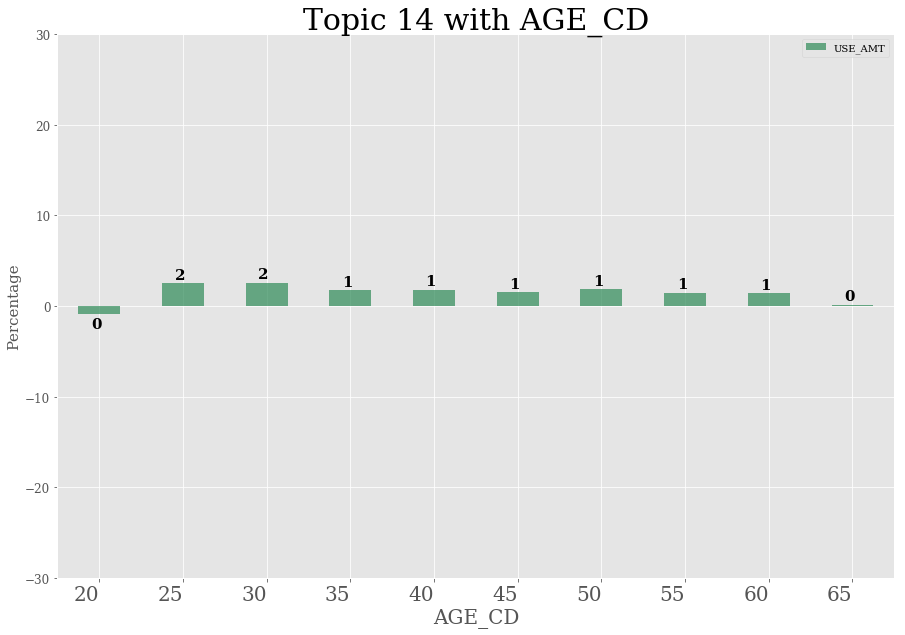

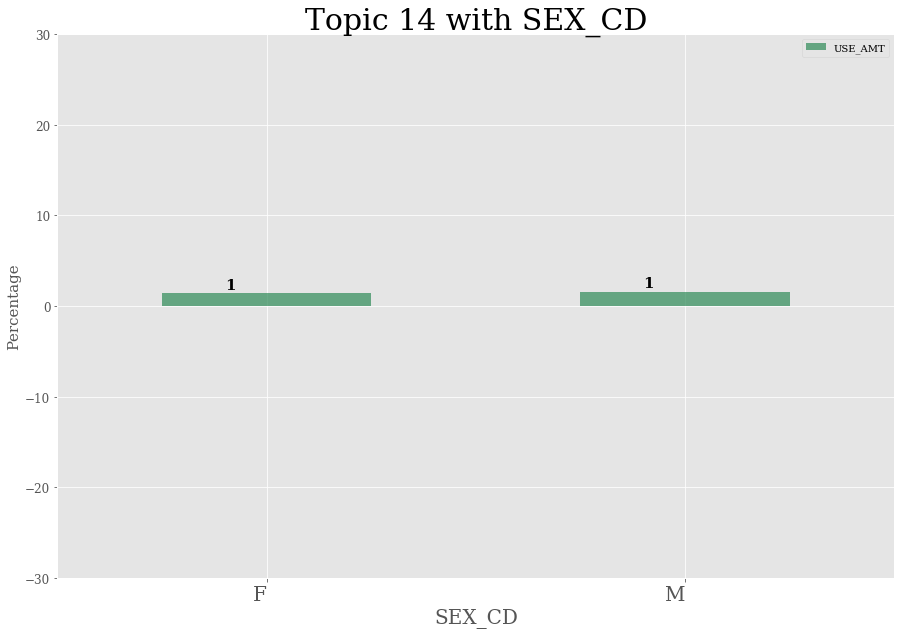

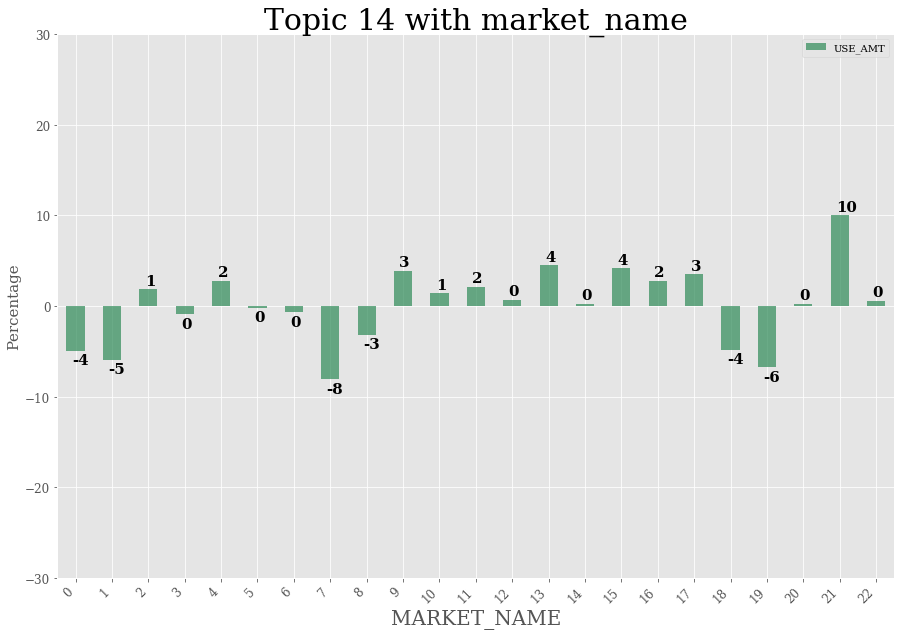

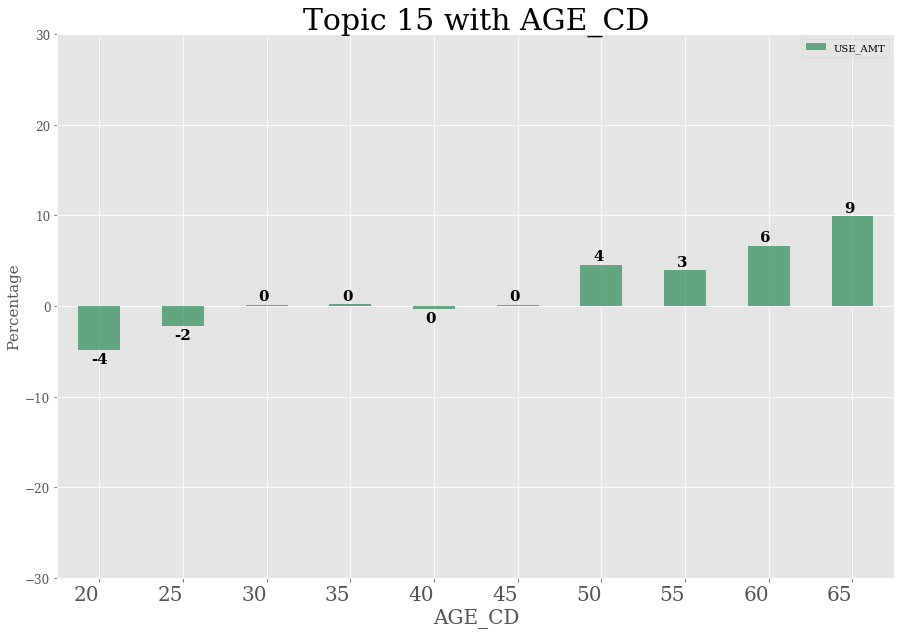

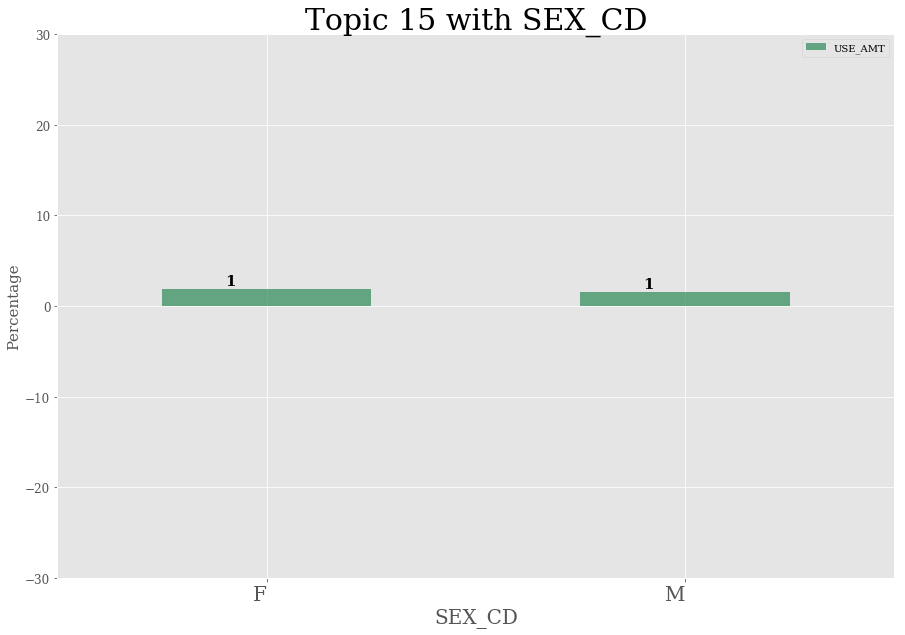

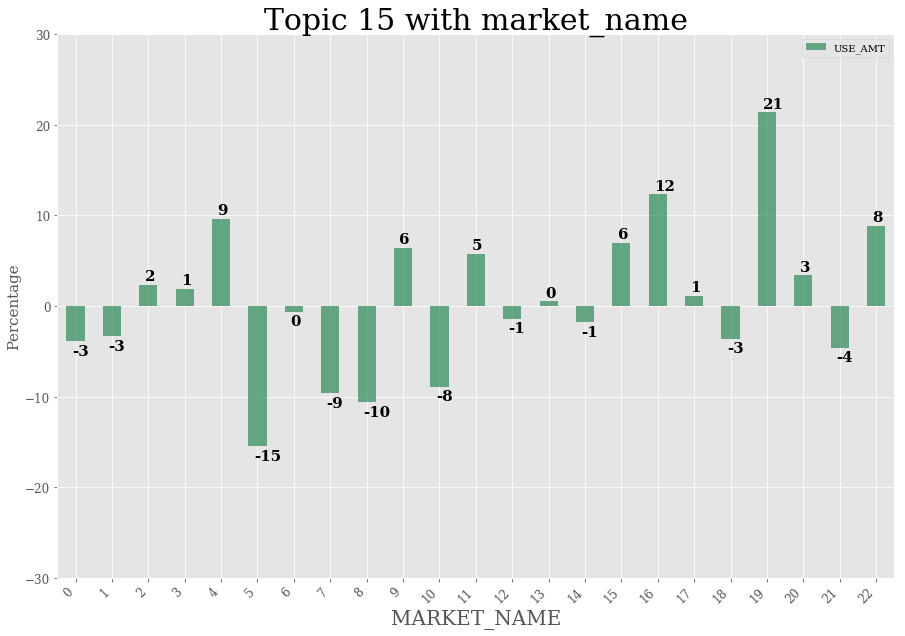

In [33]:
for i in tplist : 
    for j in critlist :
        plot_function(j, i)


In [34]:
 m2 = percent_dict["AGE_CD"][0]["USE_AMT"].values

In [35]:
for i in range(1, 15):
    temp = percent_dict["AGE_CD"][i]["USE_AMT"].values
    m2 = np.vstack((m2, temp))

In [36]:
def plot_age(mi):
    AGE_list = [i for i in range(20,70, 5)]
    x = [i+1 for i in range(15)]
    y = m2[:, mi].astype(int)
    titlename = "AGE {0} with Topics".format(AGE_list[mi])
    
    ax = plt.bar(x, y, color = "navy")
    
    u1 = max(y)
    u2 = 12
    
    l1 = min(y)
    l2 = -12
    
    u = max(u1, u2)
    l = min(l1, l2)
    plt.xlabel("Topic Number")

    plt.ylim(l, u)
    plt.rcParams['font.family'] = "serif"
    plt.title(titlename, fontsize = 20)
    
    
    plt.show()

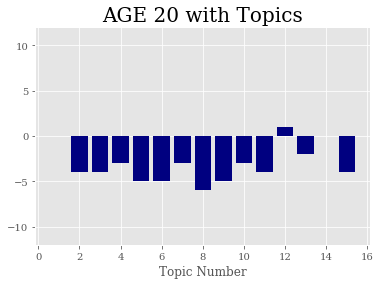

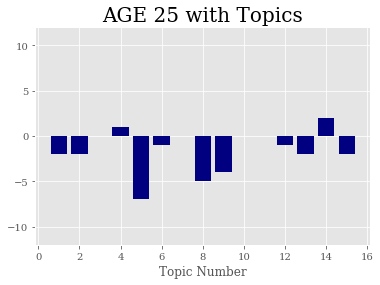

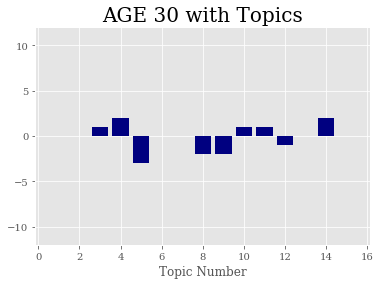

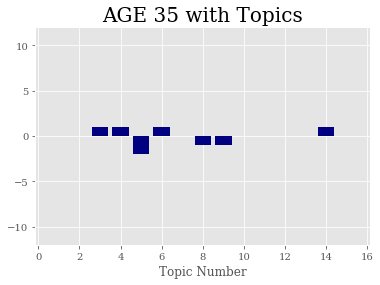

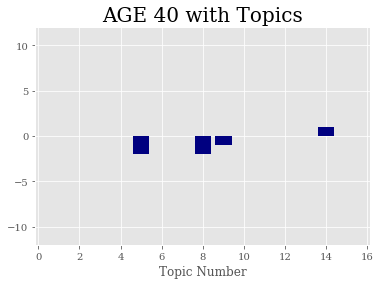

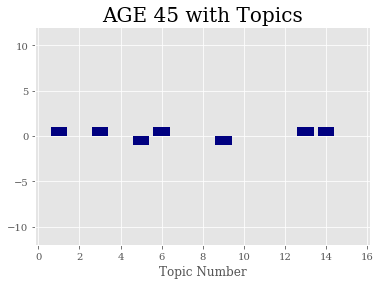

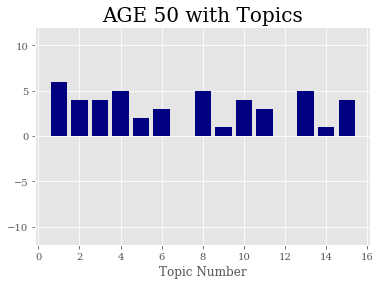

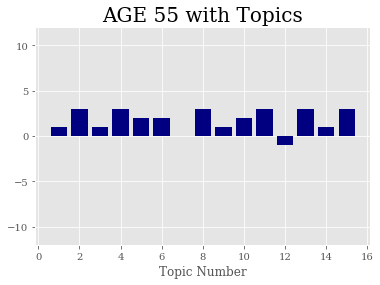

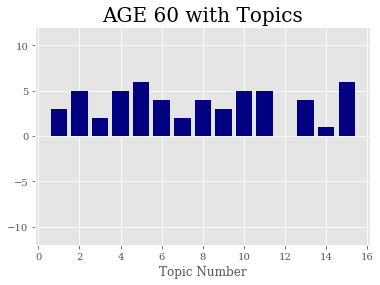

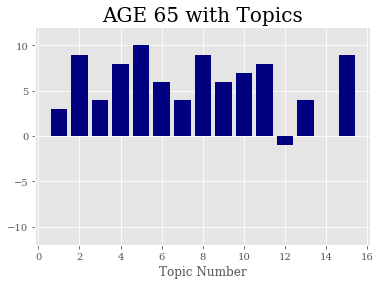

In [37]:
for i in range(10):
    plot_age(i)

In [38]:
d_result_dict = {}
def Get_Lever_two_crit(tp) :
    #1~5Grade will be assigned to top_50, while 6~10 will go to bot_50
    topic_name = "TD_{0}".format(tp)
    top_50_mask = wdf_copy[topic_name] <= 5 
    top_50, bot_50 = wdf_copy[top_50_mask], wdf_copy[~top_50_mask]
    
    prone = top_50.groupby(["market_name", "AGE_CD", "SEX_CD"]).mean() / bot_50.groupby(["market_name", "AGE_CD", "SEX_CD"]).mean()
    pro = wdf_copy.groupby(["market_name", "AGE_CD", "SEX_CD"]).mean()
    print(" Topic %s is done." % (tp + 1))
    return [pro[["USE_AMT"]].reset_index(),prone[["USE_AMT"]].reset_index()]

In [39]:
pd.options.display.max_rows = None

In [40]:
for i in range(15) :
    d_result_dict[i+1] = Get_Lever_two_crit(i)


 Topic 1 is done.
 Topic 2 is done.
 Topic 3 is done.
 Topic 4 is done.
 Topic 5 is done.
 Topic 6 is done.
 Topic 7 is done.
 Topic 8 is done.
 Topic 9 is done.
 Topic 10 is done.
 Topic 11 is done.
 Topic 12 is done.
 Topic 13 is done.
 Topic 14 is done.
 Topic 15 is done.


In [41]:
d_result_dict[1][1][d_result_dict[1][1]["market_name"]=="가구"]

,market_name,AGE_CD,SEX_CD,USE_AMT
0,가구,20,F,1.539285
1,가구,20,M,1.252962
2,가구,25,F,1.818985
3,가구,25,M,0.806048
4,가구,30,F,1.060290
5,가구,30,M,2.293439
6,가구,35,F,0.672568
7,가구,35,M,0.309286
8,가구,40,F,1.224737
9,가구,40,M,1.151144


In [42]:
d_result_dict[3][0][d_result_dict[1][0]["market_name"]=="사무통신"]

,market_name,AGE_CD,SEX_CD,USE_AMT
140,사무통신,20,F,303.983389
141,사무통신,20,M,367.815610
142,사무통신,25,F,434.623529
143,사무통신,25,M,530.388288
144,사무통신,30,F,512.747148
145,사무통신,30,M,771.297641
146,사무통신,35,F,467.342159
147,사무통신,35,M,782.812386
148,사무통신,40,F,409.381579
149,사무통신,40,M,892.381034


In [43]:
d_result_dict[12][1][d_result_dict[12][1]["market_name"]=="주방용구"]

,market_name,AGE_CD,SEX_CD,USE_AMT
440,주방용구,20,F,1.097296
441,주방용구,20,M,0.502096
442,주방용구,25,F,0.908212
443,주방용구,25,M,1.738229
444,주방용구,30,F,0.884780
445,주방용구,30,M,1.013877
446,주방용구,35,F,1.271522
447,주방용구,35,M,0.452669
448,주방용구,40,F,0.321603
449,주방용구,40,M,1.086428


In [44]:
d_result_dict[8][1][d_result_dict[8][1]["market_name"]=="레저용품"]

,market_name,AGE_CD,SEX_CD,USE_AMT
80,레저용품,20,F,1.018372
81,레저용품,20,M,0.992158
82,레저용품,25,F,1.158093
83,레저용품,25,M,0.988491
84,레저용품,30,F,1.243090
85,레저용품,30,M,1.251990
86,레저용품,35,F,1.057102
87,레저용품,35,M,1.336971
88,레저용품,40,F,1.090450
89,레저용품,40,M,0.971257


In [45]:
decline_list = []
for i in range(15) :
    temp = d_result_dict[i+1][1][d_result_dict[i+1][1]["USE_AMT"]<= 0.5]
    temp["combined"] = temp["market_name"] + "/"+temp["AGE_CD"].astype(str)+ "/" + temp["SEX_CD"].astype(str)
    temp["CT"] = str(i+1)+"/"+temp["AGE_CD"].astype(str)+ "/" + temp["SEX_CD"].astype(str)
    decline_list.append(temp)
    print(i+1)
    print(temp)


C:\Users\Choi Sung Wook\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\Choi Sung Wook\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


1
    market_name  AGE_CD SEX_CD   USE_AMT    combined      CT
7            가구      35      M  0.309286     가구/35/M  1/35/M
156        사무통신      60      F  0.356667   사무통신/60/F  1/60/F
381       자동차판매      20      M  0.341111  자동차판매/20/M  1/20/M
388       자동차판매      40      F  0.295916  자동차판매/40/F  1/40/F
398       자동차판매      65      F  0.397123  자동차판매/65/F  1/65/F
421          전기      20      M  0.436143     전기/20/M  1/20/M
441        주방용구      20      M  0.353193   주방용구/20/M  1/20/M
443        주방용구      25      M  0.403598   주방용구/25/M  1/25/M
459        주방용구      65      M  0.292636   주방용구/65/M  1/65/M
2
    market_name  AGE_CD SEX_CD   USE_AMT    combined      CT
0            가구      20      F  0.319335     가구/20/F  2/20/F
9            가구      40      M  0.413607     가구/40/M  2/40/M
386       자동차판매      35      F  0.387569  자동차판매/35/F  2/35/F
427          전기      35      M  0.462124     전기/35/M  2/35/M
446        주방용구      35      F  0.424690   주방용구/35/F  2/35/F
450        주방용구     

In [46]:
incline_list = []
for i in range(15) :
    temp = d_result_dict[i+1][1][d_result_dict[i+1][1]["USE_AMT"]>= 2]
    temp["combined"] = temp["market_name"] + "/"+temp["AGE_CD"].astype(str)+ "/" + temp["SEX_CD"].astype(str)
    temp["combined"] = temp["market_name"] + "/"+temp["AGE_CD"].astype(str)+ "/" + temp["SEX_CD"].astype(str)
    temp["CT"] = str(i+1)+"/"+temp["AGE_CD"].astype(str)+ "/" + temp["SEX_CD"].astype(str)
    incline_list.append(temp)
    print(i+1)
    print(temp)

C:\Users\Choi Sung Wook\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\Choi Sung Wook\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\Choi Sung Wook\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

1
    market_name  AGE_CD SEX_CD   USE_AMT    combined      CT
5            가구      30      M  2.293439     가구/30/M  1/30/M
387       자동차판매      35      M  2.014228  자동차판매/35/M  1/35/M
450        주방용구      45      F  2.787360   주방용구/45/F  1/45/F
2
    market_name  AGE_CD SEX_CD   USE_AMT    combined      CT
158        사무통신      65      F  2.429777   사무통신/65/F  2/65/F
398       자동차판매      65      F  2.363379  자동차판매/65/F  2/65/F
421          전기      20      M  2.157127     전기/20/M  2/20/M
422          전기      25      F  2.592052     전기/25/F  2/25/F
448        주방용구      40      F  2.617346   주방용구/40/F  2/40/F
3
    market_name  AGE_CD SEX_CD   USE_AMT    combined      CT
156        사무통신      60      F  2.515978   사무통신/60/F  3/60/F
381       자동차판매      20      M  2.251816  자동차판매/20/M  3/20/M
398       자동차판매      65      F  3.757563  자동차판매/65/F  3/65/F
450        주방용구      45      F  2.865271   주방용구/45/F  3/45/F
4
    market_name  AGE_CD SEX_CD   USE_AMT    combined      CT
1            가구 

In [47]:
import matplotlib as mpl

#sns.set_style('ggplot') #스타일은 원하는 것을 사용하세요.

mpl.rc('font', family='Malgun Gothic') # Mac의 경우는 AppleGothic, 윈도우의 경우는 Malgun Gothic을 사용하면 됩니다 :) 
mpl.rc('axes', unicode_minus=False)

#from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('retina')

In [48]:
def plot_all(tp):
    #AGE_list = [i for i in range(20,70, 5)]
    x = incline_list[tp]["combined"]
    y = np.asarray(incline_list[tp]["USE_AMT"].copy()) 
    y -= 1
    y *= 100
    titlename = "Topics {0} with all conditions".format(tp+1)
    
    ax = plt.bar(x, y, color = "navy")
    
    u1 = max(y)
    u2 = 12
    
    l1 = min(y)
    l2 = -12
    
    u = max(u1, u2)
    l = min(l1, l2)
    plt.xlabel("Market / AGE / SEX", fontsize = 20)

    plt.ylim(l, u)
    #plt.rcParams['font.family'] = "serif"
    plt.title(titlename, fontsize = 20)
    plt.gcf().set_size_inches(22,7)
    #plt.figure.s(18.5, 10.5)
    
    plt.show()
    
    x = decline_list[tp]["combined"]
    y = np.asarray(decline_list[tp]["USE_AMT"].copy()) 
    y -= 1
    y *= 100
    titlename = "Topics {0} with all conditions".format(tp+1)
    
    ax = plt.bar(x, y, color = "indigo")
    
    u1 = max(y)
    u2 = 12
    
    l1 = min(y)
    l2 = -12
    
    u = max(u1, u2)
    l = min(l1, l2)
    plt.xlabel("Market / AGE / SEX", fontsize = 20)

    plt.ylim(l, u)
    #plt.rcParams['font.family'] = "serif"
    plt.title(titlename, fontsize = 20)
    plt.gcf().set_size_inches(17,5)
    #plt.figure.s(18.5, 10.5)
    
    plt.show()

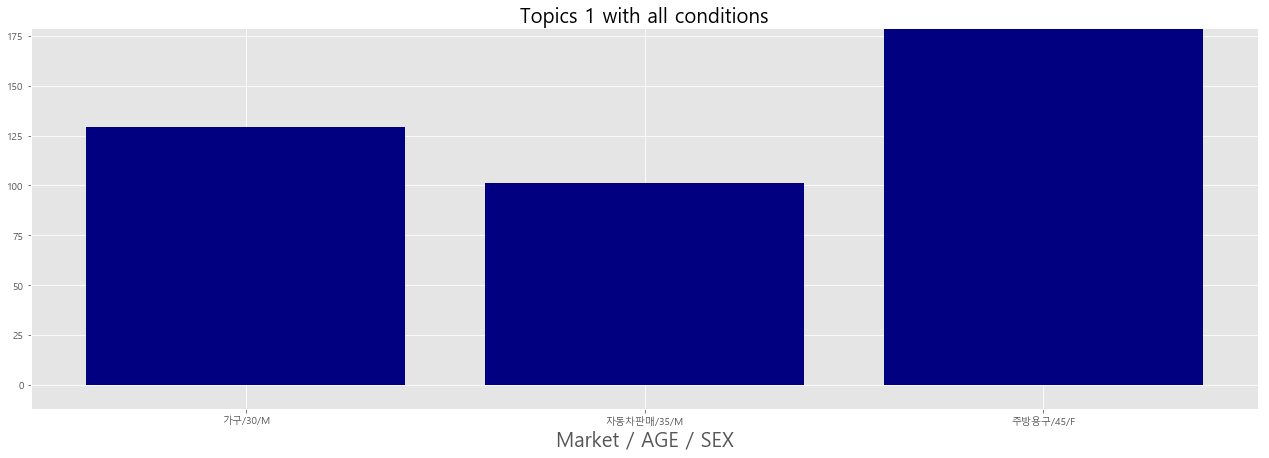

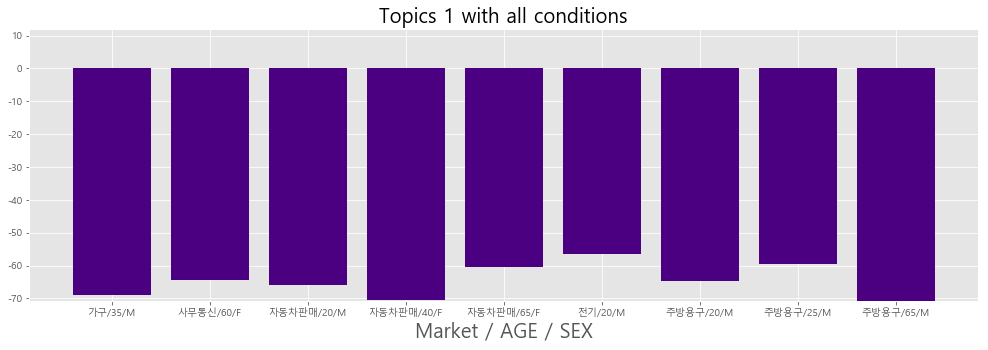

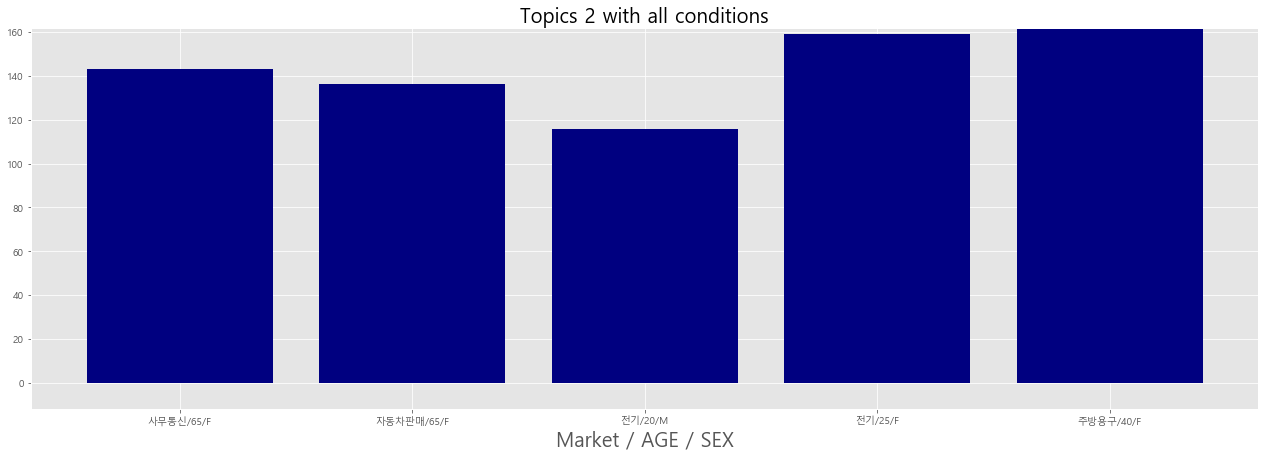

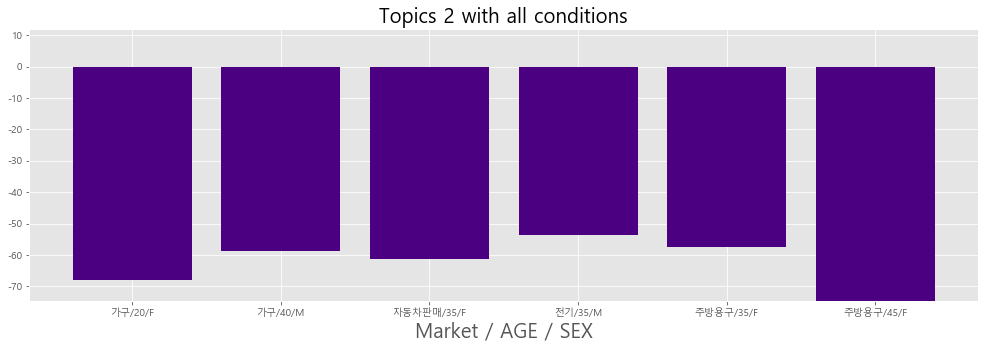

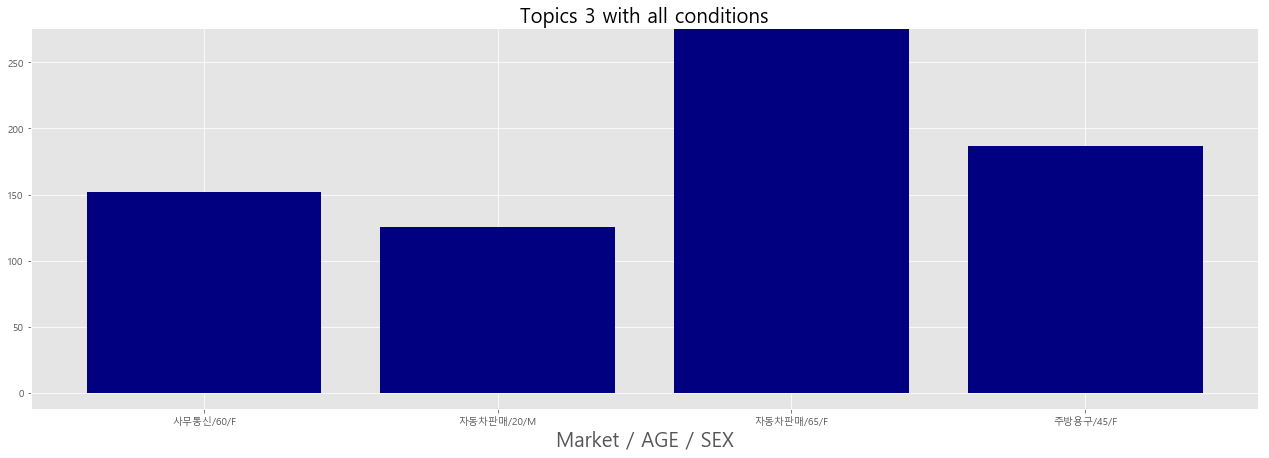

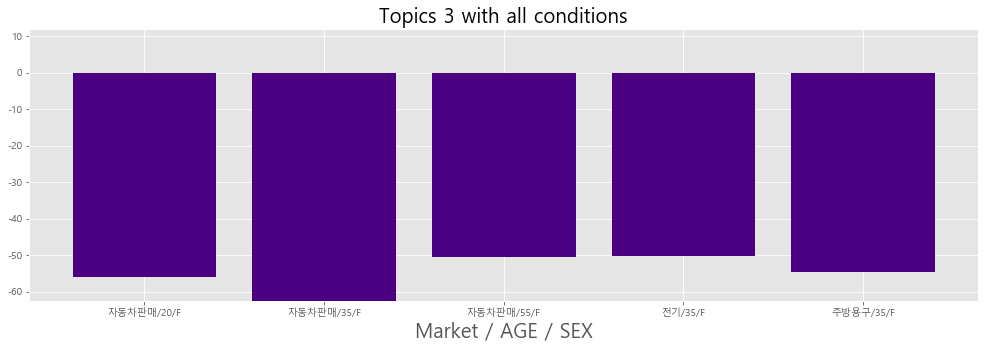

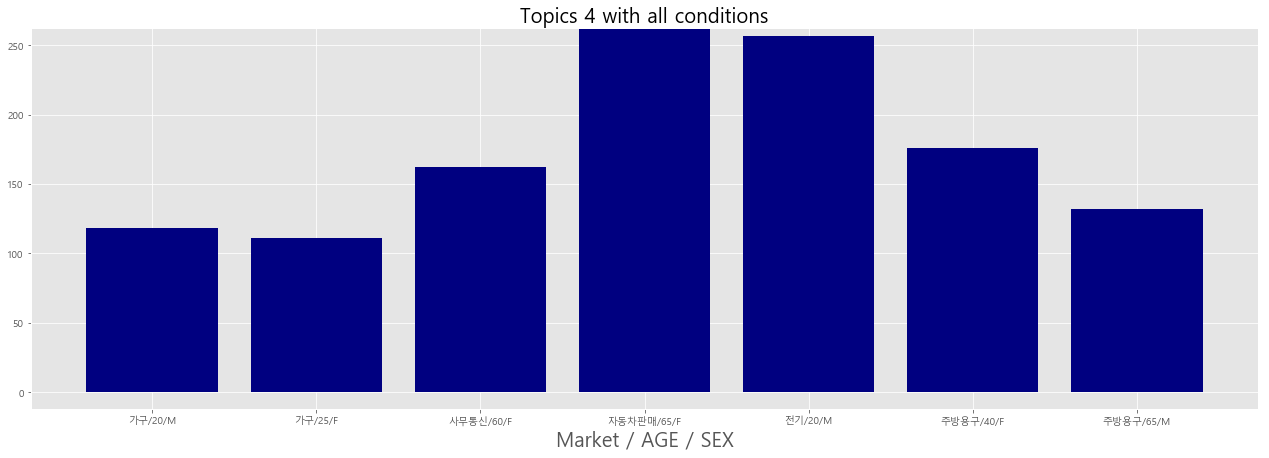

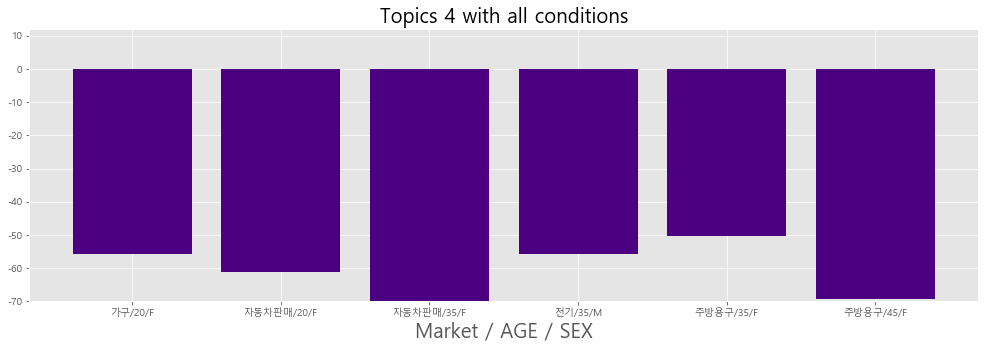

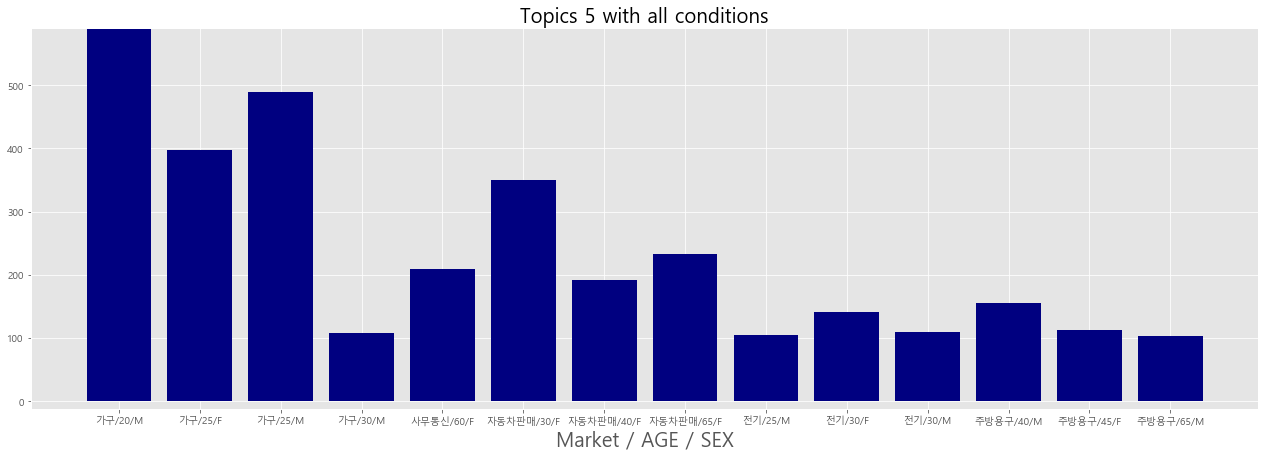

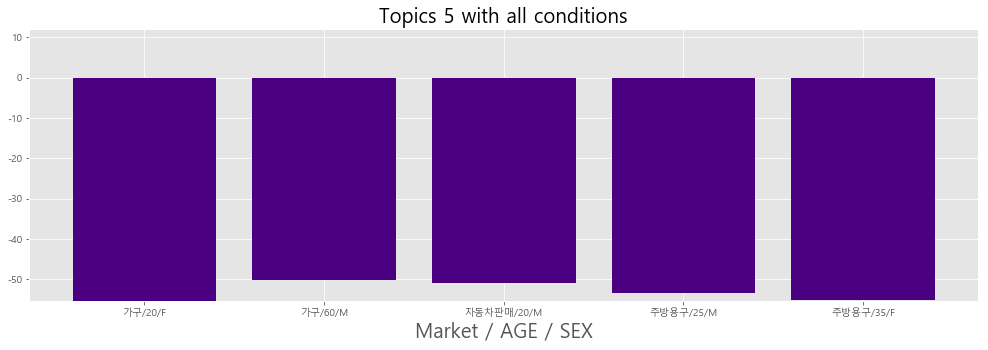

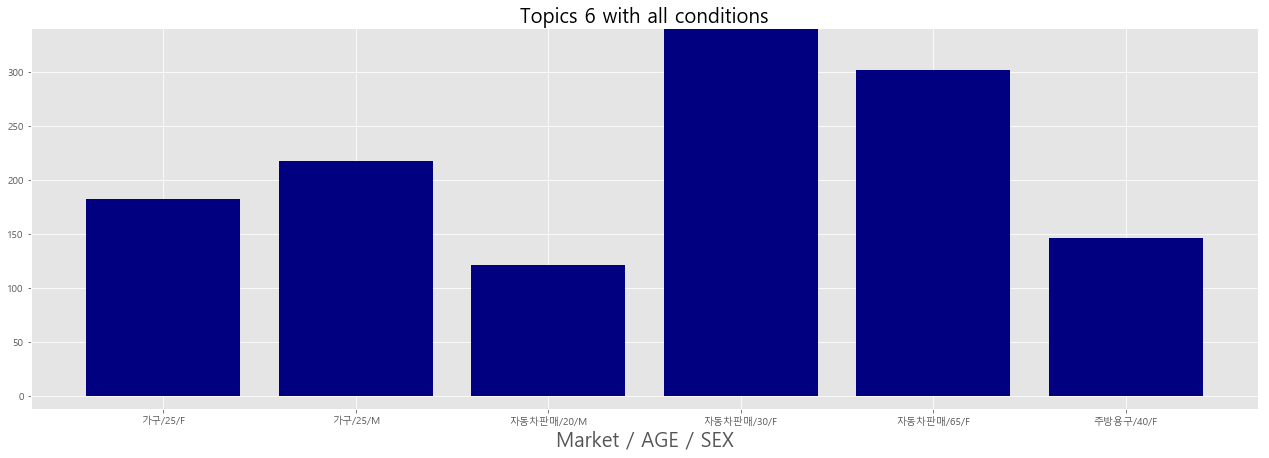

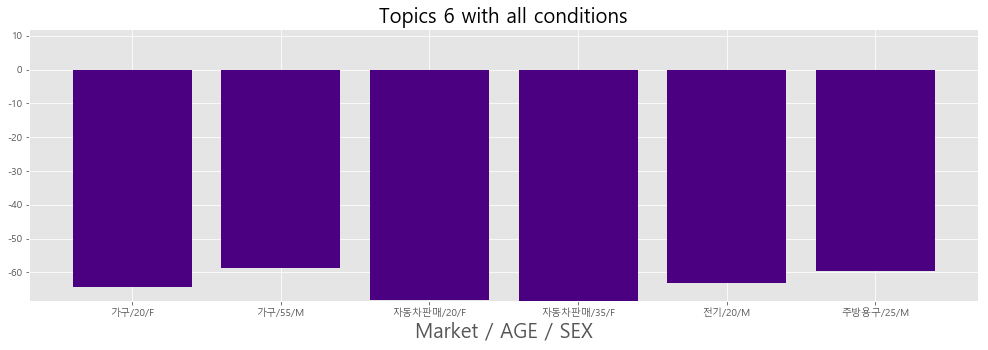

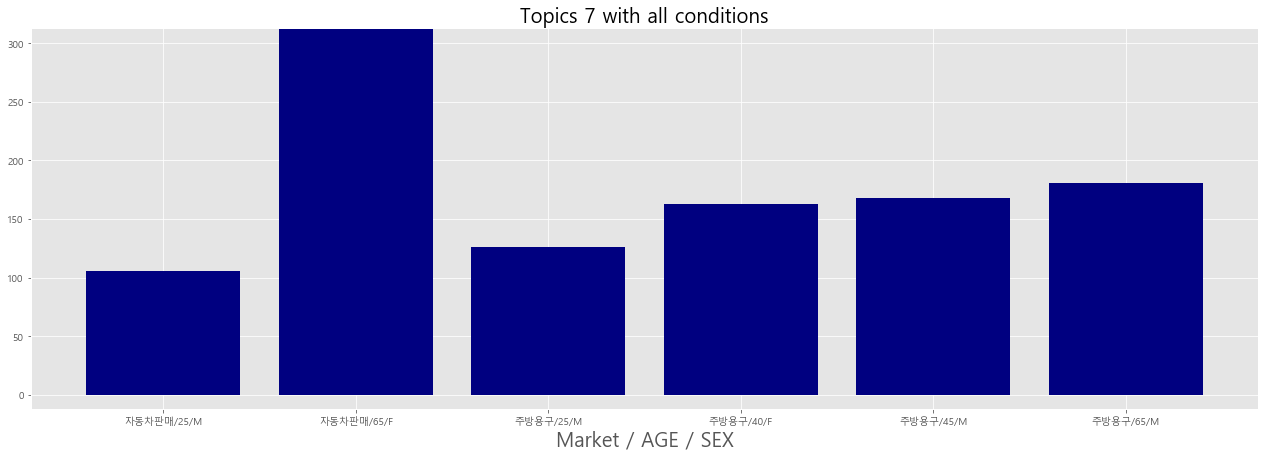

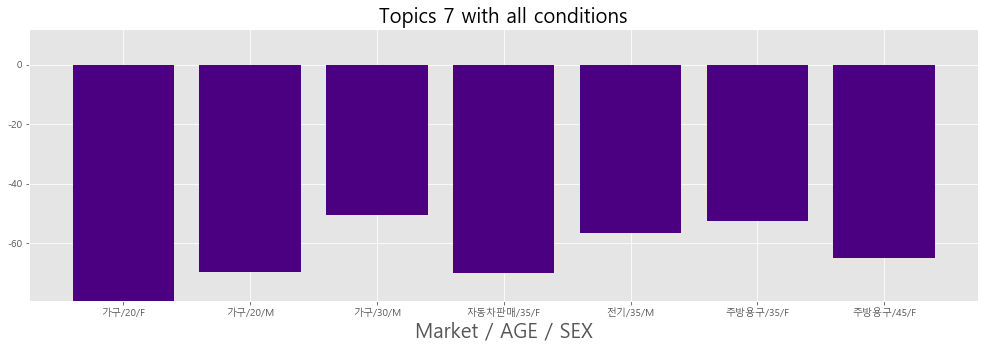

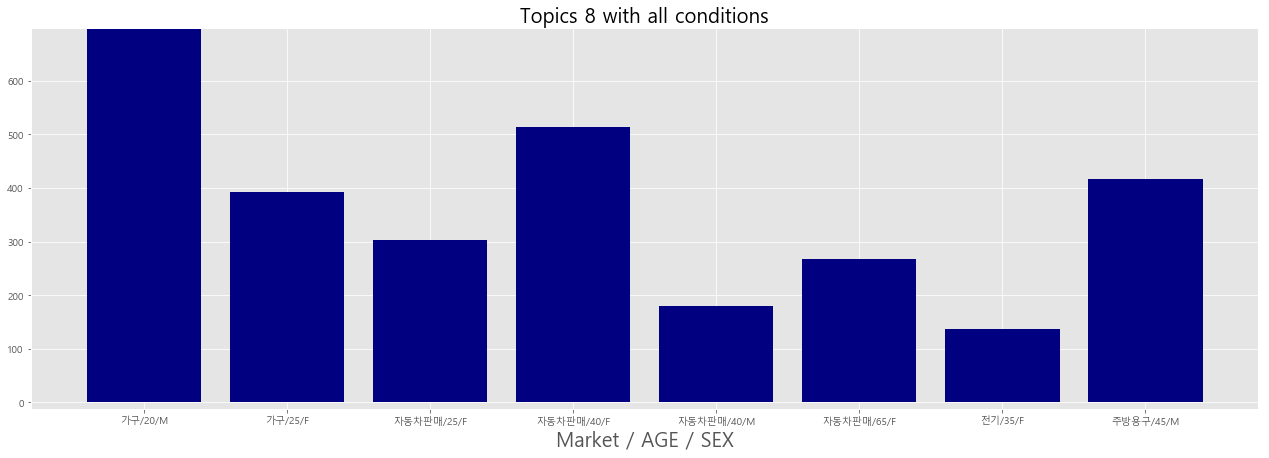

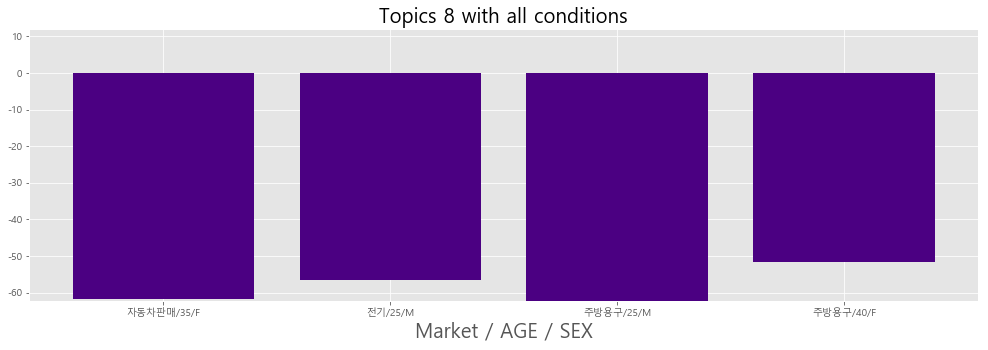

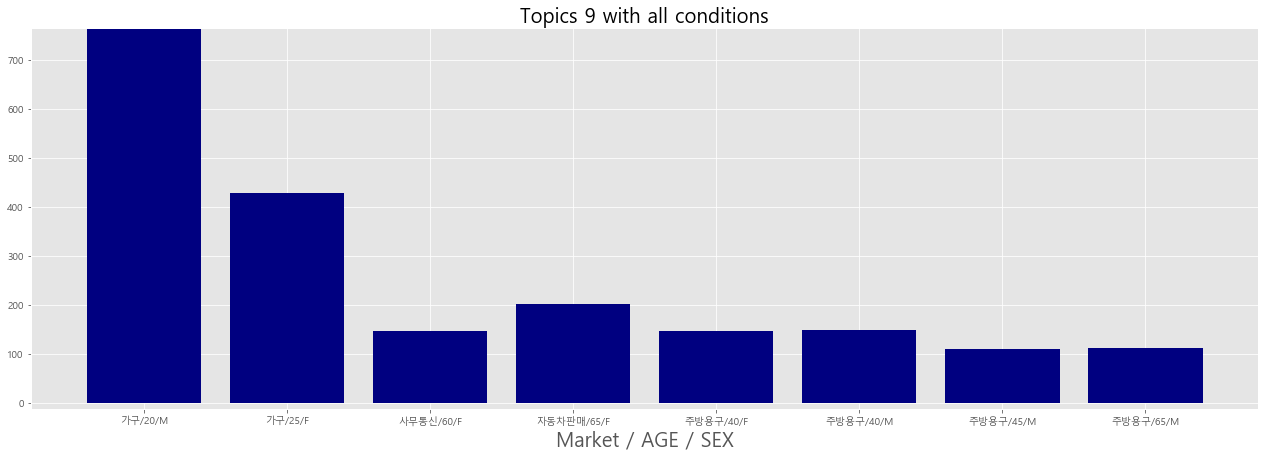

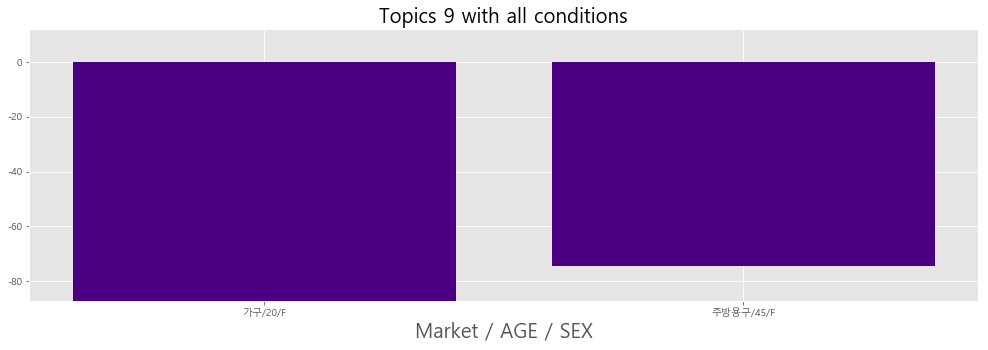

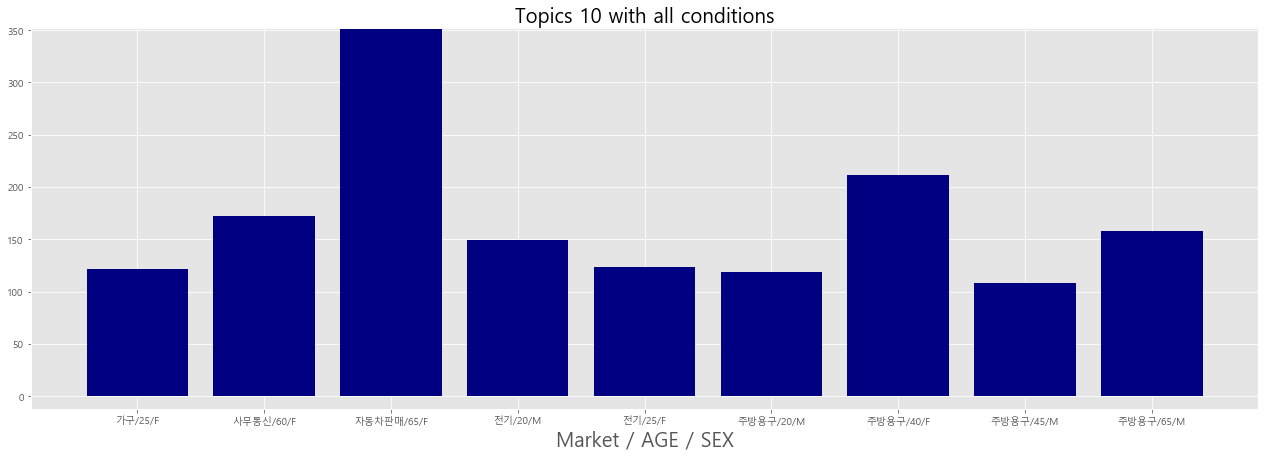

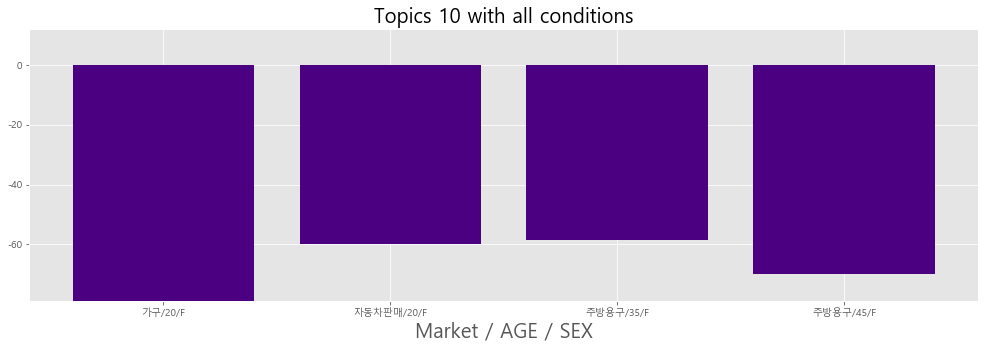

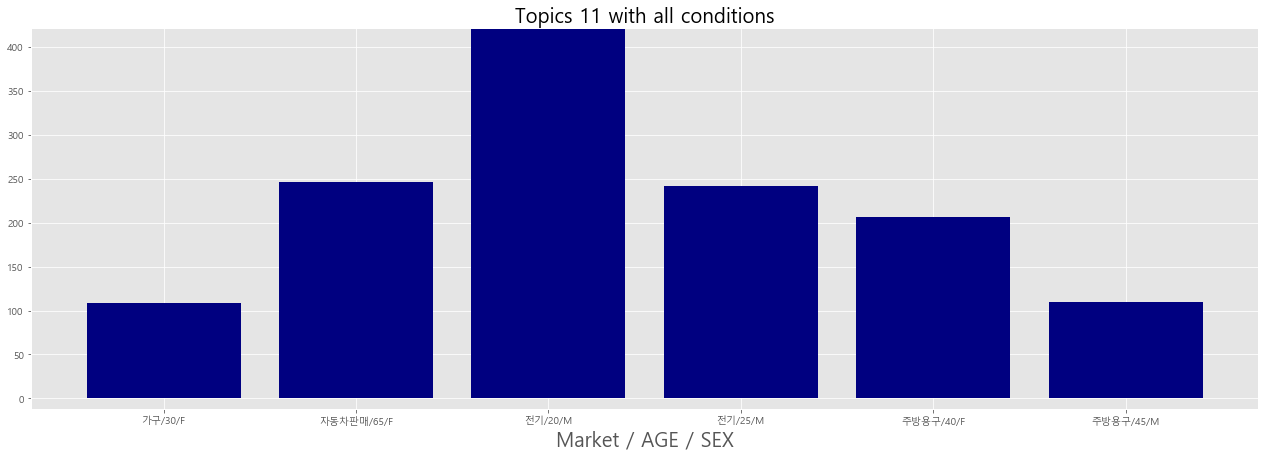

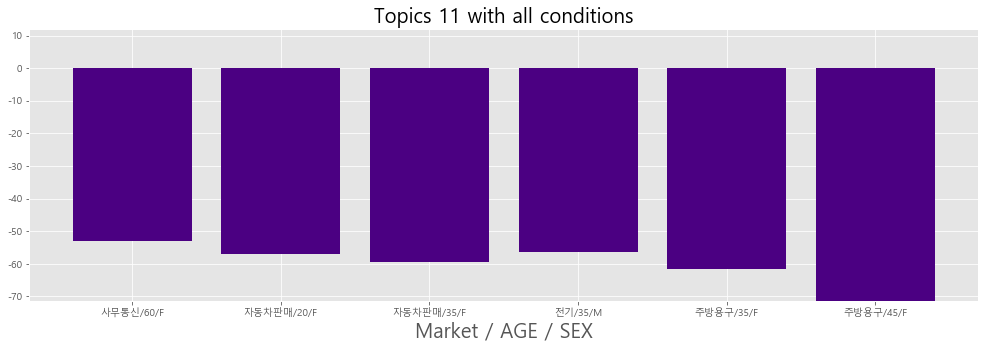

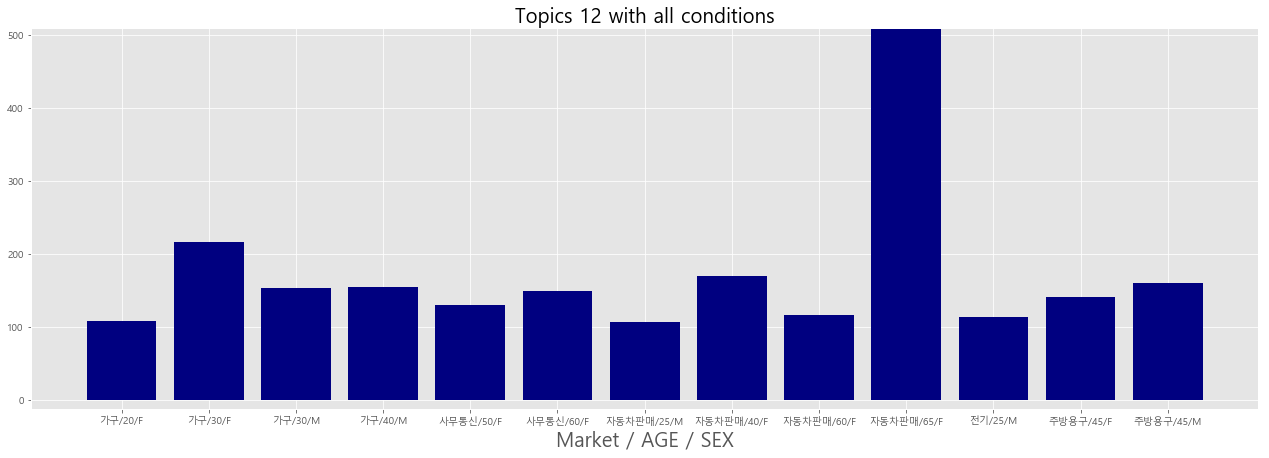

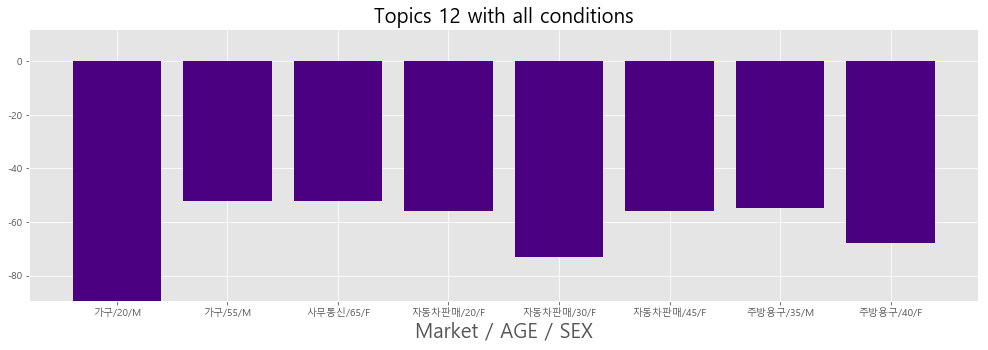

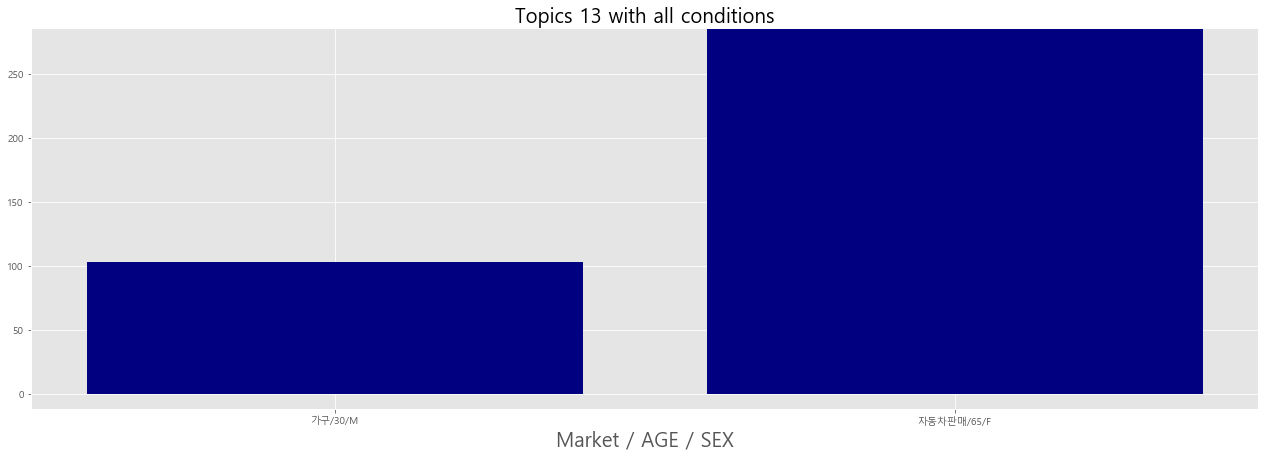

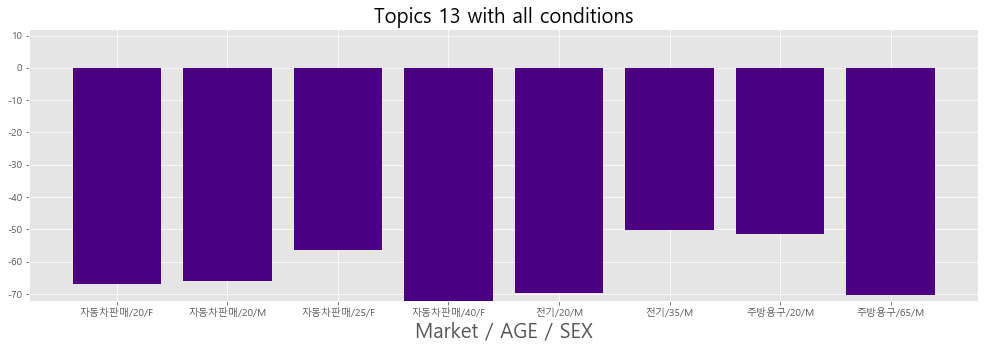

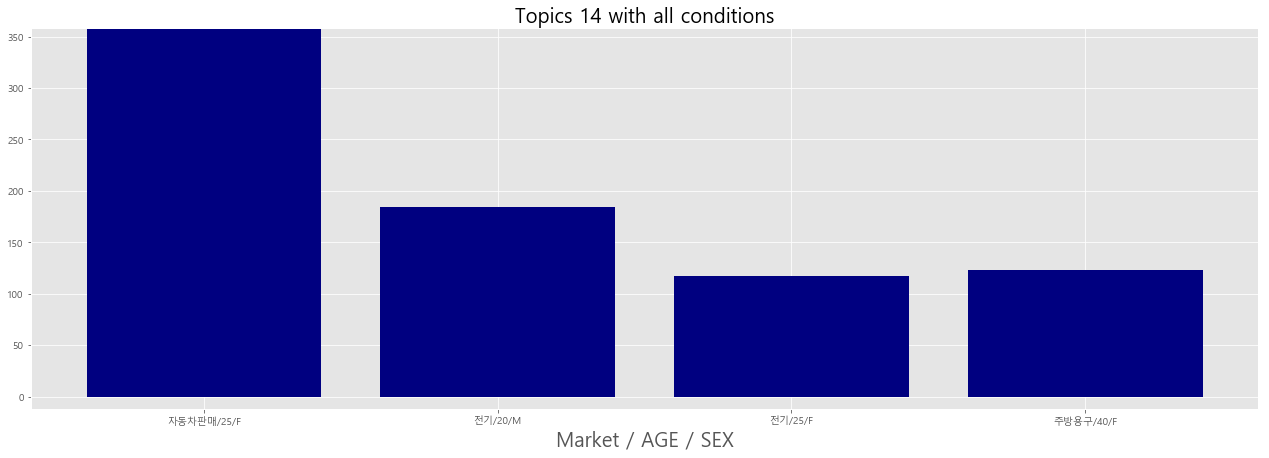

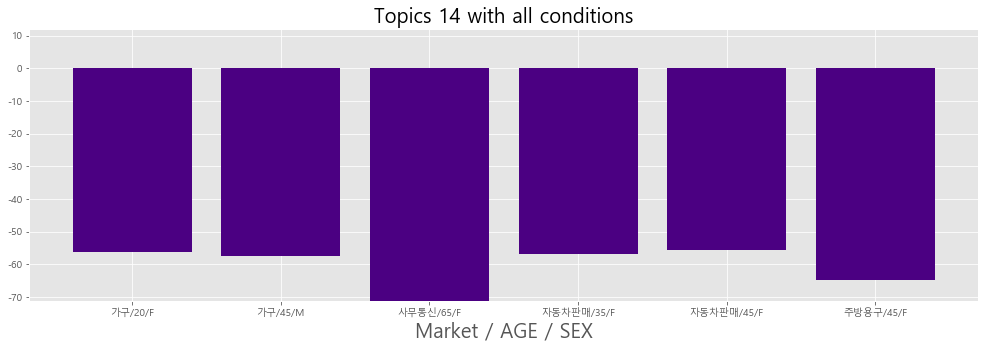

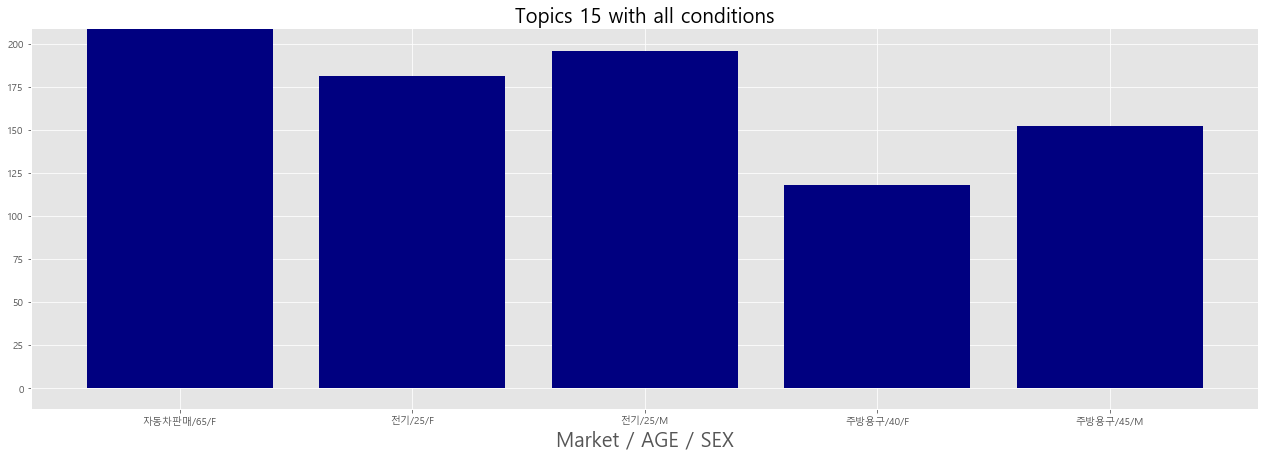

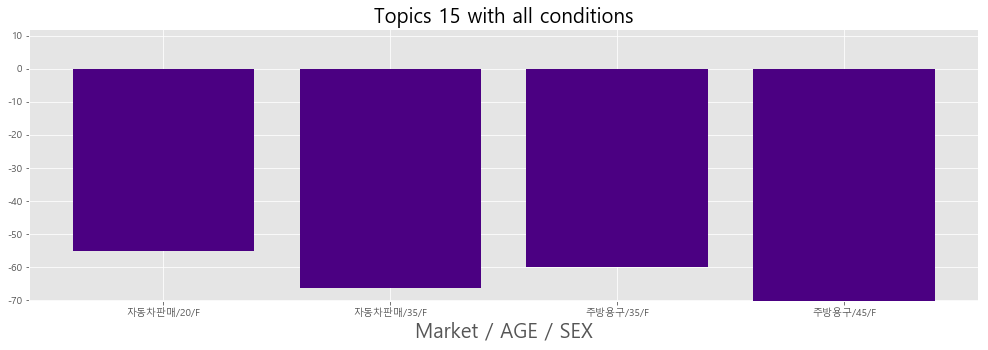

In [49]:
for i in range(15):
    plot_all(i)

In [50]:
m1 = incline_list[0]
for i in range(1,len(incline_list)) :
    m1 = np.vstack((m1,incline_list[i]))
m1 = np.vstack((m1, decline_list[0]))    
for i in range(1,len(decline_list)) :
    m1 = np.vstack((m1,decline_list[i]))

In [51]:
m2 = pd.DataFrame(data = m1)
#columns = ["market_name", "AGE_CD", "SEX_CD", "LEVER", "c1", "c2"] )

In [52]:
m2[3]

0       2.29344
1       2.01423
2       2.78736
3       2.42978
4       2.36338
5       2.15713
6       2.59205
7       2.61735
8       2.51598
9       2.25182
10      3.75756
11      2.86527
12      2.18249
13      2.10931
14      2.62291
15      3.62314
16      3.56954
17      2.76141
18      2.32205
19      6.89974
20      4.97508
21       5.8906
22      2.07848
23      3.09315
24      4.50041
25      2.91444
26      3.32205
27      2.04229
28      2.41132
29      2.09877
30      2.54645
31      2.12011
32      2.02779
33      2.81791
34       3.1774
35      2.20698
36      4.40014
37      4.01553
38       2.4649
39      2.05431
40      4.12745
41      2.26358
42      2.62987
43      2.67942
44      2.80546
45      7.97687
46      4.92709
47      4.02643
48        6.141
49      2.80244
50      3.67864
51      2.36461
52      5.16983
53      8.64134
54      5.28939
55      2.46875
56      3.01783
57      2.46021
58      2.47973
59      2.09177
60      2.11619
61      2.21322
62      

In [53]:
temp = m2[m2[0] == "레저용품"]

In [54]:
temp

,0,1,2,3,4,5


In [55]:
temp = m2[m2[0] == "자동차판매"]

In [56]:
temp

,0,1,2,3,4,5
1,자동차판매,35,M,2.01423,자동차판매/35/M,1/35/M
4,자동차판매,65,F,2.36338,자동차판매/65/F,2/65/F
9,자동차판매,20,M,2.25182,자동차판매/20/M,3/20/M
10,자동차판매,65,F,3.75756,자동차판매/65/F,3/65/F
15,자동차판매,65,F,3.62314,자동차판매/65/F,4/65/F
24,자동차판매,30,F,4.50041,자동차판매/30/F,5/30/F
25,자동차판매,40,F,2.91444,자동차판매/40/F,5/40/F
26,자동차판매,65,F,3.32205,자동차판매/65/F,5/65/F
35,자동차판매,20,M,2.20698,자동차판매/20/M,6/20/M
36,자동차판매,30,F,4.40014,자동차판매/30/F,6/30/F


In [57]:
m2[3] = m2[3].map(lambda x : (x-1)*100)

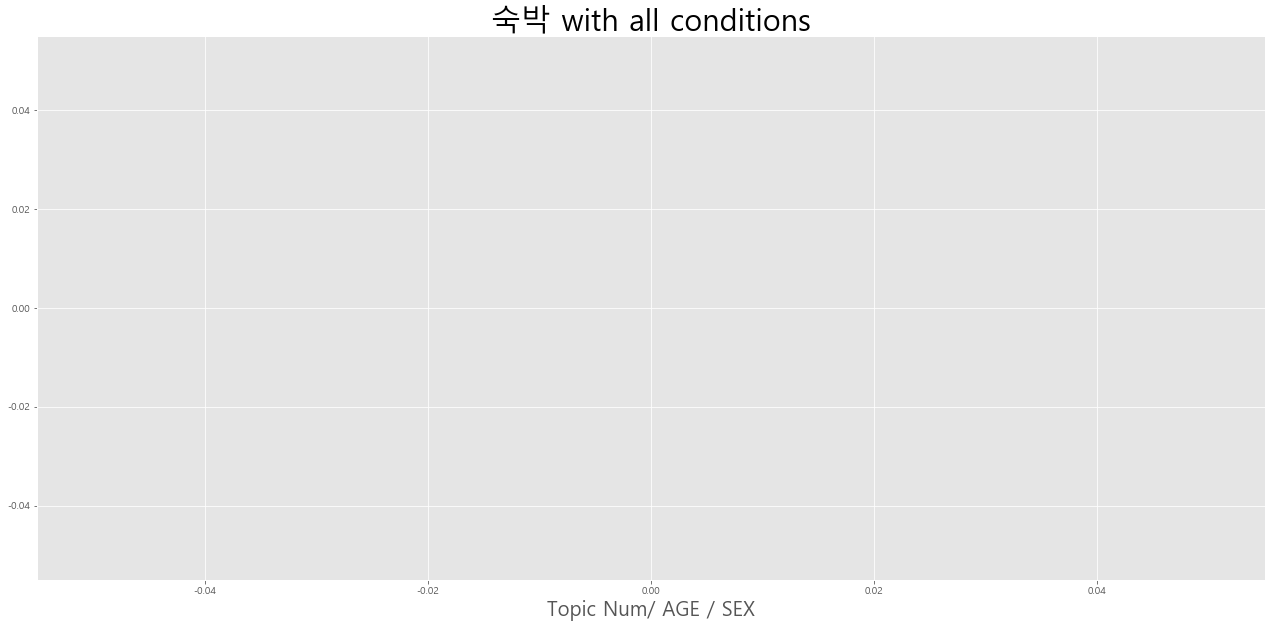

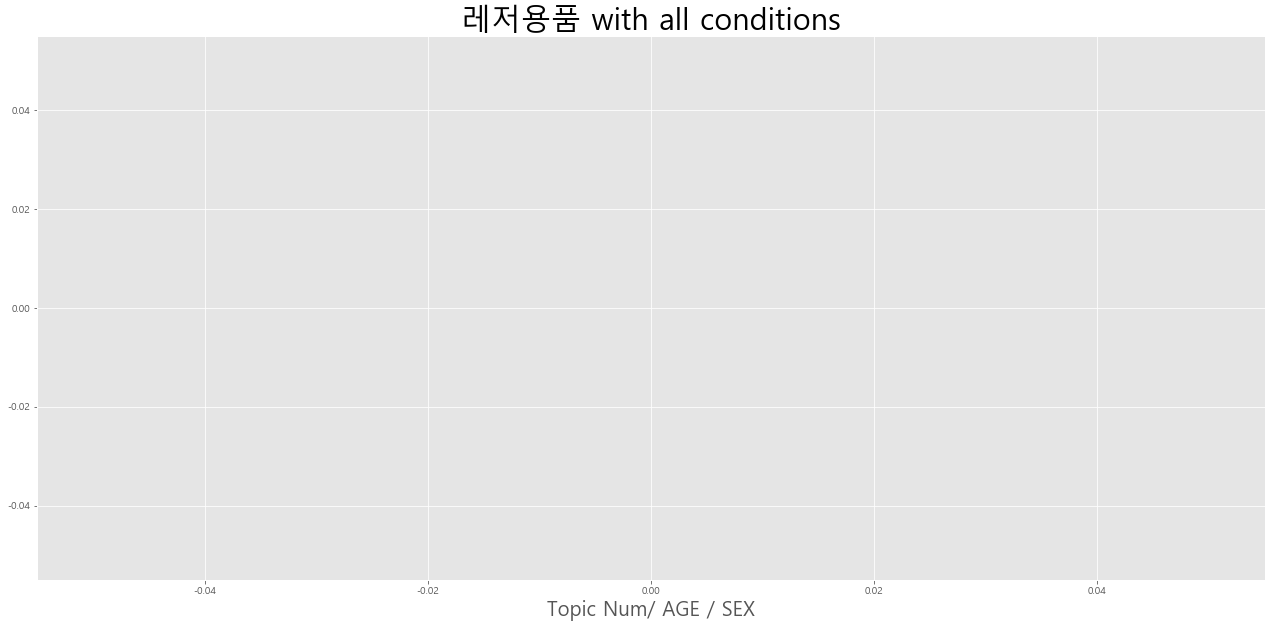

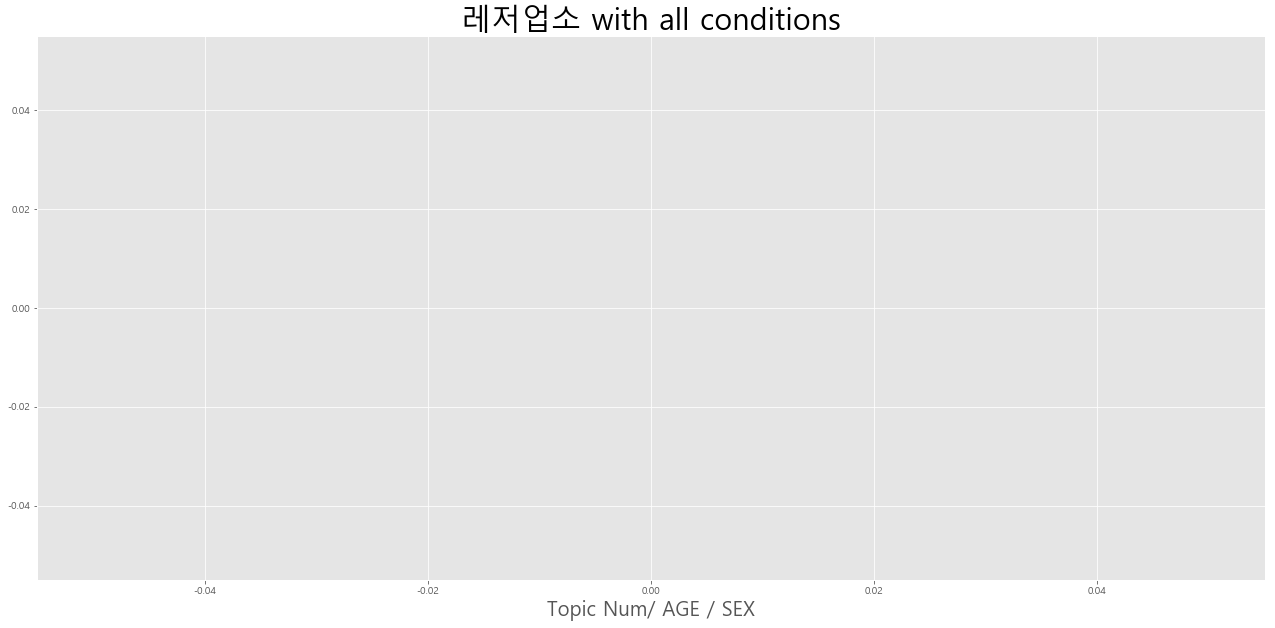

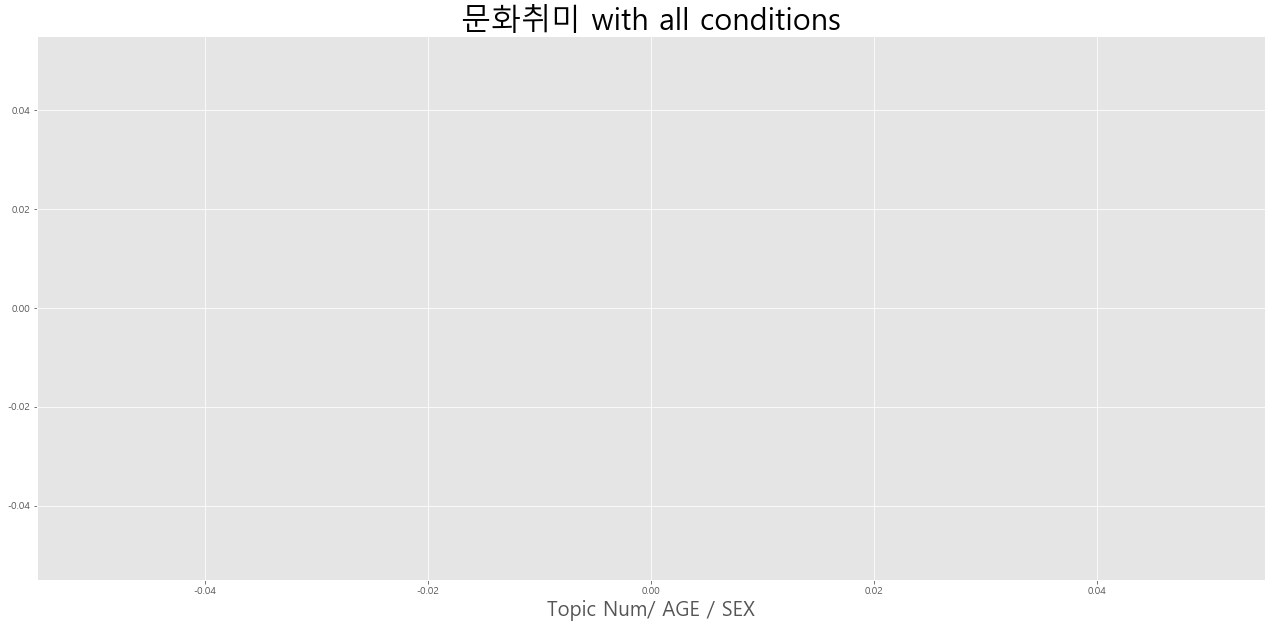

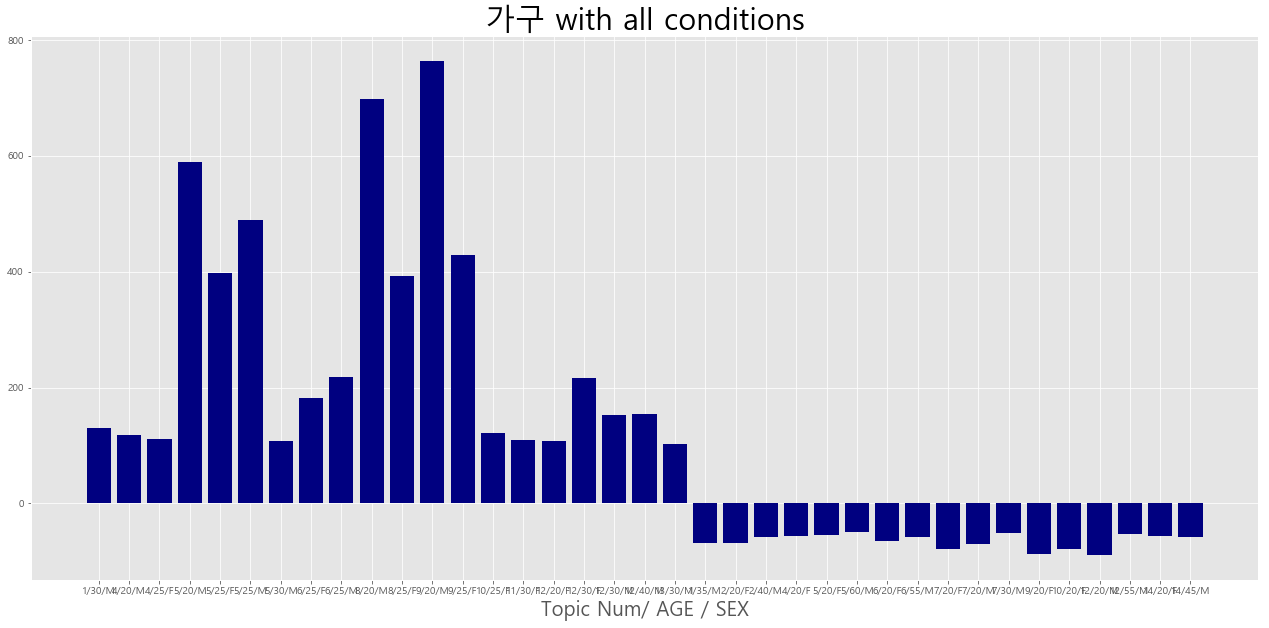

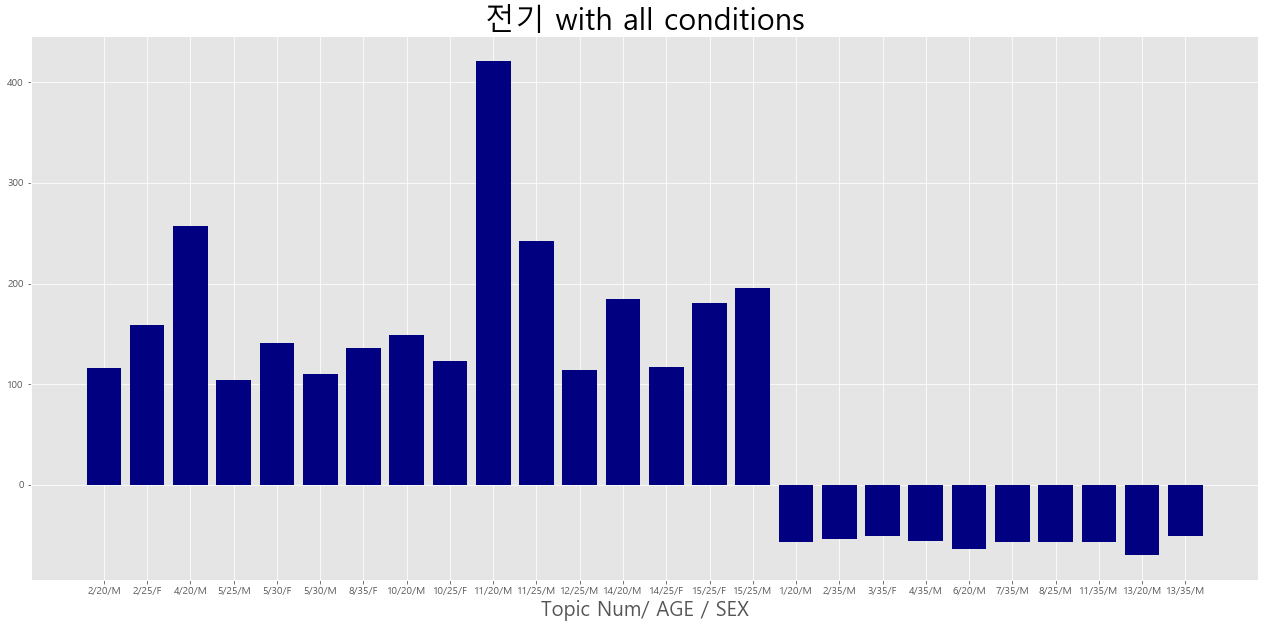

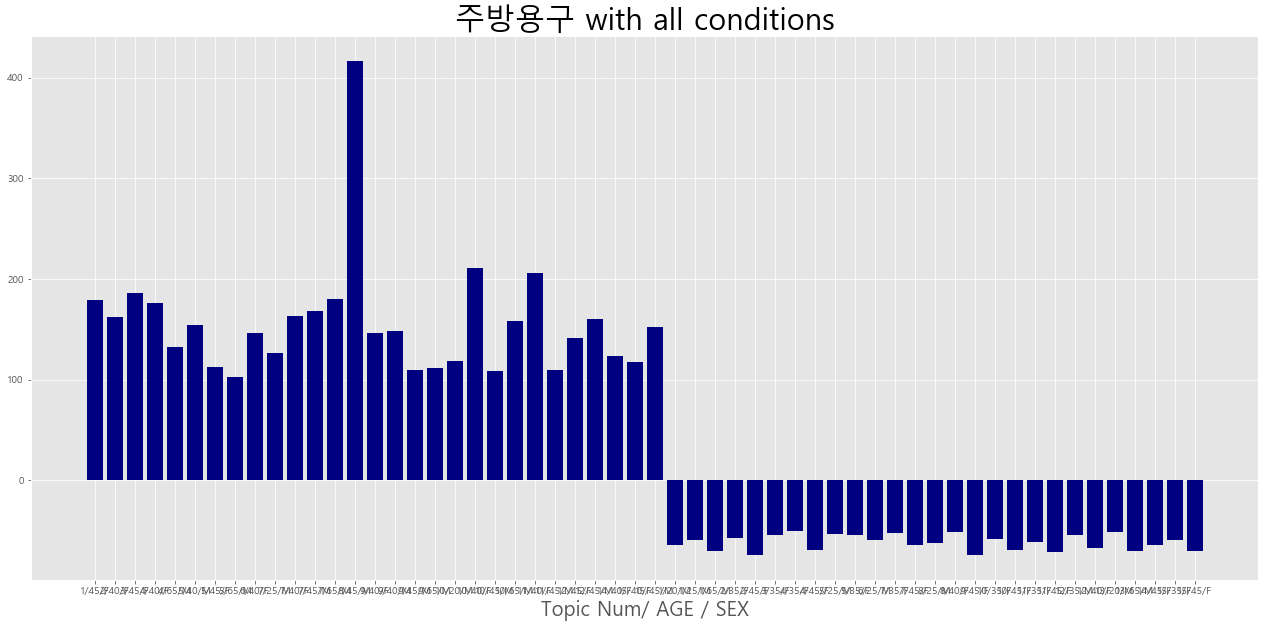

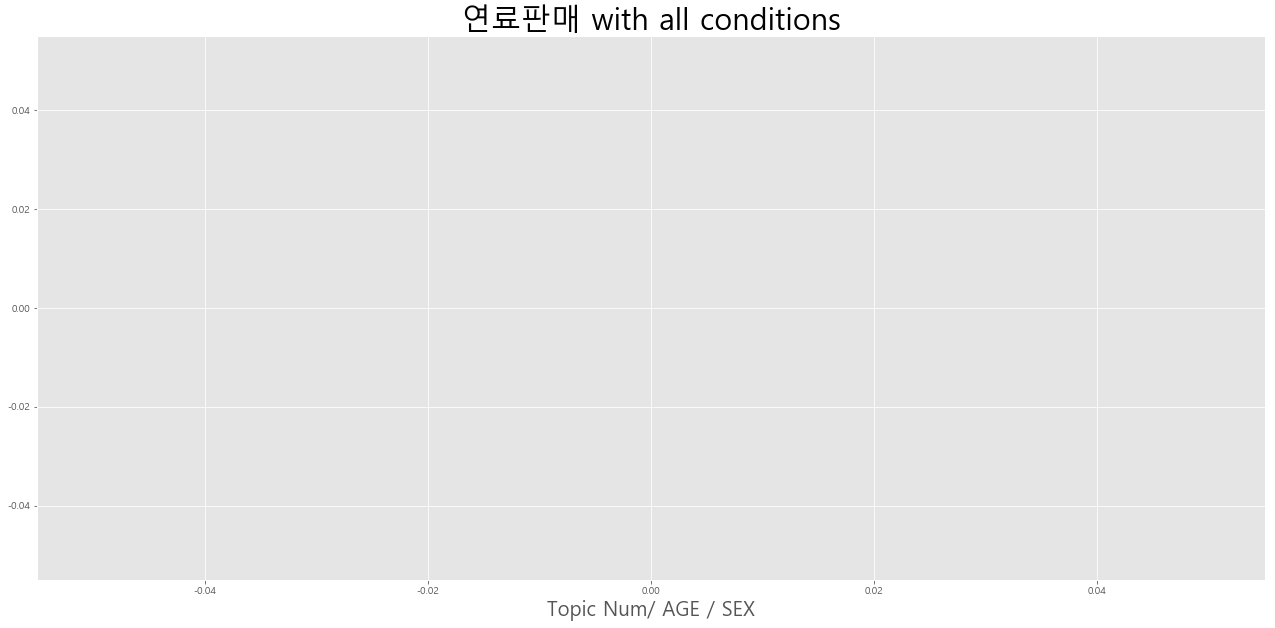

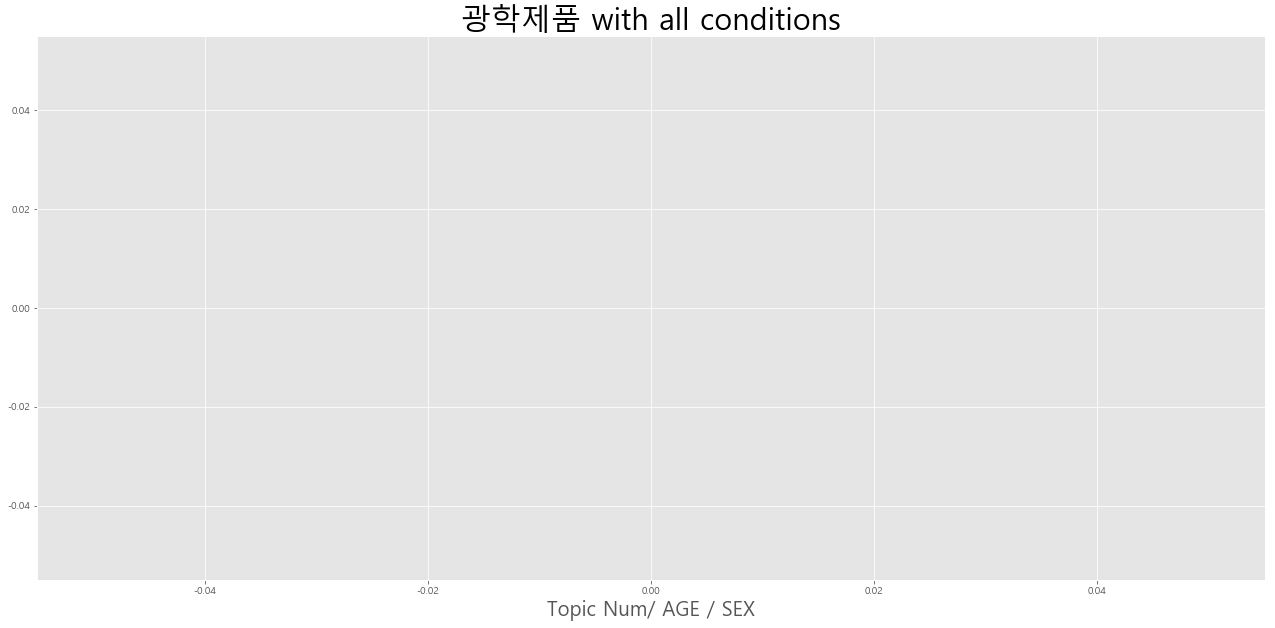

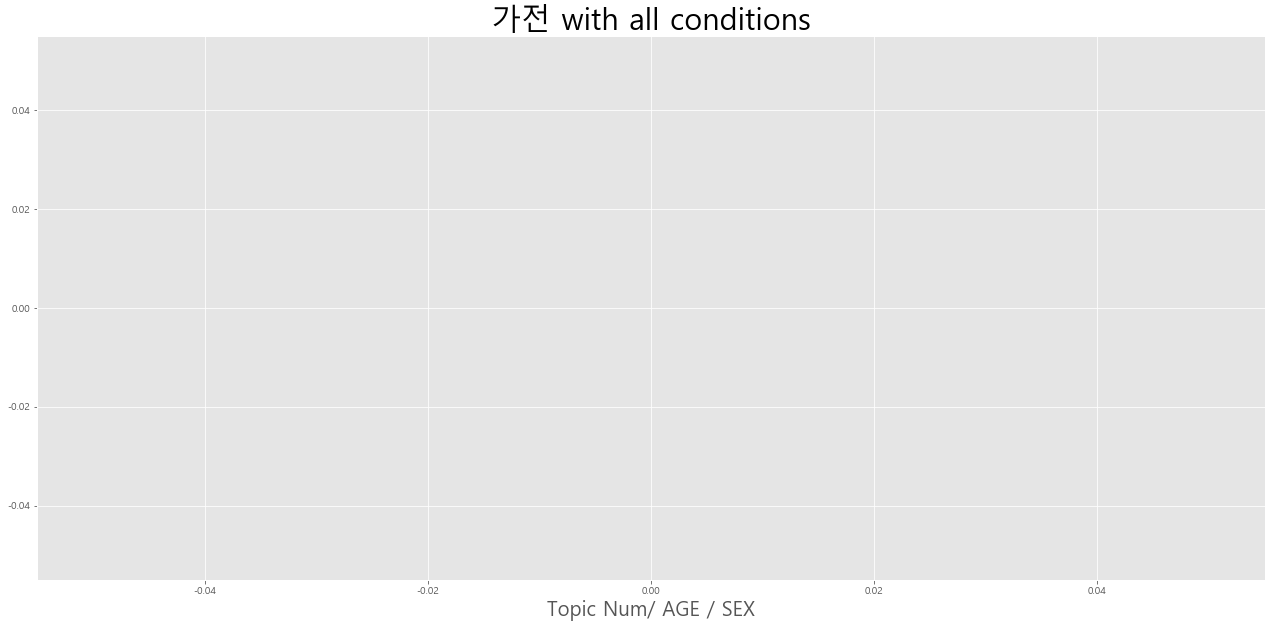

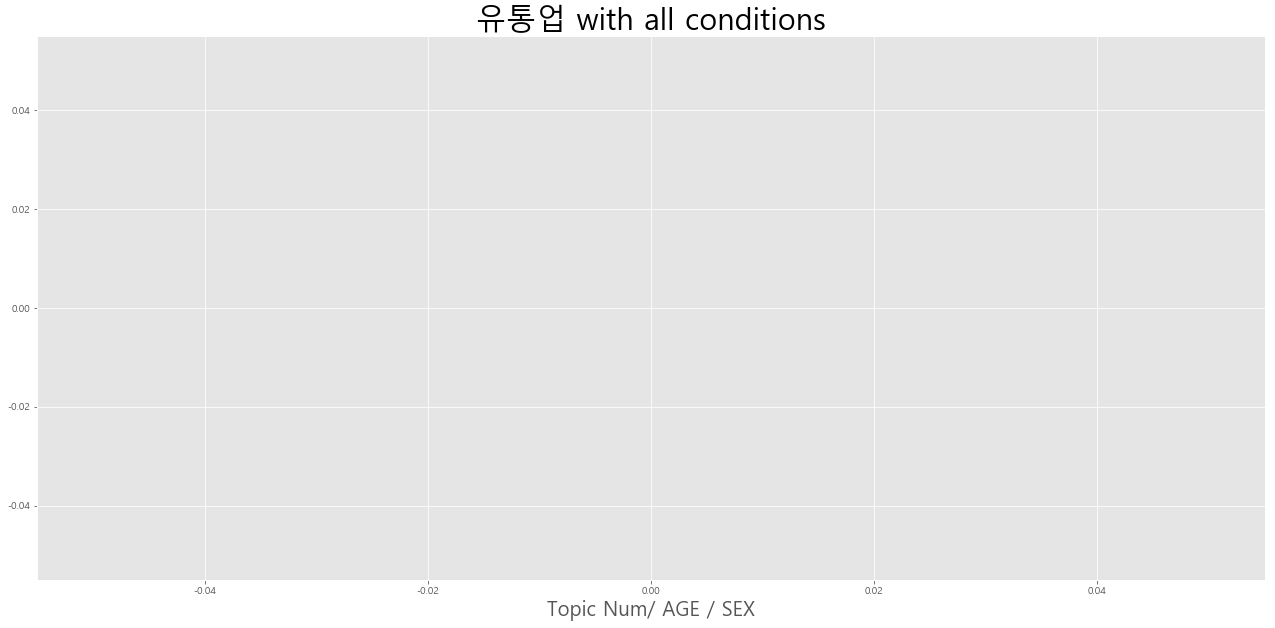

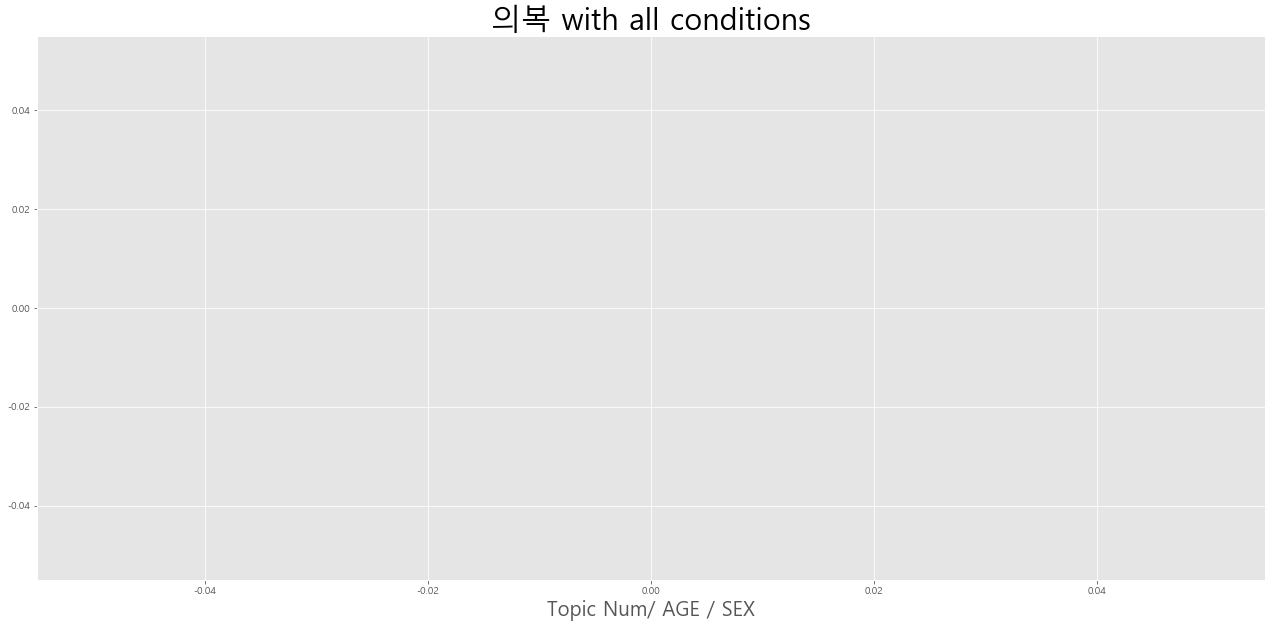

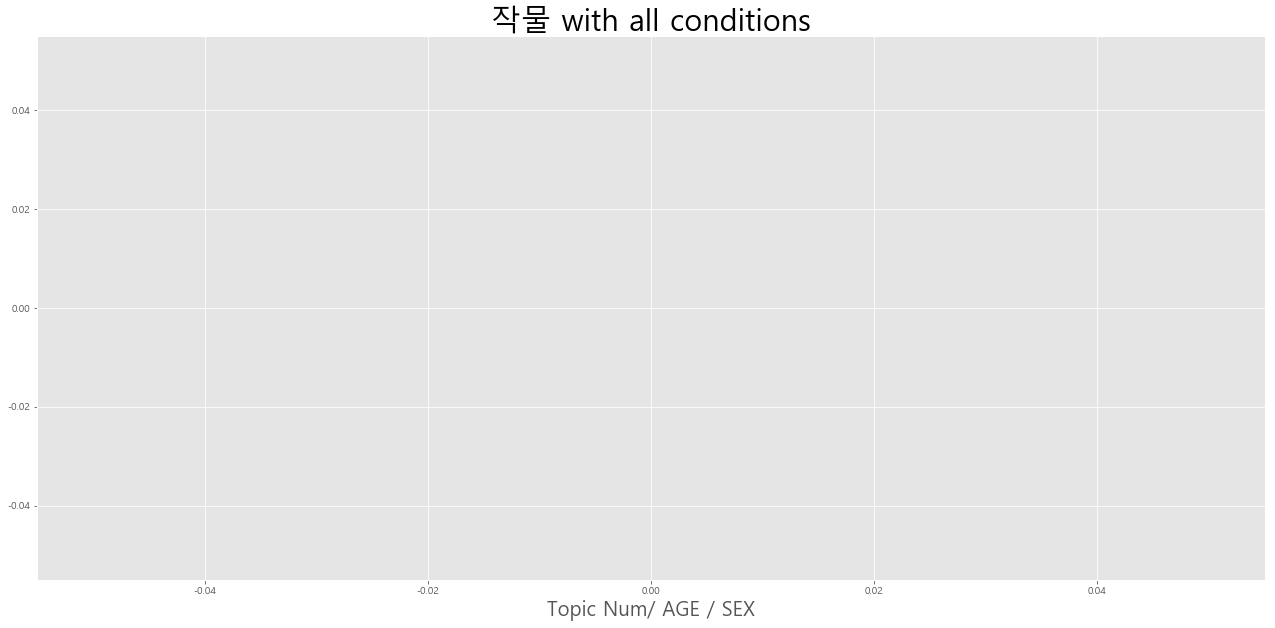

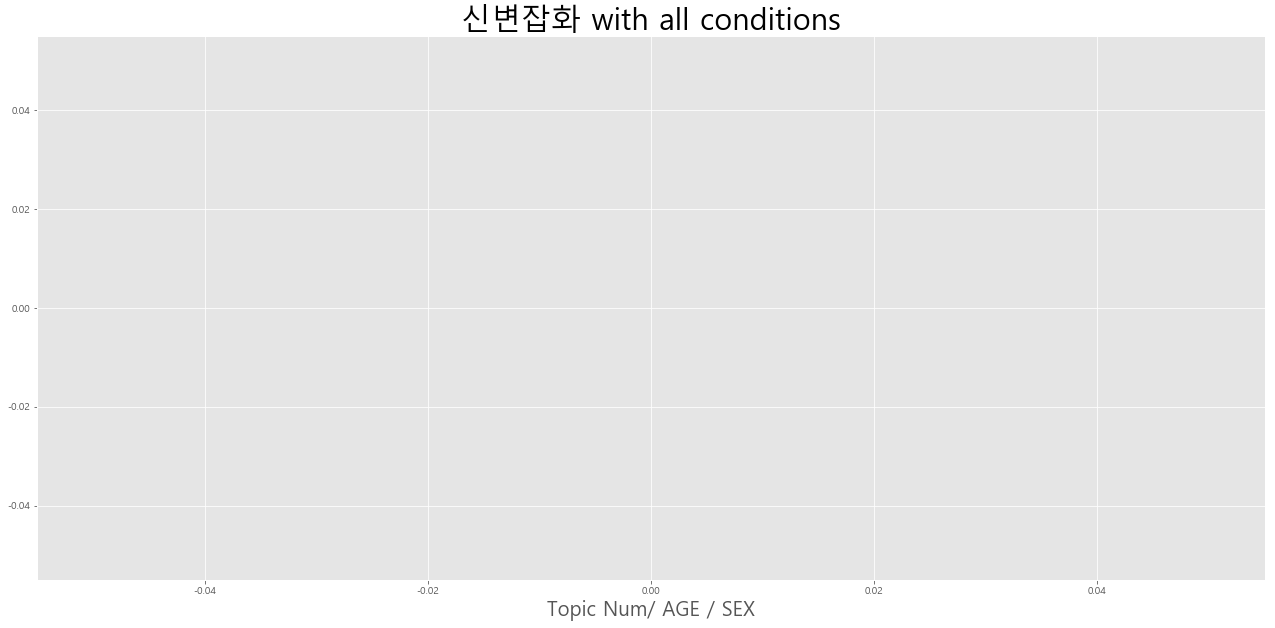

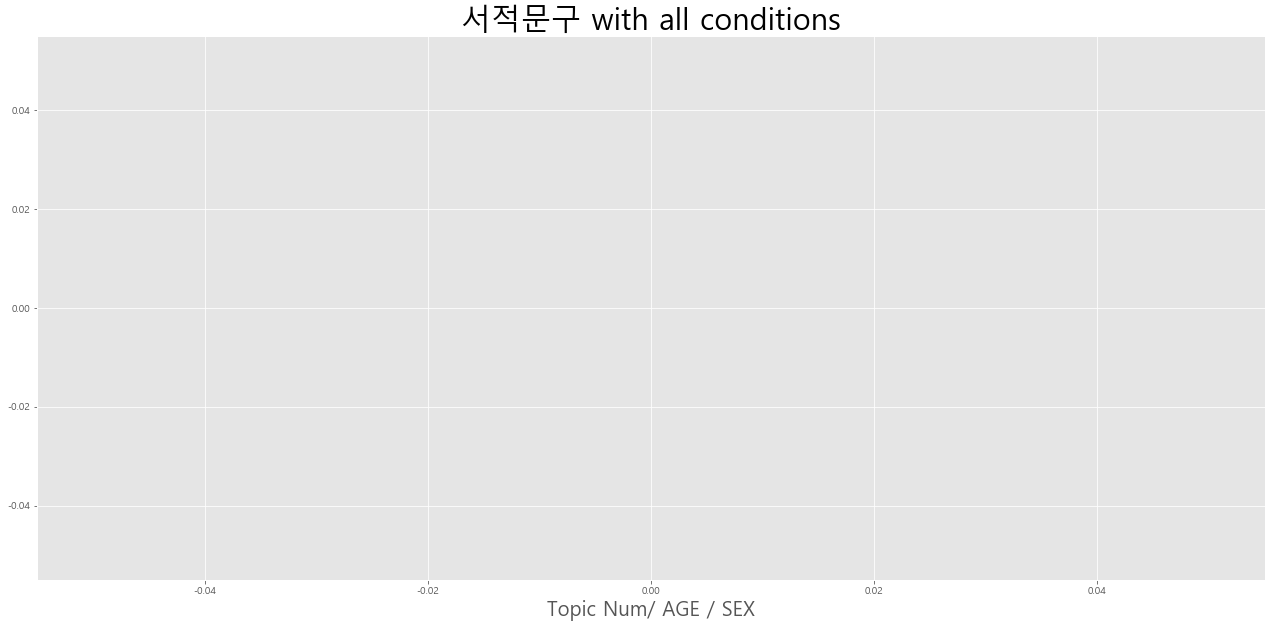

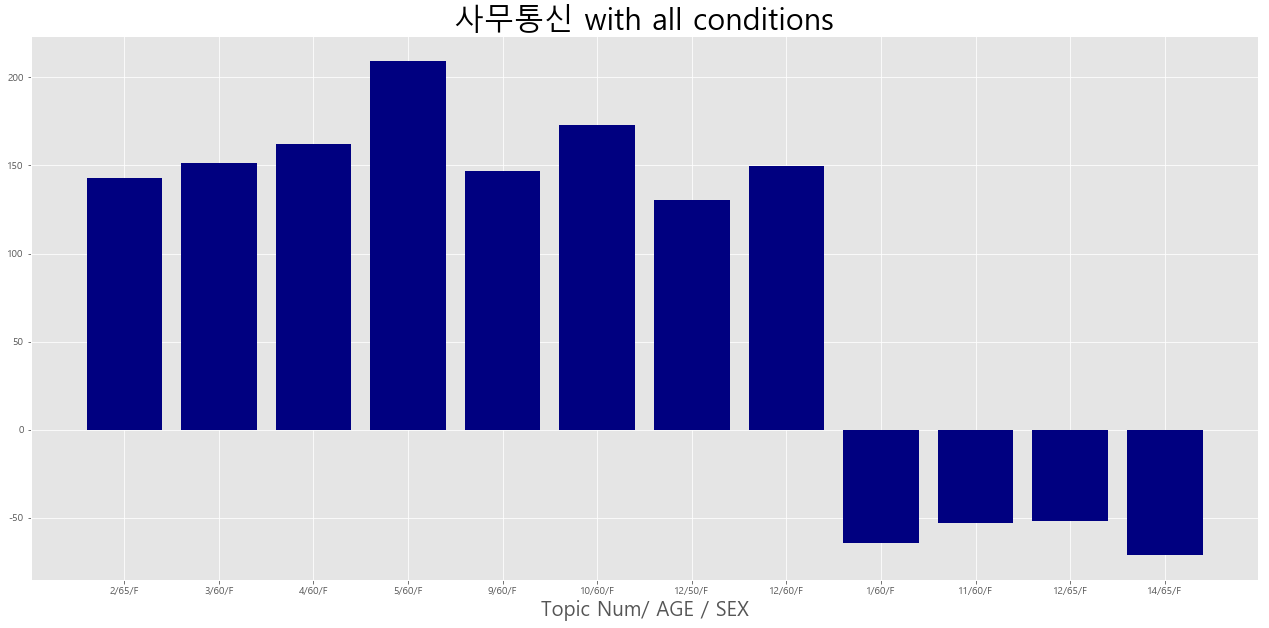

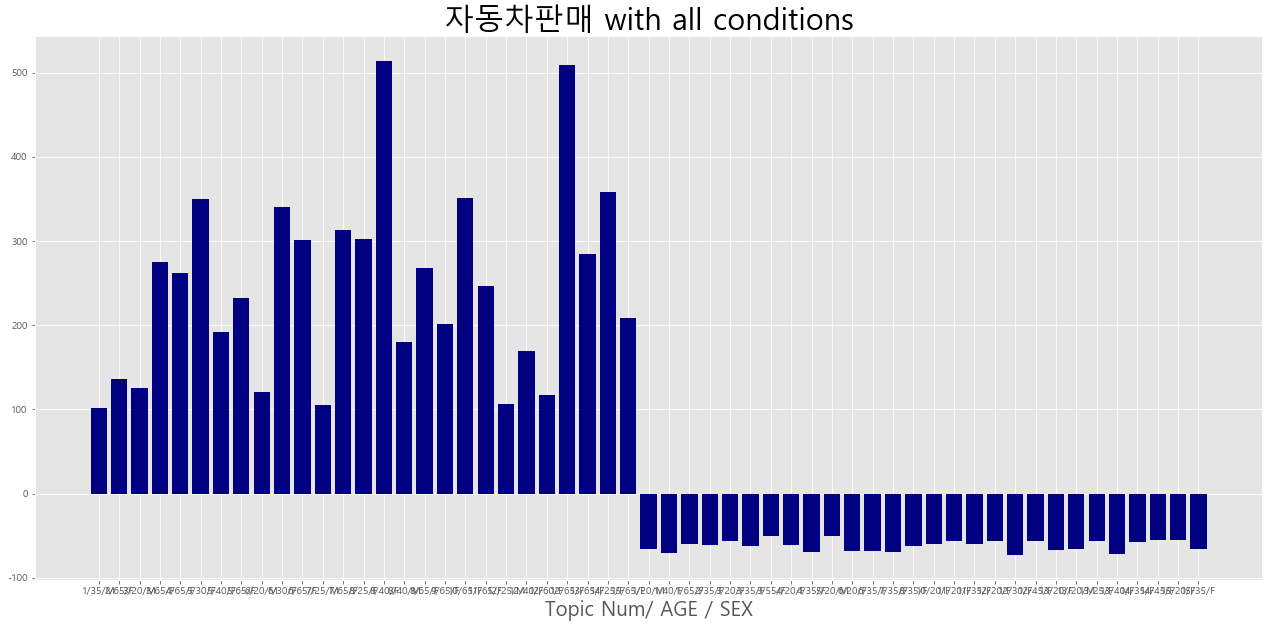

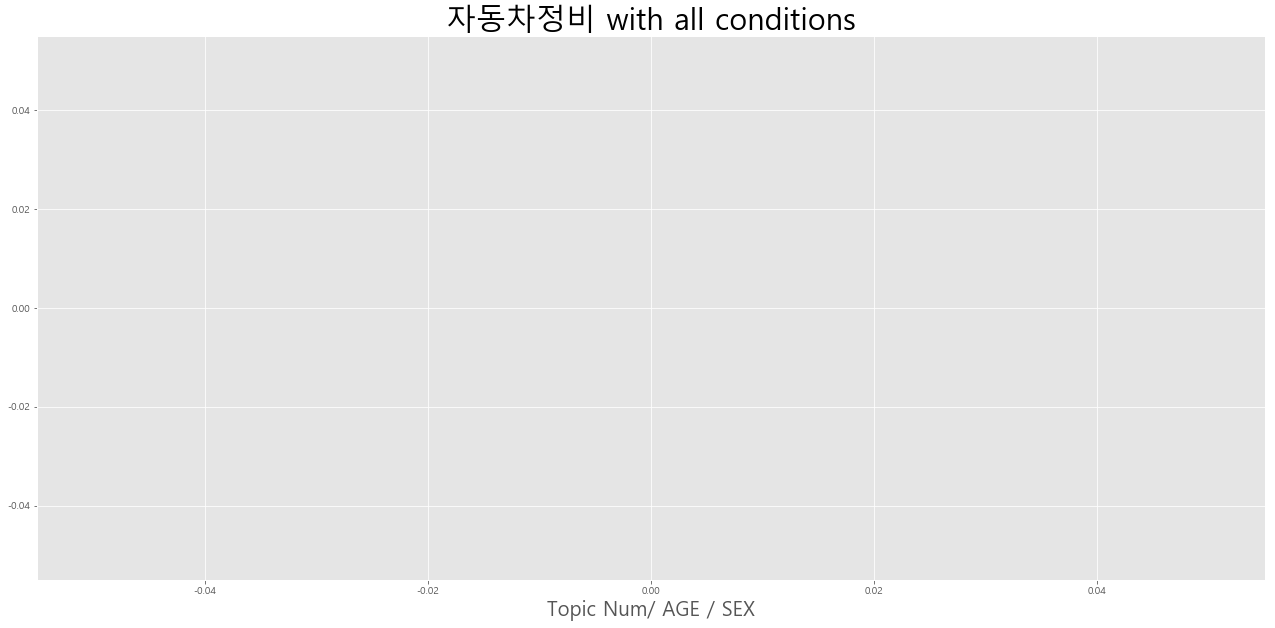

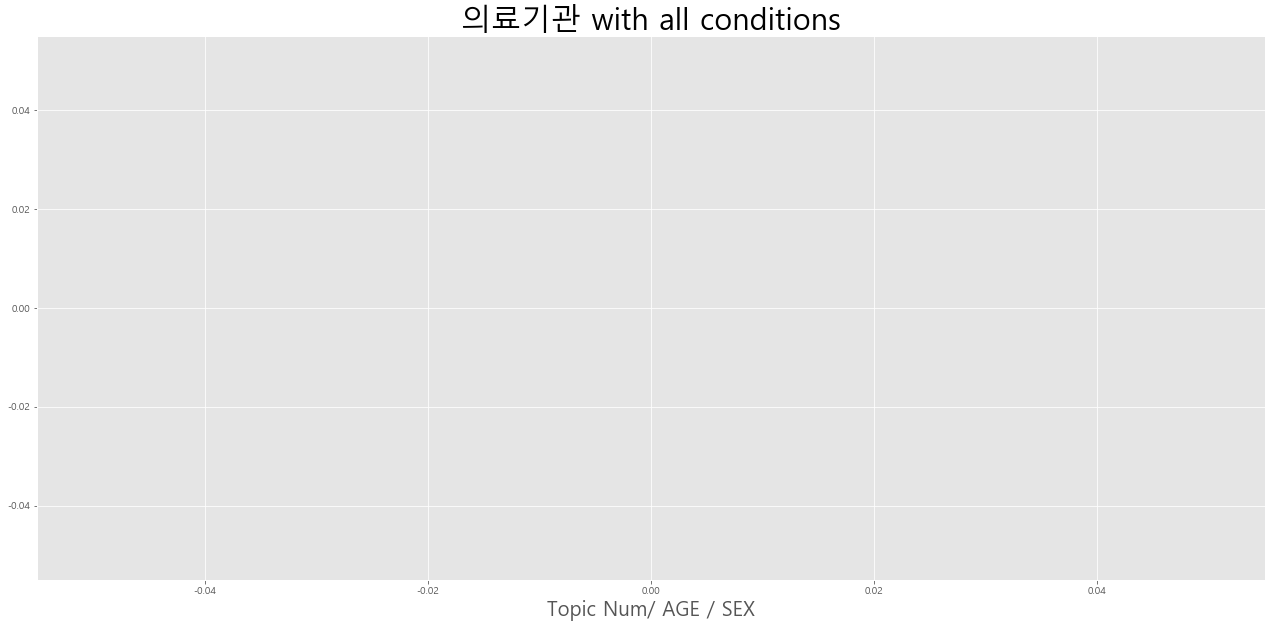

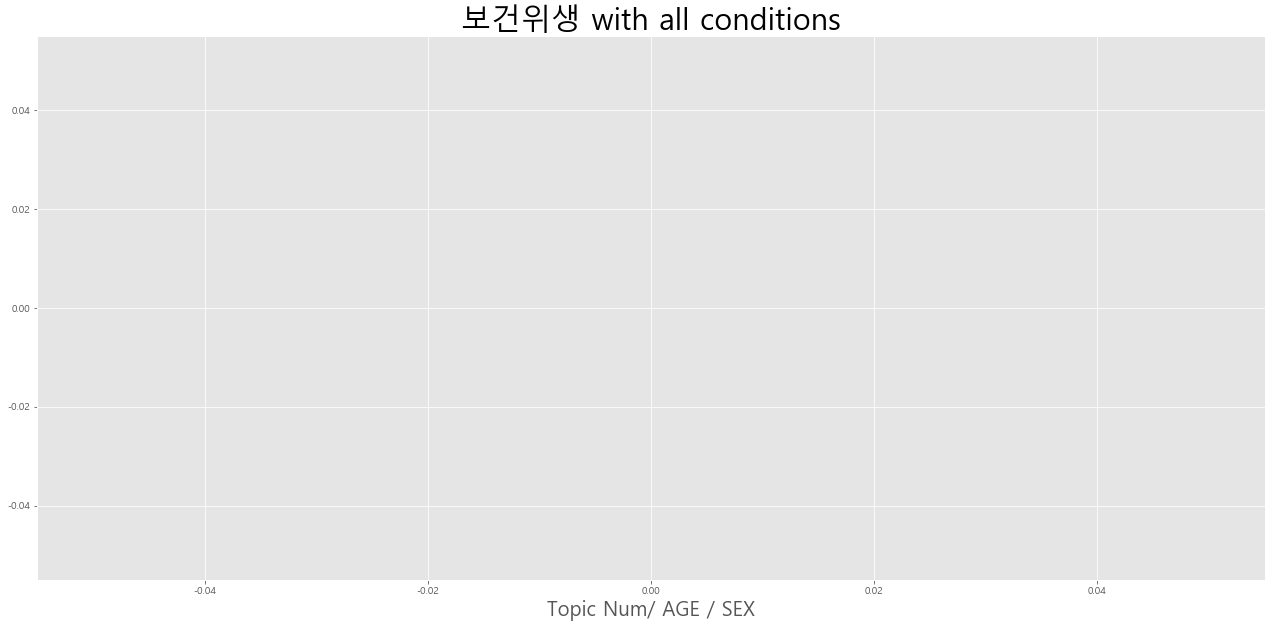

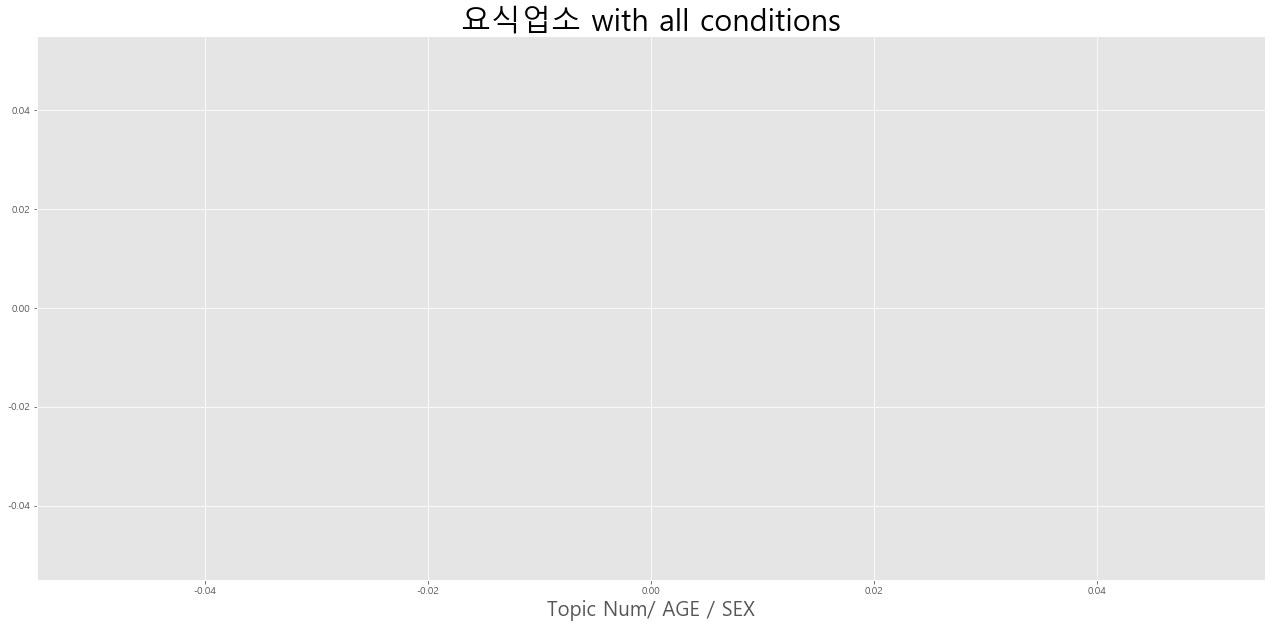

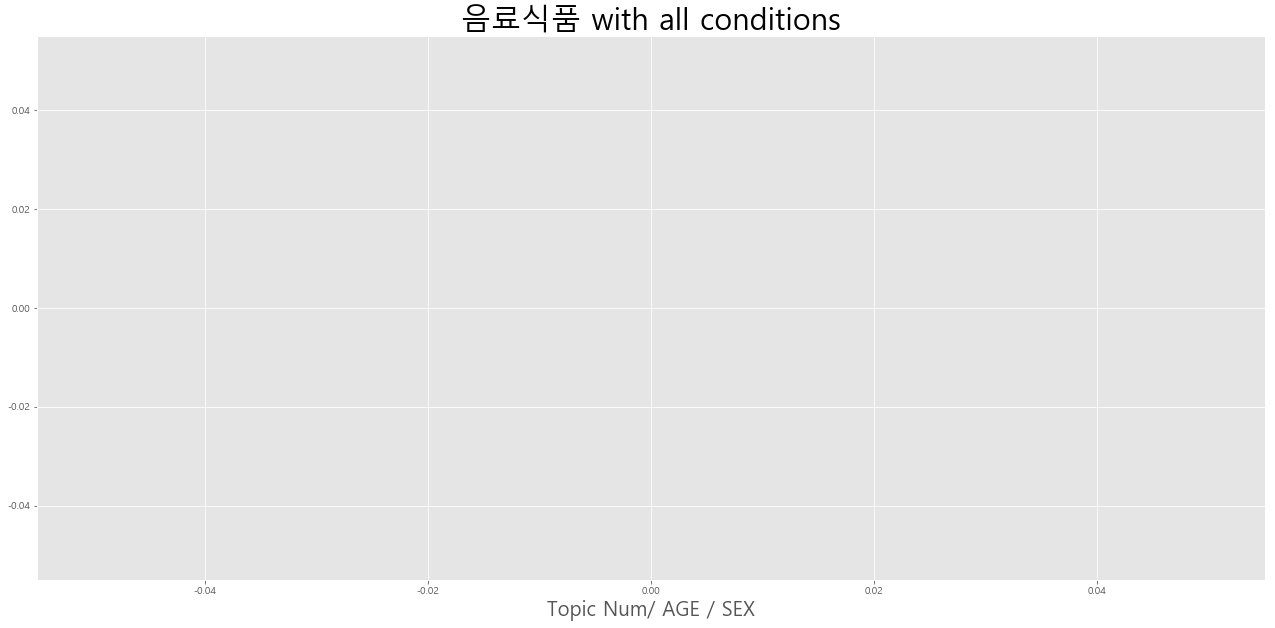

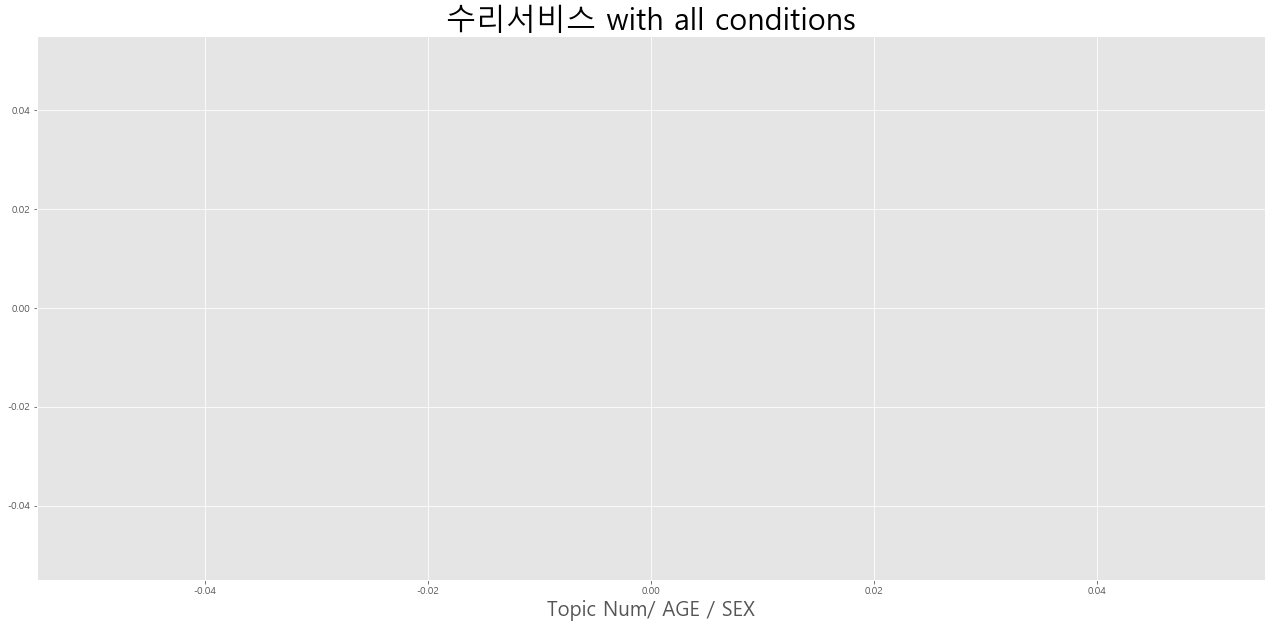

In [58]:
for i in market_names : 
    temp = m2[m2[0] == i]
    x = temp[5]
    y = temp[3]
    
    titlename = "{0} with all conditions".format(i)
    
    ax = plt.bar(x, y, color = "navy")
    
    #u = max(u1, u2)
    #l = min(l1, l2)
    plt.xlabel("Topic Num/ AGE / SEX", fontsize = 20)

    #plt.ylim(l, u)
    #plt.rcParams['font.family'] = "serif"
    plt.title(titlename, fontsize = 30)
    plt.gcf().set_size_inches(22,10)
    #plt.figure.s(18.5, 10.5)
    
    plt.show()

In [76]:
temp = m2[m2[0] == "주방용구"]

In [77]:
temp = temp.sort_values(3)
print(temp)

        0   1  2           3          4        5
114  주방용구  45  F  -74.658972  주방용구/45/F   2/45/F
149  주방용구  45  F  -74.277208  주방용구/45/F   9/45/F
159  주방용구  45  F  -71.344654  주방용구/45/F  11/45/F
108  주방용구  65  M  -70.736375  주방용구/65/M   1/65/M
175  주방용구  65  M  -70.292924  주방용구/65/M  13/65/M
185  주방용구  45  F  -70.227350  주방용구/45/F  15/45/F
153  주방용구  45  F  -69.884199  주방용구/45/F  10/45/F
125  주방용구  45  F  -69.211806  주방용구/45/F   4/45/F
167  주방용구  40  F  -67.839650  주방용구/40/F  12/40/F
143  주방용구  45  F  -65.022556  주방용구/45/F   7/45/F
181  주방용구  45  F  -64.893041  주방용구/45/F  14/45/F
106  주방용구  20  M  -64.680744  주방용구/20/M   1/20/M
146  주방용구  25  M  -62.265116  주방용구/25/M   8/25/M
158  주방용구  35  F  -61.476059  주방용구/35/F  11/35/F
184  주방용구  35  F  -60.051572  주방용구/35/F  15/35/F
107  주방용구  25  M  -59.640195  주방용구/25/M   1/25/M
136  주방용구  25  M  -59.475124  주방용구/25/M   6/25/M
152  주방용구  35  F  -58.607186  주방용구/35/F  10/35/F
113  주방용구  35  F  -57.530966  주방용구/35/F   2/35/F
130  주방용구  35  F  -5

In [83]:
t = temp.iloc[0 :10]
b = temp.iloc[-11 : ]

In [84]:
t

,0,1,2,3,4,5
114,주방용구,45,F,-74.658972,주방용구/45/F,2/45/F
149,주방용구,45,F,-74.277208,주방용구/45/F,9/45/F
159,주방용구,45,F,-71.344654,주방용구/45/F,11/45/F
108,주방용구,65,M,-70.736375,주방용구/65/M,1/65/M
175,주방용구,65,M,-70.292924,주방용구/65/M,13/65/M
185,주방용구,45,F,-70.227350,주방용구/45/F,15/45/F
153,주방용구,45,F,-69.884199,주방용구/45/F,10/45/F
125,주방용구,45,F,-69.211806,주방용구/45/F,4/45/F
167,주방용구,40,F,-67.839650,주방용구/40/F,12/40/F
143,주방용구,45,F,-65.022556,주방용구/45/F,7/45/F


In [85]:
b

,0,1,2,3,4,5
88,주방용구,45,M,160.319070,주방용구/45/M,12/45/M
7,주방용구,40,F,161.734621,주방용구/40/F,2/40/F
42,주방용구,40,F,162.986817,주방용구/40/F,7/40/F
43,주방용구,45,M,167.941886,주방용구/45/M,7/45/M
17,주방용구,40,F,176.140523,주방용구/40/F,4/40/F
2,주방용구,45,F,178.735976,주방용구/45/F,1/45/F
44,주방용구,65,M,180.546280,주방용구/65/M,7/65/M
11,주방용구,45,F,186.527150,주방용구/45/F,3/45/F
74,주방용구,40,F,206.319212,주방용구/40/F,11/40/F
67,주방용구,40,F,211.373741,주방용구/40/F,10/40/F


In [86]:
def plot_top(i, color) : 
    temp = i
    x = temp[5]
    y = temp[3]
    #print(y)
    
    
    
    #yt = y[y[:,3].argsort()]
    
    titlename = "Top 10 Factors"
    
    ax = plt.bar(x, y, color = color)
    
    #u = max(u1, u2)
    #l = min(l1, l2)
    plt.xlabel("Topic Num/ AGE / SEX", fontsize = 20)
    
    plt.gca().set_xticklabels(x, rotation = 0, horizontalalignment = "right", fontsize = 16)

    #plt.ylim(l, u)
    #plt.rcParams['font.family'] = "serif"
    plt.title(titlename, fontsize = 30)
    plt.gcf().set_size_inches(15,8)
    plt
    #plt.figure.s(18.5, 10.5)
    
    plt.show()

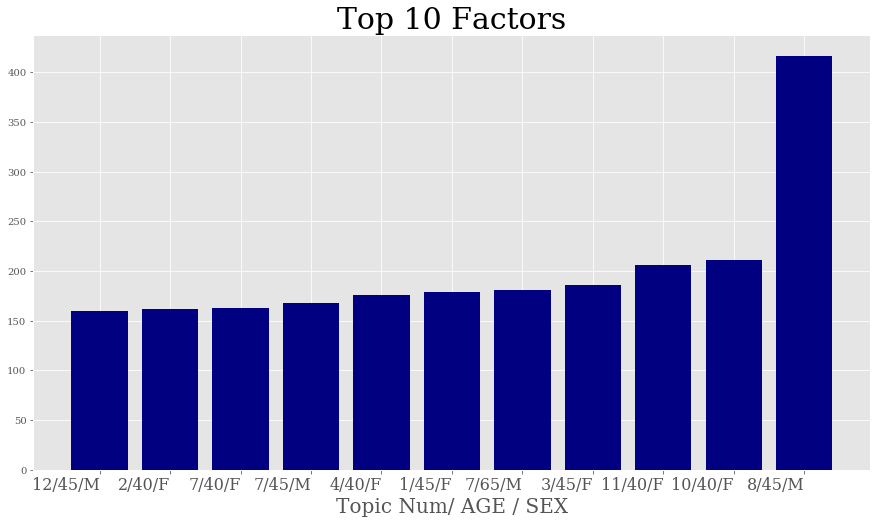

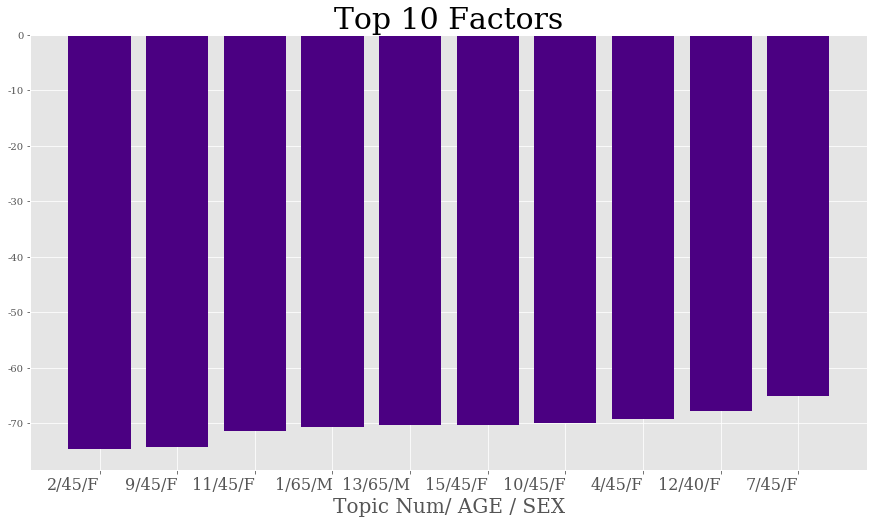

In [87]:
plot_top(b, "navy")
plot_top(t, "indigo")